In [1]:
import nltk
import re
import difflib
from nltk.tokenize import TweetTokenizer
import re
import difflib
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random #As of now only used for generating 100 random tweets for manual labelling
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report, roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline


# Preprocessing

In [2]:
# Data loading 

# offensive
off_train = open("../data/raw/offensive/train_text.txt", "r", encoding="utf-8")
off_test = open("../data/raw/offensive/test_text.txt", "r", encoding="utf-8")
off_mapping = open("../data/raw/offensive/mapping.txt", "r", encoding="utf-8").read()

# sentiment 
sentiment_train = open("../data/raw/sentiment/train_text.txt", "r", encoding="utf-8")
sentiment_test = open("../data/raw/sentiment/test_text.txt", "r", encoding="utf-8")
sentiment_mapping = open("../data/raw/sentiment/mapping.txt", "r", encoding="utf-8")

inputlist = [line for line in off_train]

sent = [line for line in sentiment_train]
training_data, validation_data = inputlist[:len(inputlist)//2], inputlist[len(inputlist)//2:]


In [3]:
off_train

<_io.TextIOWrapper name='../data/raw/offensive/train_text.txt' mode='r' encoding='utf-8'>

Tokenization refers to splitting up a larger body of text into smaller lines, words etc. that are called tokens. We started with a word tokenization.  

This was done by using the RegEx module. 

We lastly compared the output of our final tokenizer with a baseline tweet tokenizer from the NLTK library. To investigate this we used the difflib library. Here each token is compared and the difference between them are displayed.

In [4]:

#patterns
token_pat = re.compile(r'\w+')
skippable_pat = re.compile(r'\s+')

unmatchable = []

for i in training_data:
	tokens = []
	line = i
	while line:
		skippable_match = re.search(skippable_pat, line)
		if skippable_match and skippable_match.start() == 0:
			# If there is one at the beginning of the line, just skip it.
			line = line[skippable_match.end():]
		else:
			# Else try finding a real token.
			token_match = re.search(token_pat, line)
			if token_match and token_match.start() == 0:
				# If there is one at the beginning of the line, tokenise it.
				tokens.append(line[:token_match.end()])
				line = line[token_match.end():]
			else:
				# Else there is unmatchable material here.
				# It ends where a skippable or token match starts, or at the end of the line.
				unmatchable_end = len(line)
				if skippable_match:
					unmatchable_end = skippable_match.start()
				if token_match:
					unmatchable_end = min(unmatchable_end, token_match.start())
				# Add it to unmatchable and discard from line.
				unmatchable.append(line[:unmatchable_end])
				line = line[unmatchable_end:]
	print(tokens)
print("unmatchable:",set(unmatchable))

"""
DO include the following characters:
[*, !, ]
"""


['user', 'Bono', 'who', 'cares', 'Soon', 'people', 'will', 'understand', 'that', 'they', 'gain', 'nothing', 'from', 'following', 'a', 'phony', 'celebrity', 'Become', 'a', 'Leader', 'of', 'your', 'people', 'instead', 'or', 'help', 'and', 'support', 'your', 'fellow', 'countrymen']
['user', 'Eight', 'years', 'the', 'republicans', 'denied', 'obama', 's', 'picks', 'Breitbarters', 'outrage', 'is', 'as', 'phony', 'as', 'their', 'fake', 'president']
['user', 'Get', 'him', 'some', 'line', 'help', 'He', 'is', 'gonna', 'be', 'just', 'fine', 'As', 'the', 'game', 'went', 'on', 'you', 'could', 'see', 'him', 'progressing', 'more', 'with', 'his', 'reads', 'He', 'brought', 'what', 'has', 'been', 'missing', 'The', 'deep', 'ball', 'presence', 'Now', 'he', 'just', 'needs', 'a', 'little', 'more', 'time']
['user', 'user', 'She', 'is', 'great', 'Hi', 'Fiona']
['user', 'She', 'has', 'become', 'a', 'parody', 'unto', 'herself', 'She', 'has', 'certainly', 'taken', 'some', 'heat', 'for', 'being', 'such', 'an', 'w

['user', 'user', 'cooktragic', 'This', 'NOT', 'good', 'news', 'for', 'either', 'Australian', 'women', 'or', 'Palestine', 'It', 'is', 'ridiculous', 'to', 'pretend', 'otherwise', 'Our', 'only', 'hope', 'is', 'his', 'election', 'is', 'not', 'successful', 'Or', 'the', 'abysmal', 'history', 'of', 'women', 'in', 'LNP', 'continues', 'He', 'is', 'not', 'a', 'gentleman', 'In', 'our', 'culture', 'it', 'is', 'Ladies', 'First']
['user', 'user', 'ok', 'with', 'Andrew', 'user', 'Bully', 'Liar', 'touchy', 'cheat', 'to', 'be', 'kept', 'on', 'as', 'a', 'MP', 'On', '75k', 'No', 'anti', 'bullying', 'rules', 'user', 'user', 'user', 'user']
['user', 'Bono', 'is', 'utterly', 'stupid', 'ridiculous', 'wealthy', 'tax', 'avoiding', 'hypocrite', 'fascist', 'I', 'can', 't', 'listen', 'to', 'U2', 'again']
['user', 'I', 'am', 'trying', 'to', 'make', 'a', 'point', 'Many', 'people', 'who', 'hate', 'the', 'liberal', 'and', 'ndp', 'party', 'are', 'conservatives', 'And', 'all', 'conservatives', 'care', 'about', 'is', 'm

['user', 'user', 'I', 'wouldn', 't', 'trust', 'Chuck', 'Schumer', 'ever', 'He', 's', 'a', 'liar', 'and', 'the', 'president', 'doesn', 't', 'trust', 'him', 'either']
['user', 'Didn', 't', 'the', 'polls', 'say', 'Hillary', 'was', 'going', 'to', 'be', 'President']
['user', 'Sure', 'thing']
['user', 'Fuck', 'u']
['user', 'Did', 'you', 'hear', 'that', 'user', 'had', 'a', 'game', 'taken', 'away', 'from', 'her', 'because', 'she', 'called', 'an', 'official', 'a', 'theif', 'after', 'he', 'took', 'a', 'point', 'and', 'he', 'only', 'took', 'a', 'game', 'away', 'from', 'her', 'because', 'she', 'is', 'a', 'woman', 'and', 'he', 'd', 'never', 'have', 'done', 'that', 'to', 'a', 'man', 'Would', 'love', 'to', 'hear', 'your', 'thoughts', 'on', 'this']
['user', 'Tough', 'to', 'say', 'because', 'football', 'manages', 'to', 'appeal', 'to', 'all', 'sides', 'of', 'the', 'spectrum', 'except', 'maybe', 'the', 'far', 'most', 'liberals', 'sorry', 'for', 'the', 'rant', 'lol']
['user', 'user', 'user', 'user', 'user

['user', 'user', 'thank', 'god', 'for', 'the', 'PPC', 'party', 'eh', 'true', 'conservatives', 'who', 'believe', 'in', 'getting', 'out', 'of', 'the', 'Paris', 'accord', 'and', 'dropping', 'supply', 'and', 'demand', 'on', 'Dairy']
['user', 'user', 'user', 'user', 'user', 'We', 'can', 'win', 'the', 'Menendez', 'seat', 'for', 'MAGA', 'There', 'are', '2', '4', 'million', 'registered', 'Independent', 'Republicans', 'in', 'NJ', 'amp', 'we', 'outnumber', 'establishment', 'R', 's', '2', '1', 'Only', '2', '1', 'million', 'registered', 'D', 's', 'in', 'NJ', 'On', 'November', '6th', 'in', 'NJ', 'R', 'is', 'for', 'RINO', 'This', 'mid', 'term', 'in', 'NJ', 'True', 'Red', 'is', 'I', 'R']
['user', 'Lolol', 'God', 'he', 'is', 'such', 'an', 'a', 'hole']
['user', 'hello', 'i', 'ate', 'soup', 'and', 'now', 'i', 'm', 'very', 'tired', 'but', 'i', 'love', 'you']
['MAGA', 'DEEP', 'STATE', 'VIDEO', 'EXPOSED']
['user', 'A', 'vulgar', 'attempt', 'to', 'reduce', 'sisterhood', 'to', 'genitalia']
['user', 'He', 'ha

['user', 'can', 'we', 'start', 'shooting', 'the', 'blue', 'thugs', 'then', 'going', 'through', 'their', 'shit', 'and', 'saying', 'thats', 'why', 'they', 'died', 'cuz', 'this', 'is', 'fucking', 'infuriating', 'WTF', 'does', 'it', 'matter', 'there', 'is', 'pot', 'in', 'his', 'home', 'WHAT', 'is', 'in', 'HER', 'home', 'SHE', 'is', 'the', 'guilty', 'one', 'not', 'HIM']
['user', 'user', 'Barking', 'mad', 'you', 'are', 'who', 'let', 'the', 'dogs', 'out', 'Bekhit', 'Fahim', 'YouTube']
['user', 'ajsjjsjdkkdjdk', 'i', 'want', 'him', 'so', 'much', 'he', 'd', 'literally', 'tell', 'me', 'to', 'die', 'and', 'i', 'd', 'obey', 'him']
['user', 'Donald', 'Trump', 'has', 'always', 'been', 'a', 'dangerous', 'animal', 'to', 'the', 'defeated', 'liberal', 'left', 'demonrat', 'and', 'communists', 'like', 'Brennan']
['user', 'user', 'Dammit', 'I', 'fell', 'asleep', 'Can', 'someone', 'tell', 'me', 'what', 'they', 'were', 'chanting', 'about']
['user', 'Her', 'family', 'consist', 'of', 'Cheating', 'husband', 'wh

['user', 'Can', 'we', 'all', 'stop', 'pretending', 'that', 'the', 'Catholic', 'Church', 'is', 'not', 'the', 'seat', 'of', 'Satan', 'on', 'earth']
['user', 'Just', 'came', 'here', 'from', 'the', 'video', 'and', 'man', 'am', 'I', 'discusted', 'by', 'greg', 'seriously', 'he', 'is', 'taking', 'advantage', 'of', 'his', 'sons', 'fame', 'f', 'k', 'greg']
['user', 'user', 'We', 'are', 'ready', 'whenever', 'you', 'are']
['user', 'user', 'Like', 'how', 'the', 'NRA', 'is', 'biased', 'against', 'gun', 'control']
['user', 'FINALLY', 'HOLY', 'SHIT', 'YOU', 'ARE', 'FINALLY', 'READING', 'THE', 'GOAT']
['user', 'He', 'IS', 'Mark', 'Twain', 'in', 'my', 'eyes', 'Love', 'him']
['user', 'Goodell', 'and', 'my', 'Lions', 'both', 'suck']
['this', 'obvious', 'hit', 'job', 'on', 'kavannah', 'is', 'not', 'going', 'to', 'work', 'and', 'the', 'liberals', 'continue', 'to', 'reveal', 'themselves', 'as', 'demonic', 'figures']
['user', 'Right', 'Good', 'grief', 'he', 'is', 'just', 'perfect']
['user', 'user', 'user', '

['user', 'Hey', 'user', 'why', 'don', 't', 'you', 'just', 'leave', 'then', 'It', 's', 'ok', 'we', 'll', 'be', 'ok', 'without', 'you', 'Let', 'us', 'know', 'how', 'much', 'better', 'things', 'are', 'where', 'you', 'end', 'up']
['user', 'Maybe', 'there', 'wouldn', 't', 'be', '5', 'of', 'these', 'things', 'a', 'day', 'of', 'there', 'was', 'a', 'little', 'sensible', 'gun', 'control', 'in', 'this', 'fucking', 'country']
['user', 'Over', '30', 'years', 'worth', 'of', 'background', 'checks', 'under', 'different', 'Presidents', 'and', 'this', 'one', 'slipped', 'through', 'KavanaughConfirmation', 'KavanaughWithdraw', 'KavanaughSCOTUS', 'maga']
['user', 'Ask', 'the', 'liberals', 'who', 'have', 'seemingly', 'forgotten', 'that', 'you', 're', 'a', 'war', 'criminal']
['user', 'user', 'All', 'the', 'news', 'outlets', 'can', 'continue', 'to', 'write', 'stories', 'about', 'Michael', 'Moore', 'and', 'what', 'he', 'says', 'but', 'I', 'm', 'one', 'of', 'the', 'millions', 'that', 'don', 't', 'really', 'giv

['user', 'She', 'used', 'her', 'power', 'and', 'authoritative', 'position', 'over', 'this', 'child', 'to', 'manipulate', 'him', 'and', 'get', 'him', 'drunk', 'so', 'she', 'would', 'have', 'him', 'at', 'her', 'disposal', 'Now', 'she', 'is', 'using', 'her', 'gender', 'as', 'an', 'excuse', 'and', 'claiming', 'the', 'victim', 'assaulted', 'her', 'when', 'we', 'have', 'text', 'messages', 'and', 'pictures', 'that', 'show', 'otherwise']
['user', 'You', 'are', 'becoming', 'unhinged', 'with', 'this', 'game']
['user', 'user', 'user', 'user', 'user', 'user', 'user', 'Or', 'a', 'piss', 'up', 'in', 'a', 'brewery', 'Hat']
['She', 'is', 'dirty', 'like', 'Trump', 'She', 'stole', 'Ted', 'Cruz', 'campaign', 'voters', 'list', 'and', 'gave', 'it', 'to', 'Trump']
['user', 'Good', 'bye', 'Flakey', 'Fake', 'and', 'good', 'riddance']
['user', 'user', 'And', 'those', 'same', 'politicians', 'from', 'both', 'user', 'and', 'user', 'are', 'selling', 'the', 'country', 'down', 'the', 'drain']
['user', 'user', 'user'

['user', 'I', 'doubt', 'if', 'he', 'is', 'afraid', 'of', 'France', 'but', 'he', 'is', 'being', 'hammered', 'by', 'the', 'left', 'here', 'everyday', 'We', 'think', 'it', 's', 'France', 'behind', 'the', 'genocide', 'secretly', 'for', 'investments', 'They', 'sure', 'are', 'silent', 'Not', 'the', 'ordinary', 'French', 'people', 'the', 'global', 'elites', 'and', 'banks', 'My', 'guess', 'is', 'you', 'will', 'get', 'help']
['Open', 'borders', 'will', 'bring', 'this', 'to', 'America', 'Dems', 'are', 'brainless', 'Vote', 'red', 'like', 'your', 'life', 'depends', 'on', 'it', 'because', 'it', 'does', 'KAG', 'MAGA']
['user', 'user', 'user', 'Because', 'the', 'accuser', 'didn', 't', 'have', 'time', 'to', 'delete', 'all', 'her', 'radical', 'leftist', 'tweets', 'by', 'then']
['user', 'He', 'always', 'shows', 'dedication', 'at', 'what', 'he', 'does', 'no', 'wonder', 'he', 'is', 'the', 'best']
['user', 'So', 'funny', 'how', 'the', 'liberals', 'can', 'see', 'this', 'in', 'others', 'but', 'not', 'in', 't

['user', 'Why', 'only', 'a', 'fact', 'checking', 'tweet', 'for', 'a', 'Democrat', 'I', 'would', 'expect', 'these', 'tweets', 'for', 'all', 'political', 'candidates', 'Or', 'does', 'the', 'AP', 'only', 'do', 'this', 'for', 'Liberals']
['user', 'Die', 'bitch']
['user', 'user', 'If', 'you', 'want', 'societal', 'dregs', 'take', 'a', 'look', 'at', 'antifa']
['Tennessee', 'Conservatives', 'RNRTN', '2ADefenders', 'Republicans', 'ProLifeGen', 'TNGOP', 'Libertarians', 'ProLife', 'Gaytriots', 'RNR', 'CCOT', 'Are', 'YOU', 'doing', 'your', 'part', 'to', 'grow', 'Are', 'YOU', 'registering', 'voters', 'Planned', 'Parenthood', 'is', 'Pause', 'Think', 'about', 'that', 'It', 'speaks', 'volumes']
['the', 'liberal', 's', 'tendency', 'to', 'deal', 'with', 'opponents', 'by', 'epithet', 'rather', 'than', 'argument', 'and', 'worst', 'of', 'all', 'the', 'liberals', 'have', 'left', 'themselves', 'open', 'to', 'the', 'cruel', 'joke', 'that', 'says', 'they', 'love', 'humanity', 'but', 'hate', 'people', 'Richard'

['user', 'user', 'user', 'user', 'You', 'ignored', 'my', 'question', 'which', 'is', 'crucial', 'to', 'the', 'argument', 'Once', 'sensible', 'gun', 'control', 'is', 'imposed', 'and', 'another', 'shooting', 'occurs', 'do', 'you', 'truly', 'believe', 'they', 'will', 'not', 'push', 'for', 'further', 'restrictions']
['user', 'Who', 'does', 'he', 'think', 'he', 'is', 'the', 'dumb', 'Donald']
['user', 'Why', 'isn', 't', 'she', 'is', 'custody', 'I', 'understand', 'she', 'cannot', 'be', 'in', 'general', 'population', 'but', 'she', 'should', 'be', 'in', 'custody', 'and', 'in', 'some', 'sort', 'of', 'holding', 'cell']
['user', 'It', 's', 'SOP', 'for', 'conservatives', 'defend', 'every', 'Republican', 'fully', 'no', 'matter', 'the', 'seriousness', 'of', 'the', 'charge', 'or', 'evidence', 'Demand', 'every', 'Democrat', 'resign', 'no', 'matter', 'what']
['user', 'Any', 'day', 'you', 'free', 'I', 'm', 'dead', 'ass', 'serious', 'an', 'don', 't', 'call', 'me', 'talking', 'about', 'come', 'get', 'him', 

['user', 'user', 'Still', 'a', 'lot', 'of', 'religious', 'conservatives', 'but', 'hopefully', 'Beto', 'is', 'getting', 'a', 'bunch', 'of', 'unlikely', 'voters', 'that', 'the', 'polls', 'don', 't', 'capture']
['user', 'what', 'the', 'fuck']
['user', 'She', 'is', 'a', 'lost', 'Soul', 'who', 'has', 'to', 'follow', 'the', 'Party', 'Line', 'I', 'also', 'believe', 'she', 'has', 'sold', 'her', 'Soul', 'for', 'the', 'Lousy', '30Pieces', 'of', 'Silver', 'from', 'the', 'guidance', 'of', 'her', 'Horrible', 'Mother']
['user', 'AmazonPets', 'This', 'is', 'bonnie', 'she', 'is', '2', 'years', 'old', 'and', 'very', 'friendly', 'she', 'has', 'been', 'through', 'the', 'wars', 'as', 'she', 'got', 'attacked', 'by', 'another', 'dog', 'She', 'would', 'love', 'to', 'be', 'the', 'face', 'of', 'AmazonPets']
['user', 'Hahaha', 'lunatic', 'liberals', 'are', 'just', 'too', 'busy', 'virtue', 'signaling', 'that', 'they', 'still', 'don', 't', 'get', 'it']
['user', 'user', 'Yup', 'basically', 'another', 'dead', 'cat'

['user', 'Yes', 'yes', 'he', 'is', 'Melanie', 's', 'boyfriend']
['user', 'A', 'quick', 'way', 'to', 'get', 'yourself', 'killed', 'Thanks', 'Antifa']
['user', 'Red', 'Flags', 'She', 's', 'a', 'professor', 'at', 'a', 'liberal', 'school', 'and', 'she', 's', 'unable', 'to', 'have', 'healthy', 'relationships', 'with', 'men', 'Translation', 'She', 's', 'an', 'Antifa', 'Dyke', 'out', 'to', 'stop', 'a', 'Conservative', 'Judge', 'and', 'President', 'Trump', 'even', 'if', 'she', 'has', 'to', 'lie']
['user', 'user', 'YOU', 'ARE', 'SO', 'GOOD', 'ARE', 'U', 'SERIOUS', 'OMG']
['user', 'user', 'You', 'are', 'betting', 'on', 'it', 'you', 'just', 'don', 't', 'have', 'a', 'choice']
['user', 'user', 'Only', 'if', 'you', 'want', 'a', 'murder', 'charge', 'Stealing', 'guns', 'is', 'already', 'a', 'felony', 'Shooting', 'someone', 'with', 'their', 'own', 'gun', 'is', 'life', 'in', 'prison', 'at', 'best', 'There', 'is', 'just', 'no', 'way', 'this', 'ends', 'well', 'for', 'whoever', 'tries', 'this', 'I', 'hones

['user', 'Like', 'if', 'alt', 'right', 'dudes', 'were', 'born', 'in', 'Berkeley', 'they', 'd', 'be', 'antifa']
['user', 'The', 'voters', 'have', 'decided', 'about', 'gun', 'control', 'They', 'have', 'gotten', 'bloodshed', 'on', 'a', 'daily', 'basis']
['user', 'Didn', 't', 'know', 'he', 'was', 'still', 'alive']
['user', 'user', 'Wait', 'you', 'don', 't', 'know', 'who', 'she', 'is', 'Oh', 'boy']
['user', 'user', 'Why', 'wasn', 't', 'we', 'given', 'the', 'chance', 'to', 'change', 'our', 'minds', 'for', '43years', 'also', 'if', 'we', 'have', 'another', 'vote', 'and', 'you', 'win', 'can', 'we', 'change', 'our', 'minds', 'again', 'or', 'will', 'all', 'changing', 'of', 'minds', 'be', 'banned', 'when', 'you', 'get', 'your', 'way']
['user', 'How', 'about', 'telling', 'Senator', 'Cory', 'Spartacus', 'Booker', 'to', 'stop', 'taking', 'money', 'from', 'big', 'pharma', 'And', 'how', 'about', 'if', 'AARP', 'stops', 'being', 'so', 'biased', 'towards', 'the', 'liberals', 'and', 'remember', 'that', 'so

['user', 'user', 'user', 'So', 'you', 'are', 'defending', 'antifa', 'Is', 'that', 'your', 'stance']
['user', 'user', 'user', 'Dam', 'girl', 'you', 'have', 'awesome', 'boobs', 'I', 'bet', 'you', 'are', 'a', 'very', 'sexy', 'MILF']
['user', 'Have', 'the', 'vote', 'Enough', 'delay', 'tactics', 'This', 'is', 'an', 'allegation', 'He', 'is', 'not', 'convicted']
['user', 'Thank', 'you', 'for', 'saving', 'the', 'dogs', 'why', 'are', 'people', 'assholes']
['Keith', 'Ellison', 'Accuser', 'Calls', 'Out', 'Dems', 'Amid', 'Kavanaugh', 'Allegation', 'I', 've', 'Been', 'Smeared', 'By', 'My', 'Own', 'Party', 'Keith', 'Ellison', 'has', 'no', 'room', 'to', 'accuse', 'ANYBODY', 'of', 'wrong', 'doing', 'KavanaughConfirmation', 'TuesdayThoughts', 'MAGA']
['user', 'Doubtful', 'He', 's', 'one', 'of', 'the', 'least', 'hateful', 'people', 'on', 'this', 'planet', 'Maybe', 'you', 're', 'looking', 'in', 'a', 'mirror']
['user', 'user', 'user', 'user', 'user', 'Now', 'I', 'know', 'you', 're', 'having', 'a', 'laugh'

['user', 'user', 'It', 'was', 'thirty', 'years', 'ago', 'supposedly', 'if', 'you', 'keep', 'something', 'a', 'secret', 'that', 'long', 'it', 'usually', 'didn', 't', 'happen', 'and', 'he', 's', 'gone', 'through', 'several', 'other', 'confirmations', 'in', 'the', 'past', 'and', 'it', 'never', 'came', 'up', 'this', 'is', 'just', 'how', 'liberals', 'play', 'politics', 'nowadays']
['user', 'yesterday', 'this', 'happen', 'here', 'So', 'much', 'for', 'gun', 'control', 'when', 'you', 'can', 't', 'prevent', 'a', '2nd', 'grader', 'from', 'bringing', 'a', 'gun', 'to', 'school', 'huh']
['USER', 'You', 'Sir', 'are', 'correct', 'There', 'are', 'so', 'many', 'GOOD', 'MEN', 'She', 'is', 'completely', 'out', 'of', 'line']
['user', 'user', 'You', 'just', 'said', 'the', 'same', 'things', 'all', 'the', 'liberals', 'say', 'President', 'Trump', 'is', 'not', 'deporting', 'immigrants', 'He', 's', 'trying', 'to', 'deport', 'people', 'who', 'sneak', 'into', 'this', 'country', 'amp', 'not', 'follow', 'the', 'rul

['user', 'user', 'Antifa', 'is', 'much', 'much', 'smaller', 'than', 'white', 'supremacists', 'in', 'America', 'and', 'responsible', 'for', 'a', 'fraction', 'of', 'the', 'violence', 'Also', 'NAZI', 'S', 'ARE', 'BAD']
['user', 'user', 'I', 'am', 'beginning', 'to', 'believe', 'that', 'all', 'liberals', 'are', 'sociopaths', 'None', 'of', 'the', 'people', 'here', 'believe', 'in', 'rule', 'of', 'law', 'You', 'have', 'to', 'have', 'evidence', 'of', 'a', 'crime', 'to', 'go', 'any', 'further', 'ConfirmBrettKavanaughNow']
['user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'Like', 'a', 'gazelle', 'fleeing', 'an', 'antifa', 'mob']
['guns', '2A', 'Last', 'Lockdown', 'statues', 'part', 'of', 'gun', 'control', 'group', 's', 'plan', 'to', 'change', 'minds', 'in', 'pro', 'gun', 'districts', 'Tucker', 'Left', 'colluding', 'with', 'companies', 'to', 'suppress', 'gun', 'rights', 'Tucker', 'The', 'ideological', 'gap', 'be

['user', 'user', 'You', 'are', 'not', 'God', 'and', 'you', 'have', 'no', 'idea', 'who', 'he', 'is', 'God', 'doesn', 't', 'say', 'we', 'can', 't', 'like', 'people', 'in', 'fact', 'I', 'feel', 'he', 'sent', 'us', 'Trump', 'in', 'answer', 'to', 'our', 'prayers']
['user', 'Well', 'she', 'is', 'better', 'looking', 'than', 'the', 'lying', 'chicks', 'lawyer']
['user', 'Blame', 'Trump', 'for', 'the', 'weather', 'and', 'the', 'corruption', 'that', 'existed', 'for', 'decades', 'in', 'PR', 'What', 'an', 'ass', 'typical', 'democratic']
['user', 'And', 'let', 's', 'hope', 'it', 'just', 'gets', 'a', 'lot', 'worse']
['user', 'user', 'In', 'the', 'criminal', 'world', 'of', 'the', 'democrats', 'amp', 'liberals', 'this', 'is', 'exactly', 'how', 'it', 'works']
['user', 'Yes', 'you', 'are']
['user', 'So', 'then', 'your', 'saying', 'the', 'user', 'platform', 'of', 'gun', 'control', 'and', 'reform', 'is', 'nothing', 'for', 'them', 'to', 'worry', 'about', 'Kind', 'of', 'like', 'Kavanaugh', 'is', 'going', 'to

'\nDO include the following characters:\n[*, !, ]\n'

In [5]:
## patterns
def tokenizer(tweets):
    """
    Function that takes a list of strings and returns the tokenized version of each string
    """

    token_pat = re.compile(r'[\w@’#]+')
    skippable_pat = re.compile(r'\s+')

    non_white_space = re.compile(r'[^@’#\w\s]') #Finds characters that are not white_space nor word characters (nor @’#)


    tokenlist = []
    for i in tweets:
        tokens = []
        unmatchable = []
        line = i
        while line:
            skippable_match = re.search(skippable_pat, line)
            nws_match = re.search(non_white_space, line) #Search for non-word && non-whitespace chars (nws = non_white_space)
            if skippable_match and skippable_match.start() == 0:
                # If there is one at the beginning of the line, just skip it.
                line = line[skippable_match.end():]

            elif nws_match and nws_match.start() == 0: # If a character is neither non_white_space nor a word-character
                tokens.append(line[:nws_match.end()]) #Append it to tokens
                line = line[nws_match.end():] #Move further along in line
            else:
                # Else try finding a real token.
                token_match = re.search(token_pat, line)
                if token_match and token_match.start() == 0:
                    # If there is one at the beginning of the line, tokenise it.
                    tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
                else:
                    # Else there is unmatchable material here.
                    # It ends where a skippable or token match starts, or at the end of the line.
                    unmatchable_end = len(line)
                    if skippable_match:
                        unmatchable_end = skippable_match.start()
                    if token_match:
                        unmatchable_end = min(unmatchable_end, token_match.start())
                    # Add it to unmatchable and discard from line.
                    unmatchable.append(line[:unmatchable_end])
                    line = line[unmatchable_end:]
        tokenlist.append(tokens)
    return(tokenlist)



In [6]:
token_tweets = tokenizer(training_data)
[print(*i) for i in token_tweets]

@user Bono . . . who cares . Soon people will understand that they gain nothing from following a phony celebrity . Become a Leader of your people instead or help and support your fellow countrymen .
@user Eight years the republicans denied obama’s picks . Breitbarters outrage is as phony as their fake president .
@user Get him some line help . He is gonna be just fine . As the game went on you could see him progressing more with his reads . He brought what has been missing . The deep ball presence . Now he just needs a little more time
@user @user She is great . Hi Fiona !
@user She has become a parody unto herself ? She has certainly taken some heat for being such an . . . . well idiot . Could be optic too Who know with Liberals They ' re all optics . No substance
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user This is the VetsResistSquadron " " is Bullshit . . They are girl scout veterans , I have never met any other veterans or served with a

@user @user @user Do it with quran and then we will see how much atheist and brave she is . . . hindus figured it out that this type of attention grabbing big boss wanna be people are not worth it . . . Go live in your 2 minutes Prime Time covered life . . . Lord krishna and his followers don ' t care
@user But she is hecking cute fluffer
#Labour #Councillor shouting Nazi Scum . . At victims of #GroomingGangs and this is going to get worse under #JeremyCorbyn ' s socialist #Britain #Muslims #Islam #Leftists #MAGA #MEGA #MCGA #MEGA #Patriots #Conservatives
@user @user @user How about your outrage over this ? Do something so you can be credible instead of being perceived as demagogues partisans #MAGA
@user Yee yee
@user @user @user @user Huh ! The pot grows as council grows . . . in this case it is a reduction . . . and that amount $ 25m is going right back to the city for police gun control . . . already announced !
@user @user @user @user Whoa ! Angie ! ! ! Back off that logic ! You ' 

@user Fat ass . . . . heart attack city . . . . . keep eating fat ass . . . .
@user @user Much of your promise of money is not extra / new as govt took back £ 817 MILLION promised for new affordable " " homes ! Stop Right to Buy - we have a @user created #HousingCrisis now , too little , too late !
@user As it gets closer to November the left is in full on panic mode their talking points will forever be 25th Amendment . Ok idiots let’s see you try it .
@user Nigga then how can you say bo2 is the best Cod 🤨
@user @user You are right I ' m black so thanks
- Will liberals agree that any is destructive ?
@user @user @user @user @user She can do a Google search of protests by antifa but she already knows that . It ' s called being blind . I would never support a conservative protest where they beat people up and destroyed property
@user @user @user @user @user @user @user @user @user @user Pretty much . As I’ve stated I believe is gun control just not this aspect of it . The guns aren’t the

@user @user @user @user @user My experience is the gun control activists don ' t really want a conversation , they want capitulation . The way around that would be to open with proposals to expand gun rights in exchange for whatever is they ' re looking for . There can ' t really be a conversation " " without that " "
#Liberals grasp at unproven straws . . . #NotPlastic
@user @user May be the cameramen is a Trump supporter . @user Have you checked if he is standing on a rock or so ? LMAO 😂 #FakeNewsCNN
@user I fucking loved that cat I am so sad
@user @user @user @user @user Liberals Don ' t Appreciate Your Sarcasm . They Thought You Were On Their Side .
@user It ' s fine . . . . . he ' s gods Prophet 🙄 imagine that nowadays . . . yes officer i did fuck that elementary student BUT its fine bc god said i could . . . .
@user Definantly
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user

@user @user How does that make him the best in the country though ? There was nothing special about the throw . How does that make me butt hurt ?
Antifa Caught Off Guard After Getting Confronted By The Last Person They Ever Wanted To Answer Too
@user There is no deal " " to be made on gun control , knob . The 2nd Amendment is a right that no one can deal away . " "
@user Can we please now be honest with ourselves and acknowledge this trans stuff is a mental disorder ? And NOT normal human behavior ?
@user @user Son please don’t make me cry today because I never saw this shit
@user 1 & amp ; 7 blocking my way to hap ' penis
. @USER absolutely right to not propose another referendum . . @USER are not in power & amp ; we are not negotiating . It’s for @user to make Brexit work ; it belongs to them . If they can’t do that then @user should call a General Election . Labour are ready .
#MAGA Why she not being prosecuted ?
@user @user @user Plus she is a REAL reporter and has the courage of a

@user HE IS MOE
@user @user @user @user @user @user Pedophilia is the worst of all evil
@user @user @user @user Gun control is never sensible .
@user @user @user who ' s singular wiped out a number of Lib Dem councils in the North by going into bed with the Conservatives thus losing local election seats . Now we have him trying to turn over a democratic vote on #Brexit .
@user I see you support gun control 😀
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Awesome Q meme on that !
@user Fun fact : rural areas with extremely high gun ownership rates has nearly - zero homicide rates while urban areas with extreme gun control ( low ownership rates ) has astronomically high homicide rates . Why is the correlation exactly opposite ?
@user I ' m not so sure . Only a mild inc

@user Congratulations to our Great American President . We will be doing great things together ! MAGA I - Q - 2 WWG1WGA
@user Do you support our POTUS ? ( Please help by retweeting and following after voting ! ) Long live USA 😍 #MAGA
#realDonaldTrump You ' ve been rather quiet today . I hope that you have spent some time thinking about your endgame with Vlad . I know you probably know this but you are very expendable to him . When we take the country back what will you do ? He will not be happy with you ! Ponder this
@user Can ' t a man call his dog without some old bat bitching about it ? @user
@user @user Your statement sums up the Lib Dem party tbh Brett . And the Conservatives . . . . . . . and the Labour Party . . . . . . . . . What a sorry state we are in ! !
@user @user @user @user eto ba ang hindi corrupt ? you are so naive if you think that this admin is different from previous admins
@user She is she blocked me
( Albert ) Conservatives are spreading the lie Anderson Cooper fa

@user I never said that . I merely refuted the statement that they don’t have a tight end . Virgil Green is a solid tight end when he is surrounded by the talent that the chargers have
@user And I you ya sexy lady you ♡
@user @user @user traitor whoever he or she is .
@user @user @user @user He is an awesome dog . Almost worth the trip
@user Good . He is a head case . Go get a Passrusher
@user I was actually thinking you were joining antifa .
@user @user Rodenbury was against violence and would have advocated for gun control .
@user @user You can listen to it on the Dana Show podcast !
@user Yes , Joy @user ? . . . . You were about to say Six - and - a - half years ? " " Because that ' s correct , you sociopath . You are " " stuck with this @user , " " f o r t h e n e x t SIX - & amp ; - ONE - HALF - YEARS . #MAGA2KAG @user 🇺 🇸 #WINNING " "
@user @user @user Oh - no benefits and employment goes up ! See how it works yet ?
97 % of Americans want a form of gun control . 62 % of Americans

@user Thank you for this tweet . Give them a call @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user
@user @user @user @user @user No kidding and I don ' t support that . Still doesn ' t cancel out the many violent protests by antifa . The money and support has been traced to George Soros and he is a big player within the democrat party
@user Does this mean you don ' t share the left ' s usual view on the 2nd amendment or does the constitution as the liberals say change with the times " " ? " "
@user @user Conversely you apparentl don ' t care about kids unless they are shot at school & amp ; can be used to promote gun control . Funny that AR you hate so much is used to kill far less people than criminals do with their arms and legs . When do you start calling for everyone to be dismembered ?
@user He is a very funny man isn ' t he . I suspect even he doesn ' t really believe this .
@user @user @user I absolutely agree ! ! I have tried rally

@user hello i ate soup and now i ' m very tired but i love you
#MAGA DEEP STATE VIDEO EXPOSED :
@user A vulgar attempt to reduce sisterhood to genitalia . . . . .
@user He had to fuck up . You can only give a guy so many chances no matter how talented he is
@user How ? You can’t just say “ Wrong ” with no evidence for why it is . You said you agree with Sargon I’m pretty much every subject but gun control and healthcare . That’s not what a centrist believes .
@user I SAW IT but mi * rosoft sucks at translations
@user Your continual use of Left liberal Progressive on your show are Euphemisms for the democrat Party who owns " " them until deny them & amp ; ideology . You are lying to the Public by not calling a spade a spade . " "
@user He is irrelevant
@user If the @user really want to conserve everything that is great about the #UK then they really need to bury this #fracking nonsense & amp ; do everything possible to make us energy efficient & amp ; fossil fuel free . @user please do 

@user We get shit transported from Africa niggas told me they seen venomous snakes Iguanas a beetle the size of a car tire lmaoooo 🤦 🏾 ‍ ♂ ️ 🤦 🏾 ‍ ♂ ️ 🤦 🏾 ‍ ♂ ️ 🤦 🏾 ‍ ♂ ️ all kinds of shit
@user Oh you are very welcome .
@user @user Kind of like when conservatives wanna associate everyone to their left as communist antifa members ?
@user Did you see what she said about Travis on Ellen ? ? That’s one hating ass bitch 😭
@user @user @user @user @user @user @user @user @user @user @user 😀 You are welcome .
@user Yeaaaahh she is ! ! & lt ; 33
@user @user John McEnroe is older than you are
@user Congratulations #POTUS #MAGA
@user @user @user @user @user @user @user @user @user @user @user I think he ' s a comrade
Political Unmasking of Team Trump Must Be Prosecuted - American Thinker #MAGA #PJNET #KAG #TrumpTrain #TrumpTrain2020 @user TW055
Shame on @user @user @user @user @user and all the rest of the left wing media that are not doing their jobs and purposely looking the other way . This i

@user Robyn I was gonna make vegan scones but I ran out of fucking time . Blame my biochem lab
@user @user @user @user @user Sounds like you’re talking about these people ! ! ! ! #MAGA
@user @user You realize California has the strictest gun control in the nation right ? Or are you just going to ignore that
@user @user But you are still going to jail tho #Fredo
@user Misplaced anger doesn ' t make the lies about taking a knee true . Sorry for her loss but she is WRONG . . . WRONG . . . WRONG
@user @user She is xx
@user When are the Republicans going to learn that Democrats hate conservatives . Vote Thursday
@user Yet more evidence that the @user have turned ‘ The Party of Business’ into ‘ The Party of Fuck Business’ . Bizarre .
@user She is a drama queen she pulled the feel sorry for me card too because she is now a ‘ working’ mom . . . give me a break
Should I try out aikido instead of krav maga ? 🤔 🤔 #aikido #kravmaga
@user @user @user If economy plummets post - Brexit then less mone

@user @user @user @user Ooh but coming from Mr . Rapist We are all the same alias and one person A 55yr old Antifa Granny Go Figure Sept . 30th couldn ' t come anytime sooner isn ' t that right Brother ( Grok ) Old toothless will be getting a rude awakening along with his Housewives
@user Now that ' s what I call an Antifa Supersoldier
@user Yes , watching an elitist prima donna toss a tantrum on the court when she is called out & amp ; penalized for ( ' cheating ' ) getting coaching is pretty entertaining ! HER COACH EVEN ADMITTED , I WAS COACHING HER . " " Now , back to our regularly scheduled sanity , rule of law & amp ; accountability ! " "
@user Ha even with them trying to rig the system . They had no idea about divine intervention we 🙏 God answered President Trump 🇺 🇸 🇺 🇸
@user @user If the NDP were to get 26 % then @user would win because the gains by both the NDP and PCs are directly from the Liberals . However I doubt the NDP get over 20 % . I had Ches at the start but he perf

@user babe i hope you are not wonting these women
@user @user @user @user @user @user H1v3 does good videos & amp ; u do good work occasionally why focus on other activists rather than be productive ? You might not support Antifa that ' s fine . Yes it has some funding from Soros undeniably doesn ' t mean everyone is paid by Soros .
@user @user POS still at it
@user Another reason not to root for the Panthers . . . #MAGA
@user @user So gun control works ?
@user Liberals are SICK . This false accuser should be incarcerated for her bald - faced lies .
@user She is a hot one 🔥 🔥 🔥
@user Love u bitch
@user Could WE get some honest Law enforcement agencies to dig into @user Chinese Spy chauffeur . He may have been sexual assualted in High school . Funny how an American citizen didn ' t qualify for the job . VOTE #MAGA
@user Mom better watch out for the Moron ' s hands . He has at least 17 accusation of sexual harassment charges . He is also affected by Pee stained skin due to his liking to 

@user AARON RODGERS WILL NEVER WIN A RING THE REST OF HIS SAD ASS CAREER ! I HOPE YOU HIS REGULAR SEASON HEROICS CAUSE THATS ALL HE IS GOOD FOR ! HAVE A NICE DAY !
@user OH MY GOSH ! ! I LOVE HER ! ! ! ! a beautiful loaf & lt ; 3 you are an angel for taking care of her !
@user @user He is both evil and delusional . He eats those high quality paint chips .
@user Gritting her teeth , the blonde then broke her shield and feeling pumped the blonde charged after him . Give me all you got ! " " She then tossed some of her darts , aiming for his legs and would cause only minor pain . " " Show me how tough you are ! " " " "
@user can we start shooting the blue thugs ? then going through their shit and saying thats why they died ? cuz this is fucking infuriating . WTF does it matter there is pot in his home . WHAT is in HER home ? ! SHE is the guilty one not HIM .
@user @user Barking mad you are 🎥 who let the dogs out - Bekhit Fahim - YouTube
@user ajsjjsjdkkdjdk i want him so much he’d literal

@user @user No . I think he knows @user is going to lose anyway and he has nothing to lose in this battle . He is like a suicide bomber can only think tactically unfortunately he can only lie to stay in news .
@user EXACTLY ! Nice 😊
@user Disgusting
@user @user @user cares a great deal about how he is perceived . The number of people who died is largely irrelevant to him as long as he doesn ' t look bad . Not sure how blaming Democrats fits with Trump ' s amorality and lack of empathy but his inability to take responsibility fits .
@user @user We must pray every single day .
@user @user Miriam
@user Proud . Shit is fire no matter what weather you’re in . No matter if your house temperature is high or low . Everyone’s just too pussy to get in the water for 1 min . Cuz after that you get used to the temp
@user No she is just informing the public of the horrible goings on in the trump White House .
@user HEY BEE ITCH YOU WILL BE INDICTED AND WILL GO TO GITMO
@user god you are adorable
@us

@user Dear Andrew I saw the endorsement by Cory Booker the both of you are made for each other secondly you ' re view are so far left since you and Cory both hate the President secondly you ' re a moron running against Rick Scott I hope get beat so bad
@user Breitbart Who the hero ? It’s sure NOT @user
@user Just didn’t look like any of the mannerisms he has exhibited . Glad he is in CF
Captain Maga getting slandered ? And it wasn’t from me ? Damn .
@user @user @user Trump call them very find people so lets talk about groups like Antifa and black life matter people that has form to fight hate groups y’all would like to apply some type of moral equivalency to hate groups and them just like ICE was form to stop illegal immigrants we luv them
@user NO BITCH I MEANT I DIDNT KNOW WE WERE DOING IT NOT ZOOMED IN NO BITCH THIS IS FUN
@user @user What a wonderful caring president we have . God bless him ! ! #MAGA
@user who said Canada even wants him ? we have enough entitled liberals here alrea

@user @user @user What a crap she is ? . . . . . . . total publicity seeker . Since when tearing apart The Bhagwad Gita is symbol of changing India and why Bhagwad Gita . . . . . . . . . if u have guts show here tearing apart Kuran and Bible too #Intellectualidiot
. @USER has done this to me and many others . Shut off functionality and targeted censored conservatives . #FoxNews @user
Beto O ' Rourke vs . Ted Cruz Latest Polls : Democrat Underdog Shown With Lead For First Time in Texas Senate Race - Newsweek #MAGA
@user @user Where does antifa fall on this report ? Or did you only look at the right ?
@user @user He / she deserves those tattoos . Hope the antifa follow .
@user @user @user @user Think about why the NDP one it ' s because people are sick and tired of how conservatives run government and the UCP was supposed to be a different type of conservative but it ' s not
@user @user @user He ' s not an opportunistic liar . Nor have you proven he is . So your whole argument is fake ne

2 . The reality is that Alleslev’s crossing over ( more like double Xing ) to the CPC is good news for the Liberals as anyone who seriously believes that the cons are a better party has questionable intelligence & amp ; judgement and the Liberals are better off without her @user
@user Does he rage against 2 gender skeptics ?
#Westminster @user #Tories @user @user #Brexit 🇬 🇧 @user #Brexiteers #OutOfTheEU @user #EU #Brussels #Remoaners #Remainers #Quislings #FBPE #Non - Patriots #Anti - UK #Pro - EU #Traitors #snowflakes #bedwetters #LeftieLuvvieLiberals 😂 😂 😂 😂
@user Bono is an idiot !
@user Wait why did they need a warrant ? Is he currently under investigation ? Pretty sure he is currently not alive .
@user @user Rescue conservatives from its own demons ? Who are the two or three most notorious serial abusers of women in the last 30 years ? Hint : they were not GOP . Did they ever face consequences ?
@user Morrow said he is shooting for the White Sox series so he should be the closer 

@user @user because the average American has $ 500 lying around to buy a new Glock . more likely Mr . Antifa will be using his unemployment check to purchase some dental work or a casket .
@user . @USER writes this vile garbage then she points to the comments and goes on @user talking about “ those mean Liberals were picking on me . ” They always play the victim card after they bully someone . Hannity does this a LOT !
@user Boatload of crap !
@user Big O - you are right - you don ' t lose to Gabbert
@user @user @user @user Because he knows for a fact gun control works and it ' s proven to work and can ' t find anyother reinforcement for his argument other than those yee haw laws
@user @user Ha ! Ha ! Don’t forget : Too soon to talk about gun control .
@user @user Yes Canada that is another great achievement from the #Trudeau #Liberals it just keeps getting better
@user @user Except he is . His administration has allowed crime in the city to skyrocket . You bloody leftist snake .
@user

@user Thanks she is sweet . Very very timid skiddish scared of every sound so this hurricane isn ' t helping her adjust BUT today she started being playful 😊
. @USER @user says the UK doesn ' t diagnose cancer early enough . He hopes trials of special diagnostic centres will help in the future : #NHS70
@user @user @user I refuse to acknowledge the scampi nik nak . Nice and spicy obscures it through sheer brilliantness .
@user Looks like gun control " " works in Chicago 😄 👽 " "
@user @user @user Why do you think ? It really doesn ' t matter who she ' s representing . We know it ' s not the people . By extension we know she lies pretending she is weighing the evidence . She is always only looking for an excuse for her votes supporting whoever owns her .
@user @user She is from IL and say’s she knows predators ? Anyone else coming to mind ? Buehler . . . . . That’s called transference and is typical and expected .
@user @user @user @user Police reform yes . We should try that . Gun contro

@user @user @user And , of course , you exclude all but a select group of ( primarily Northwestern ) European and a few Asian countries from your any country " " list . Gun control has no positive correlation with lower homicide rates , even within cherry - picked Euro countries .
@user @user Thanks so much - this was an excellent thread . Definitely going to be taking a look through upcoming class offerings ( and hopefully able to take in the SIWC presentation you are doing ) .
@user @user You are the man ! ! ! ! !
@user you are very generous . & lt ; 3
Dr . Blasey Ford Kavanaugh #MeToo . @USER . @USER #FemFrauds #MAGA #Maddow #MorningJoe #WednesdayWisdom
@user Haha the devil himself . Now exposed could not wait any longer to call for the wall not too be built .
@user i love your voice . how do you get it to sound so sexy and strong ? #BarbieDreamsVIDEO
@user @user @user @user LMAO . Conservatives lecturing about conspiracy theories . THAT is funny .
#tcot #MAGA Complacency kills . Vo

. . . . . " " And he is shuting up . Don ' t mess with Yumi . Don ' t ever mess with Ms . Yuzuki . " "
@user I’m just here to see which liberals decide to politicize this tragedy ( despite Cincy having tight gun control ) . . . 👀
@user @user She ' s probably a millionaire now and once they get paid all that money to slander and ruin someones name they go away because they don ' t want to get sued for slander / libel . The Democrat Party pays a lot of money to get people to make false accusations against conservatives .
@user @user you are welcome
@user Me - Too lynchings of innocent Republicans / conservatives will continue if GOP let ' s the Kavanaugh fraud prevail . GOP should fight fire with fire and do this one time to a prominent Dem male . Watch it stop after that .
@user Yea he is he said he would if Tua was healthy
@user Many products hit the shelves in the US first . Canada is not that big of a economy . In fact it is 10th in the world for all you liberals thinking that someho

🛑 BizPac Review News 🛑 👉 The priceless moment Rachel Maddow invokes Bill Clinton to ask Hillary if Kavanaugh will get due process #MAGA 🇺 🇸 ￼ ￼ #2A #Prolife
@user He is a child ~ a retarded one .
@user You act like that won ' t be fun for both of us . " " She contemplates getting down , he ' s been gone for a few minutes and she ' s just standing on a chair like a weirdo . Just as she is about to get down she sees him walk through the door . " " Technically I only thought about it . " " " "
@user @user Why didn ' t she save her grandfather in Puerto Rico if she had that kind of cash ? Bc She is socialist .
@user Olive love the pool at Green Beagle Lodge when I am out of town ! She is a good girl !
@user it’s like saying you’re pale ! you live in the north pole ! bitchass dipfuck
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Followed and retweeted . I follow all Trump supporters .
#science #ecology #health #nature The Problem

@user @user @user Are you guys really still supporting the @user party that suspended you all because you went into coalition with the @user Deary me Talk about desperation to be noticed
@user Could this be another trol post designed to get antifa to get themselves in trouble ?
@user Sleazy CNN afraid of Trump GOP but tough on liberals .
@user @user @user / / it is wrong to let #MeToo hysteria override ‘ innocent until proven guilty’ - but Liberals are trying .
@user Wow the guy who played the guy pitching a doggy product on Modern Family thinks he is the conscience of the nation . Also can I get Hamilton tickets ?
@user He needs a long look in the mirror
@user Antonio . . . . I believe in you . I will vote for you as will my family . . . that ' s not enough . Tell me what else I can do to help your campaign . Our state is going down the drain and is on life support . Something must be done or the lunatic liberals will destroy Ca .
@user fuck xenoblade chronicles
@user @user @user That

@user @user So @user is a BJP leaning intellectual " " but so called liberals are not Congress leaning " " intellectual " " and you are definitely not Congress karyakarta . . . . " "
#FarRight #Psychopath @user #Leader @user will now use the #invisible #press #created #catkiller as #excuse to bring back #FoxHunting if she ' s not gone by #Christmas #AnimalCruelty #ToriesOUT #NoConfidence #CrimeSyndicate #GE2018 #CriminalsOutofNumber10
@user @user Then why the fuck did they elect him
@user @user @user @user WATCH THIS PLEASE ! James & amp ; Gavin discuss Antifa #Resistance actually IN the DOJ using their positions to TARGET specific Americans
@user im fucking sad also this gif is art
@user Do the Dems ask for gun control in Chicago ?
. . . ammunition is in many states easier to buy than cold medicine . . . ' California Tries New Tack on Gun Violence : Bullet Control
@user Flake . . . . well named .
@user Grow a pair . M
@user @user @user Hate to say it , but you got your sides mixed up 

@user i think she is lying
@user Dang do his NC fans that pay the salaries know this 🤫 🤫 🤣 😜 😜 😜
@user This message is also going to get Antifa members killed - if the open carry nuts " " feel someone is trying to kill them by taking their gun , they will defend themselves - and will probably not face jail . Whereas someone actively " " stealing " " a gun will . " "
@user @user She’s said before that she will always be praying for him even tho she can’t do anything . I’m sure she is heart broken as well at the events
@user This is not the will of the people , since you did not ever mention your intention during your campaign except the vague reduce the size of government " " which we al interpreted as provincial government . You can bet your ass we are not going to forget this " "
@user — Faints — .
@user is way too good to be out of the #NFL . He is better than quite a few starters in the league and better than all of the 2nd & amp ; 3rd string QB ' s in the league . #GiveKapAChance #

@user This is like when shitty restaurants advertise their “ voted #1 world famous crabcakes ” but nobody can tell you who voted and nobody who lives outside a 10 - mile radius has ever actually eaten there .
@user @user @user @user @user @user You are a child . Don’t even talk to me . Lmao .
@user Gonna be a bitch to re - write this one .
@user Colored people should vote ! What color is she referring to ? I’m white and bright ! White is a color . Next racial dividing statement Ms Obama .
Her dog ate it . #VoteRed2018 #NoVoterFraud #NoCaliforniaDemocrats #BuildTheWall #NoSanctuaryCities #NoSafeSpaces #NOHOMELESSCITIZEN #NoAmnesty #NoPelosi #NoWaters #NoHarris #nonewsom #NoSchiff #NoLieu #NoFeinstien #NoVoterFraud #Walkaway #PatriotsUnited #MAGA #PardonMyFrench
@user . . . @USER is 100 % correct and should be applauded for criticizing our inept and corrupt President - not denounced for it . . . . . @USER @user @user @user @user @user @user @user @user @user @user @user
@user I still wan

@user @user I ' ll bet if award shows trash Christians and conservatives even more their ratings will really bounce back . . . . . . @USER
@user @user This is what happens when you tell white liberals that they don ' t get to congratulate themselves on how woke they are until they put their money where their mouth is . That simple fact of life breaks their brains .
@user @user #MSM has no respect left . They have really reached the point of being the #EOTP
@user @user was funny . That was when he wasn’t a puppet . Haven’t watched in over a year .
@user He ' s there I think , he ' s not important , you are . You ' re important to me " " " "
@user What about the other to girls was that sinnfeinn fault as well oh right it ' s only the ex hard line republic you are interested in she is the only victim because she would do aunt thing to bad mouth sinnfeinn shame on you
@user @user @user And civil rights , " " like the ' right ' to kill your own child transcending a child ' s right to life .

@user Basically what she is saying is someone wanted to float an accusation without facing any legal or civil accountability for it when it turns out to be BS . This is beyond unethical .
@user @user Yes he is ❤ ️ 🙏 🇱 🇷 🇸 🇻
@user @user Pope Char compares Pope Francis to the false prophet . Bingo !
@user @user If I die from him again i might say fuck him and his armor and leave it there in his crypt and never go back lol
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Awh thanks babe . I’m just really upset that depression is taking over everyone I know and love . And people I admire . RIP Mac miller 💔 I don’t want anyone to ever think that they are alone in their fight !
@user @user @user @user both of you are going to have to take several seats when it comes to Kyle 😻
@user @user @user It just seems like this is another way of the liberals to change history .
@user @user Without question Professor Ford is troubled that ' s being po

@user Gupta . You are a dreamer . 7 years cannot be compared to a telephone call that lasted for 35 minutes . I didnt want you to testify in the State Capture inquiry . You are moving according to our plan now . Remember 7 years of planning and calculating all the dots .
@user @user Apparently they didn ' t learn from gun control .
@user Everyone will be dead by 2020
@user Correction : Antifa - PEACEFUL Protesters
@user @user I suggest using the 2nd to remove him .
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user so you are saying the authors of these articles are not representative of the message of most liberals ?
@user @user @user No it ' s because he is Democrat about to be Antifa Socialist just like you .
@user As you typed “ you thin

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user not what the conclusions says in the paper . do you know what experiments they did ? you are just like an creationist that blindly believe what the news says . You are like an catholic that beliees every word of the pope .
@user @user I heard Bert and Ernie are merely allies and active in Antifa . Friendship is a luxury of the oppressor .
@user According the gore hurricane hazel in 1955 was Trumps fault and all the typhoons cyclones and hurricanes are all Trumps fault And Trump colluded with God to defeat Hillary . All true !
@user THAT ' S NOTHING NEW SHE WAS GOING TO VOTE NO ANYWAY . . . . . WE WILL VOTE NO TO LIBERALS IN NOVEMBER . . . .
@user @user Easy big fella ! ! You would do the baseball if it was the bravos ! ! ! Lol
@user Hasn ' t this flake left yet ? How dare these people hang a man without evidence and at the word of a loon with repressed memory . " " Sue her and I bet she shuts up f

@user @user It ' s also time for us conservatives to forget about her and ignore her .
( ( ( Conservatives ) ) ) are enemies of whites !
. @USER talks books + she is giving away a copy of her new book @user #writerwednesday
@user What about ANTIFA ? No one would have died if ANTIFA hadn’t showed up without a permit
@user I do love you but don ' t give him an excuse . . he isn ' t mentally ill he is a dangerous idiot ! ! ! !
@user @user that ' s always been the critique to be honest - - hence the champagne socialist " " or " " privileged white antifa " " tropes " "
@user @user thats really hard hitting stuff ! why not grill him on how his party along with the @user bought AUSTERITY not for the rich but for the poor the sick and disabled and ask if they are STILL feeling the efects ? oh no you wont @user TORY RUN media !
@user GOOD 🖕 them !
@user We conservatives love him no matter how stupid it makes us / him look ! YEE HAW !
#MondayMotivation Instead of #MAGA - could we please have #MA

* chokes laughing * So , @user having considered the excellent work " " of the @user have decided that its such a car - crash , and with no certainty over trading , that they ' ll " " temporarily " " close their plant next year Nichts ist haltbarer als eine temporäre Lösung 😂 😂 😂 😂 " "
54 % of Americans say the nation is on the wrong track . 🇺 🇸
@user @user If they don ' t change course the Tories are going to be toast at the next general election . They do not want to go the way of the Canadian Conservatives in 1993 who went from being in power with 156 seats to just 2 seats !
@user @user @user @user Bwahahaha - work ? They are Liberal tools , honest work is for the Conservatives who they depend on to support their chubby little selves . Also , I hear they are getting $ 50 ( and free food ) to be protesters . " " " "
@user Bro . . . he is cray mehn
@user Feel free to use it . Because unlike your ilk , we do not scream #literalviolence or use dramatic phrases like you are denying my ri

@user The term parasite " " has now been added to my list of " " fuck you " " terms , which also includes the term " " widget " " . " "
#Liberals had some sort of mutual masturbation awards show . This is me still not caring . @user @user @user @user
@user He ' s as ignorant as it gets
@user God that ' s the one we should have used to remove Holder .
@user @user She is !
@user @user TWO YEARS TO HAND HER HOMEWORK IN . . . . . . AND ITS STILL LAST MINUTE AND UNPREPARED . @user PARTY OF BUSINESS 😂 🤣 😂 🤣 😂 🤣 CANT EVEN COBBLE A CONTRACT PROPOSAL TOGETHER IN 24 MONTHS . WOULD NEVER SURVIVE IN A REAL WORLD BUSINESS . @user @user @user
@user @user @user @user @user @user @user im just a reality based results oriented kind of guy . . . how it turned out , is what informs my opinion . . not my idealistic dreams . . all liberals are progressive . . all conservatives regressive . all within varying degrees relative to their location . . all politics is local " " " "
@user @user Liberals makes Ame

@user @user @user They aren’t making fun of the woman . They are making fun of the liberals supporting barbaric tradition of covering a woman’s body with a garbage bag because men might be inclined to rape them at any given moment .
@user @user Well he is really really smart and nothing Woodward wrote in is book is true . Good Lord this is the shit . We see it and hear it everyday all day . Did we really need a Op - ed or a book ?
@user Feinstein ' s gun control policies would deliver even more school shooting victims .
@user @user Something don’t seem right about this all year long massive shootings and talk about gun control makes me think the government is behind this crap
@user @user @user @user dude just go straight to the point . You are trying to say that Iggy can be bigger than Em bc she is younger
@user Too late . #ANTIFA
@user ACLU is insane . The antifa democrats are violent and should be declared a domestic terrorist group .
@user @user Good come back . lol ! #MAGA
@user Sh

@user You might as well go to your Walmart cashier to get info on nuclear fusion as go to nbc for gun info . With the crap the media feeds these empty brains it ' s no wonder we have gun control cultists and universal background checks " " #GunSense #GunControlNow #GunControl " "
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user 🇺 🇸 Keep The Red Wave Rising 🇺 🇸 Help to Promote and Follow all 🇺 🇸 🇺 🇸 #MAGA 🇺 🇸 🇺 🇸 God Bless The United States of America 🇺 🇸 🇺 🇸 God Bless our Armed Forces 🇺 🇸 🇺 🇸 God Bless #POTUS 🇺 🇸 🇺 🇸 #MAGA 🇺 🇸 or be gone ! Help #KAG
@user Lmao what a joke he is .
@user This is the kind of thing that liberals want . A totalitarian society where tweets are grounds for examinations .
@user @user @user @user @user I don ' t know about Soros , but I do know that some on the right " " do use the actions of a few ( Antifa ) to play identity politics and claim all on the " " left " " are violent - and that ' s not help

@user @user @user I assume the UK Conservatives are also massively against early years assessments ?
@user Just keep saying FAST and FURIOUS ! Holder the man that planned gun control by handing out weapons to criminal cartels . . . Sounds like a great guy to run a justice department because he will work with ANYONE including criminals to fill his OWN AGENDA instead of that of the people !
@user @user I will get on my knees and thank God that people love America .
@user @user I ' m waiting for the snow - flake conservatives " " to become transparent in the SCOTUS process . " "
@user @user @user Don ' t know who he is and don ' t really care . . . . Some rich dude that probably hates our President and our country . . .
@user @user @user I am sure she is his “ good friend ” If He talks like an AntiSemite Walks like an AntiSemite and Acts like an AntiSemite then He is . . . . surprise ! @user not really surprised
@user Fuckin great brother . I just laughed like a little girl . “ Grab your 

@user you know Scott does not care about gun control . He has done nothing to help our children fight For gun valance stoppage in America . Vote to help our kids in school . Vote DEM . Trump lied to them with him .
@user The antifa of the Muslim world
@user Easy for him to say - he gets brownie points " " for this without having to do any negotiating and if it goes sour , he gets to accuse the federal liberals whom he hates . Good politics , Dougie ! " "
@user He is nothing but a fruit cake I can ' t believe I like him at one time
@user Lmao I have it too . Shitty quality but I don’t mind it either . The lowlands one sounds better 👍 🏻
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Jaws V : When Jaws Jaws Back - Starring Kurt Chiselchest and Lorna Buxom Whud I win ? It better not be one of them laser swords . . . Jess will b jealous .
@user Thank you for seeing the light . #StopKanavaugh PLEASE VOTE NO . HE is NOT 

@user @user It makes my skin crawl just looking at this woman - Theresa May is a liability to our nation and @user and must be removed ASAP
@user why why why have u let Feinstein stop the vote for judge Kavanaugh with a coney letter she had since July and have u seen the letter . She is not someone to talk after her 20yr spy no one has investigated
@user Does that mean you won’t be bullying women who support trans people ? Bet you last ten minutes . You are a transphobe .
#Taxpayers Funded ‘ Unprecedented ‘ #Armed Protection for #GunControl Sen . #KamalaHarris | Breitbart via @user
@user The UNHINGED REPUBLICAN PARTY I have a question why do you want the wall and not gun control in America when a illegal immigrant does something the UNHINGED REPUBLICAN PARTY talk about the wall but when a school shooting happens the UNHINGED REPUBLICAN PARTY is mute
@user You guys have featured splendidrainco ' s etsy page and she is being censored by etsy now . You can ' t find her site through the se

Another win for the common man ! #MoreAlligatorGreedAnnulled #MAGA A federal court has handed a victory to students suing Education Secretary Betsy DeVos over her efforts to dismantle protections against fraud by for - profit colleges .
@user Here’s a pic @user then ⬇ ️ Now not so much . Plus #Nike Then ⬇ ️ Now not so much .
@user @user California gun control is direct result of white people scared of Black Panthers using their right to bear arms . NRA had no problem with that gun control !
@user Or we could have gun control
@user hopefully you are an asu fan and not u of a
@user @user Brigitte Gabriel has experienced a life that most would have nightmares from . She is sounding the alarm for Americans . Buy her book pay attention to what she is warning America about
@user hey bitch daily reminder that i love you
@user Holder is a known PERJURER and race baiting Obama stooge . Nothing big he says should have any meaning .
@user And no one cares
@user Do you know who else is BETTER OFF 

@user @user @user Typically liberals jump to conclusions . . . . . they dont believe in due process or innocent until proven guilty . . . . . they are the most ANTI AMERICAN bunch
#Tories #Labour #GE2017 #Conservatives Conservatives theresa_may : I’m pleased the Government is investing £ 2 billion in new long - term funding to build more affordable and social homes . Everyone deserves a decent and safe place to …
@user @user But thats ok only dems and liberals can do that dont you know that
@user Thank you bro . I’m glad that you think she is bro because she is but if she did it wouldn’t make her any less amazing .
@user @user Even her brother thinks she is a monster :
@user I found out today that Jesus isn’t white and so now I can’t go to church on Sunday AND I can’t watch football damn Obama liberals
McCabe and Mr . Mueller - Unindicted Co - Conspirators in Anti - Trump Coup - American Thinker #MAGA #PJNET #TrumpTrain #LockHerUp #Comey #Comygate #ComeyShouldBeIndicted TW115
@user @us

@user Good liberals will allow a rapist " " to continue serving on a federal district court while his victim continues to suffer ? But . . . you said . . . . you said . . . . " "
@user He ' s just another JERK
@user He is too bitchy . . . And you ? ! I ask a question and you dont respond Why would this be 1 way street ?
@user What a beautiful person she is .
@user @user END of Story . Where is the lying Liberals Witness 🤔
@user PG 6’6 pure shot creator . You don’t need to speedboost in this game . If you are half - decent you should thrive with shot creators . They are known for draining ( and greening ) the most contested shit . YW !
@user Hate is hate no matter what side of the aisle you are on it ' s bad when Republicans do it it ' s bad lwhen liberals do it . . . this should be non partisan !
@user Who the fuck are you ?
@user @user @user @user @user Really ? It ' s okay to call for lynchings as long as you are a stand - up comic ? Hmm .
@user Consider the source . It ' s only Bono

@user and @user @user @user is inciting VIOLENCE towards Trump supporters on lists to be targeted by ANTIFA .
@user @user @user May be you have forgotten that at the moment we are EU citizens and so all rights afforded to us are the same as for other EU citizens . Don’t believe all the shit that goes on in your head .
@user @user America is being destroyed by our President . . he is a cancer to democracy . That is what is sad
@user @user @user You gotta prove to the world who you are bale !
* he starred in two movie and drama tv series . while it ' s impossible not to notice his strinkingly handsome looks , it ' s what lies beneath what define who he is . . . " " in conclusion if english is a common working language in asia for regional cooperation and development . . . " "
@user You are dead to me !
@user My daughter is working toward being a teacher . Tell your hubby to support gun control so she gets that chance and isn’t shot at school .
sitting here tonight thinking and it’s made 

@user @user @user @user It’s ok Brenda we know how passionate you are about things too . We love ya !
@user @user @user @user @user No we don’t ! There has been videos of Trump supporters blocking kkk and sending them away ! We don’t accept racism . He said “ There are fine people on both sides ” . That includes antifa but go ahead and pick and choose your information .
@user Why I love ong seongwu ? Bsc he is the reason of my smile and tears . He such a precious human being on earth and the ongly one that can brighten up my mood . Why I cry is bcs im so poor that I cant afford to spend much on him but thats encourage me to do better in life bcs of him 💖
@user @user @user Glad she is OK
@user @user @user @user Oh , it ' s not like when I ' m talking about say Antifa violence no one ever says to me but what about Charlottesville ? " " even though I ' m talking about Antifa and not Neo - Nazis . " "
@user But still , i ' m not even really trying to shit on Em . I just wanna know why ever

@user @user What is Dier ? Imagine being Durham and coming out with that . . . . What even is this shite it’s just irrelevant pish . . . . what level of stupid have you got to be to listen to this painful waste of airtime
@user You are welcome to bring a court case to the Seychelles
@user you are the only motherfucker with common sense on this website
@user @user Buhari was among the past leader . What did he do during he time people are keep on blame 16year PDP but you are talking about fix what is this government doing ?
@user Becoming what ? Besides a multi - millionaire ?
@user @user @user @user @user @user The Q is a photoshop . QAnon is for real though . Silly liberals tricks are for kids !
@user Eli is what he is at this point average at best
@user You do realize how ridiculously radical all these tweets sound right . Who are you trying to mobilize antifa ?
@user @user At times this all seems fake and made up . It does to me anyway because its not being disguised in any way . Th

@user @user @user The bigger problem is liberal gun control nuts that want open borders to try and ‘ cleanse’ a society from established cultures . Then create a ruling class or a communist structure that has been proven to fail . England is now a Muslim breeding ground . Shameful
@user @user @user @user @user @user @user I just looked . She just advertises a horror movie she is in .
@user LOOK UP #Kavanaugh STOP THIS SHIT ! . #MAGA
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Made it last night for you ! 🤣 🤣 🤣
@user Conservatives * lied * ! ? ! About their virtues ? This is my shocked face .
@user @user It ' s her choice her life . . . why would you want someone at your wedding if they don ' t want to be there . At least she is being honest .
@user @user @user @user @user @user @us

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Yes kill em with kindness . Let POTUS and the military / LEOs handle the violence . #NowWatching
@user @user @user So the only difference affecting crime rates between HI and CONUS is gun control ?
@user Didn’t she also say “ Trump will never be president take it to the bank ”
@user Seriously you are the best
. @USER Yes . Debunked .
@user @user has had to endure an assault on every aspect of his life and personality never seen in politics before . it is relentless . it comes from all sides . each day a new drama emerges for him and his supporters to deal with . it would test any1 . its psychological warfare
@user Hey I don’t actually really care about celebs . I’m 9 / 10 out of the loop with celeb news because I don’t have any interest i

@user @user @user If liberals are against Kavanaugh then he ' s the best man for the job .
@user @user She is asking questions there are no answers for .
@user @user @user @user He is probably trapped in his mind palace . E - Every android model has one .
@user I don ' t know where he is . He is often gone without telling me where he goes to . " " He shrugs his shoulder . " " Why don ' t you go to your girlfriend ? " " " "
@user I read a comment from a women saying why didn ' t you come to us when slavery was a choice , wearing MAGA hats and talking with Trump " " " "
@user I know a whole lotta people spitting a whole lot of bullshit right now idk if youll ever see this but I pray you feel no way responsible for what happened today . You have already been through so damn much . Just know that you are good you are great I love you .
@user @user @user How dare you for questioning my service in a little thing called the Vietnam War ? France surrendered Vietnam to Snowflake Supremo Ho Chi 

* * * Non - Union Submissions * * * Alex is currently taking submissions for a show working tomorrow in Long Beach . She is looking for MALES who appear to be African - American or Hispanic looking and can portray . . .
@user @user CHRISTINE FORD IS now saying she is not 100 Percent sure it was Kavanaugh . You better know for sure . Don ' t waste the American peoples time if you are not sure of your charges . Th Senate committee will ask you very probing questions you need to answer .
@user Its clear you wouldn ' t listen anyways since you are more interested in arguing over the non existent racism of that tweet rather than calling out the ignorant white girl on display
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Of course . Thanks for maki

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user pretty much spot on there
@user @user @user @user @user It was more of an allusion to the must - keep - growing economy and the dependence on bullshit jobs to pay back unnecessary debt to create growth to prevent that whole thing falling over . I vote according to the circumstances at the time of the election .
@user it ' s literally a narrative that is on par with Nazis punch , antifa punch , they are two sides of the same coin . " " noooOOoOo one of these groups wants to exterminate or deport all PoC and Jews , the other just wants to prevent them from doing that , and this comparison benefits fash " "
* * * William Molina Romero has been located safe and sound . He is back with his loved ones t

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user I thought the whole world knew Liberals would never answer factual questions . If they adhered to Truth they’d never will another election .
@user Imagine being stupid 😤
@user looks like Misha
@user @user This coming from the Soros militia . Aren’t you the intellectual mind behind ANTIFA ?
@user @user @user Where is VAN ? She is ARMY who need to shazam the most you know . . . 🔍 🐾 🐶 🐾 🔎
@user @user Liberals don’t realize that thousands of unaccompanied minors were thrown across the border . . . . . who is supposed to take care of them ? Angelina Jolie ?
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @us

@user @user You are not ' Progressive ' without Palestine . #BDS
@user @user @user You are a sick person
@user @user Gun control advocacy is itself contrary to the single most important natural right enshrined and protected by our Constitution . ANY attempt to circumvent freedom is radical . See ? Simple ( and I didn ' t even have to invent any nonsense words )
@user @user @user She is a complete idiot 🤡 😡
@user Now you understand why we on the right dont budge on gun control . It ' s not to protect range day " " . " "
Mueller proves the judicial system is weaponized . Democrat special councils only charge Republicans . So if we play the game then Republican special councils should charge Democrats . Right ! Balls in your court Republicans . MAGA
@user you are killing me ! ! ! We landed in PHX 30 min early from SAN and have been sitting on tarmac for 40 min . Now officially late looks like I am going to miss my connection to OAK . This sucks ! ! ! ! ! ! ! !
@user @user @user @user @use

@user Not here . . . #MAGA 🇺 🇸 🙏 🇺 🇸 #WWG1WGA 🇺 🇸 👊 🇺 🇸
@user Be sure to just cover liberals ' p . o . v . That ' s what you do . Not fair & amp ; balanced .
@user Unless you are @user your knee will not be the same
@user @user @user disgusting . These people will take over this country one day and then all the lefties and liberals will be very upset when they are forced to wear a burka . Imagine @user 😂 . The worst mistake EVER was letting these people in so freely . They do not appreciate it .
@user @user No one is threatening her . All a ploy for sympathy and further attack on conservatives .
@user Oh dear . Conservatives will implode over this .
@user Climbs up the charts in Christian Music . . . only to wither as a fig on a tree as a false prophet . That is @user
@user @user Take a moment to realize Jimin is 22 and she is 39 years old . 17 year age difference . Breathe that in .
@user @user Nice pic
@user hey tina goodmorning lol
@user @user @user @user Don’t let the MSM keep call

@user this gave me fucking heart palpitations i ' m shaking as i type this
@user Nope . . He ' s still trying to make up for that inch difference . " " He laughed , checking on his meal again . " " How was it ? School I mean . You must ' ve been busy considering where you are now . . " " " "
@user you are absolutely right i am a Fool
@user @user Anyone with the facts would not share this opinion . Once again the conservatives fabricate problems where there are non and crisis where non exist . Rule by fear is the conservative mantra
@user @user @user What were you talking about ? Climate change ? Abortion ? Legalizing cannabis ? Private prisons ? Wall Street fraud ? Trump ' s lies ? Gun control ? White supremacy ? Solar panels ? Electric cars ? Wind turbines ? Clean energy ? Evolution ? The age of the earth ? The meaning of the word Yom " " ?
@user Ugh that sucks ! ! ! At least you have your wallet
@user He is quite #good
@user shhh . don ' t tell the liberals
@user @user is virtue - si

@user @user @user Bad people don’t obey the law . There are many more guns in circulation in North America than there are people . Gun control is liberal mind masturbation .
@user @user Are you freaking serious . 3900 lives lost . Trillion dollars in recover and rebuild . Continued threats and fear . You are a disgrace to journalism . You moron !
@user @user @user “ Hiding behind your camera ” as the #Antifa punk hides behind his scarf . Lol
@user YUP . Liberals ( by which I mean fans of Liberal Democracy " " ) are all too happy to let everyone else around them die as long as they maintain a comfortable existence . It ' s a fucking disgrace . We need to get the ball rolling on serious Socialist organizing if we are to survive . " "
@user Should I name all the reasons ?
@user @user & amp ; his fellow Democrats always put partisan politics before country . The American people laugh in his face as he lies and tries to bring down the most successful President in generations . Why are socia

@user @user @user @user @user Hmmmm what about the MEPs who we elect in the UK who attend the European Parliament to represent the UK ? It’s a framework under which we operate . We’re not the victim until we leave and are then subject to rules we don’t even control . It’s a #BrexitShambles . Let’s stop it .
@user @user @user Really ? It’s been the Dems that have been behind all violence from mass murderers to confrontations to antifa . Wake up
@user As a member of antifa ? ; )
@user She is a bit skeptical . . . Her past relationships were rather challenging and she clearly has not the best experiences . This is why she always wants to be sure .
@user They crossed the line a long time ago . Antifa is a branch of the Socialist party .
@user @user @user @user When some one is defaulter and you are FM . . . Ideally what should a FM must say when he meet dafauler
$ $ $ $ ➖ 👉 🏿 Gun Control Groups Putting Millions Into Elections
@user @user @user @user @user Could you clarify what specific li

@user i bet he is sayin wat his daddy says most . . . Don ' t start me baby " " 😂 😂 😂 " "
@user How did you get to where you are while still being so profoundly ignorant ?
@user @user @user Plus now we know where she likes to kiss you at when she is singing Don’t Judge Me .
@user Time for a statement on the @user support for Victor Orban and his anti - semitism .
100 % Follow Back Conservatives must stand united ! @user #Trump45 #MAGA2KAG 🇺 🇸
#GreatestThingsAboutThe90s NOTHING . The treacherous lefty media people made sure Benny Hill was taken off TV and even more treacherous conservatives " " conspired to remove Maggie Thatcher as our leader then almost fatally signed us even deeper into the extremely hostile commie EU " "
@user @user @user No that is it the mind set of gangs in chicago where the toughest gun control laws are and it does nothing .
@user I will not be playing your game on android EVER as 1 ) I ' m downloading an all from an unknown source and 2 ) I think all Epic Games

@user @user @user @user @user @user @user @user @user @user @user @user don ' t get the right vibe yet it feels like too few are in uproar " " It ' s because too few are affected as yet . Wait untill 6million + inc those in Full time work but claiming HB or Tax Credits are subject to UC ' s Owellian total controll . Will be Armageddon that sinks @user
Keep your mind open . #conservatives #republican #MAGA #Shadowbanning #AmericaFirst #Trump #Patriot @user @user @user @user @user @user @user #WalkAway #WalkAwayFromDemocrats #FakeNews @user @user @user @user @user @user
@user He IS in ! ! !
@user She is such a witch
@user They ' re becoming more and more like Antifa everyday .
@user have you come across the wonderful @user She is also doing great things for inclusion .
In a heartbeat 💗 🇺 🇸 #MAGA #KAG Absolutely !
@user Wait until he is on your coaching staff and you will change your mind .
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @us

@user @user @user @user @user Aaron finding the sending if a locomotive funny . He is aware it symbolises the trains jews were sent to their deaths on .
@user @user majority of DACA from 3rd world countries are communists ~ activists - Antifa - Ofa & amp ; 1 INCOMPATIBLES w / USculture & amp ; 2Felons by criminal violence & amp ; participation in cult includes kill potus45 " " & amp ; " " destroySovereignUSA - USConstnDem ' y + replace w / marxist 4thReichNWO tyranny = TREASON " "
@user i think its the hope for her abuser to get better that hits me . she is SO brave and strong to say she prays for him to see the light .
@user All because she referred to POTUS as “ The Donald ” . She is now “ The Jourdan ” because of that letter . Cc : @user
@user Fear monger . Fake rage .
@user Seriously ? ? . . . . Guess comedy is easier to get viral . . . . Have you tried drawing shit ? XD
@user Just look at the ass and keep it moving 🤦 🏽 ‍ ♀ ️
@user @user STOP trying to convince people @user is extr

@user you ' re a jerk . Attacking julie for standing by her husband . You ' re just like all the other liberals want to ruin peoples lives . How about you not bash people until he is found guilty . . . bet your client just wants MONEY ! ! !
@user You don ' t need makeup bc you are beautiful asf angel 💗 💗 💗 💗 love u
63 of the 65 women who vouched 4 #Kavanaugh have recanted after accuser comes forward 😳 WH scrambling 😩 But can they stop a demeaning #Trump tweet 🤡 💩 🖕 🏼 #MAGA #FBRParty #GOPCOMPLICIT #StopKanavaugh #TrumpTrain to #CrazyTown #AlternativeFacts
@user @user @user @user In our house this is known as the sadim touch " " , the reverse Midas , when everything turns to ratshit . " "
@user @user Rampant crime ? You mean Chicago a dem city that has the highest gun control of the country ? Taking credit for a black man ? Everything fell or stagnated with Obama . And caging brown families ? Clinton Bush and Obama did it to a far worst extent . And thier illegal so whatever .
@user SUCH

@user @user @user @user You mean the utter contempt Brexiteers are showing to businesses who are now virtually screaming that this is economic suicide ? Mark my words JLR is only the start . Already small companies are moving to mainland EU as they cost of leaving is being put on them
@user sex games will make you feel like you ' re actully having sex or , as ign would describe it it really makes you feel like you ' re fucking some whore in an alleyway " " " "
@user Dana it all has to do with politics Feinstein her number one goal is gun control . Just look at California track record he’s going to get confirmed .
@user I remember how much we were making fun of conservatives in the 90s for thinking that puppets were gay . . . Now people are upset because they ' re not gay . . . PBS needs to put on a documentary teaching people how puppets are made . . .
4 ) . How much is American tax payers contributing to Trump ' s corporation by his golfing every weekend at his course - the one who wa

@user God ' s Major judgement is coming to Bob woodward . . . thou shalt not bare false witness " " " " Let no man be deceived , God will not be mocked , for whatsoever a man sows , that he will reap " " " " Touch not my annointed ( appointed Trump ) , do them no harm " " God is not kidding ! " "
& gt ; Literally runs through the wall . There was now a hole . Master ! You are okay ?
@user @user is a blight on womanhood . Grow up .
@user @user She can ' t tell her story while I was my car in the rain . Yes . She is a whore her life is just that . Fuck People for money . This is no exceptions
@user His mouth goes to one side all smirky and shit and I don’t like it .
@user @user Yes she is not normal . She needs a good mental check .
@user Who cares what a union leader has to say big kate ? Do u fawningly report Lefty concerns because u and the Left promoting CBC r doing the Trudeau Liberals bidding again . U r a CBC Liberal party Shameful .
@user @user So many conservatives are just as b

@user That’s messed up . #WalkAway Congresswoman M . Waters has ZERO control of her demon within . That’s what happens when she & amp ; other stupid a_ _ greedy folks willfully submit their souls to the Devil . Satan was defeated again in 2016 . @user #AmericaFirst #MAGA @user
@user you are not the true Columbia Bugle . Gfy
@user @user Because he was and is ! He is the one who responded so quickly to what we know now was a false flag attack caused by the Deep State ! President Trump couldn ' t have picked a better lawyer . They have EVERYTHING ! #QAnon #NeverForget #MAGA
@user Doesn ' t seem like Hollywood has too many independent thinkers .
@user Love the liberals that Troll Ann Coulter .
@user Liberals sure love to spend other people ' s money ! ! ! ! ! ! Hope and change " " really works well for the Obamas who are multi millionaires . Their fortunes have really changed for the better ! ! ! ! ! ! If liberals have any brain cells left , they ' d vote for President Trump ! " "
@user Sh

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user I ' m not sure if he is really on a low carb diet . Most hospitals don ' t carry low carb muffins LOL .
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Why would that matter to a bug ? Seems that you are having some kind of mental attack or something . Maybe you should ask for help .
@user @user @user @user @user @user I ' m going to send an American wolf after those Antifa commies and Alt - Right fascists .
@user @user @user the you and your liberals " " . . . wow . . . you don ' t even try , do you ? " "
@user . She is my life saver ❤ .
@user She is not wrong tho . Some Tunisians look like Italians
: ) see she is the sweetest !
@user @user @user @user @user @user @u

@user It doesn’t go far enough . Jr . You are going to jail . . . . treason . . . .
@user @user @user @user @user @user @user @user @user @user @user @user @user @user Great list . Ty . Just a heads up . I only fb MAGA profiles . Please update your profile if I haven’t followed you back . Let’s MAGA !
@user @user How many antifa are out there ? Do they have classes on being an antifa member now at schools ?
@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Jealousy rears its ugly face . . . I am favored and blessed my girls adore me 😉 and so does God .
Pigeon Girl can also send pigeons to poop on all MAGA hats .
@user and that was all done before I was 25 younger then this moron at 18 I was at Parris Island and at 25 I was at the New Jersey State

@user He should be talking about the Chinese leader seeing they pollute the most .
@user @user @user @user @user @user Yes I do ! A lot of us that support stricter gun control are absolutely opposed to having all guns banned . I myself am a responsible gun owner who is capable of * also * recognizing that we do not need civilian ownership these other guns . compromise clearly isn’t your strong suit .
@user Holder should ' ve been removed and jailed years ago .
@user Our great state has been flooded with illegal immigrants and liberals from blue states looking for work . Then these dumba $ $ es vote Democrat ! ? ! ! ! Go figure . All insane .
@user @user We don’t support gun control in Texas . So long Beto !
#dtmag Gabby Giffords’ Gun Control Group Targeting Pro - 2A Districts With Statue Of Child Cowering Under School Desk " " " "
@user @user @user @user @user Except those whole emails the prove what yer sayin is wrong . Hannity is paid 30 million a year to blame immigrants so you idio

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [7]:
#TweetTokenizer Initialisation
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
j = 0
for i in training_data: 
    temp = i
    diff = difflib.context_diff(tknzr.tokenize(i),token_tweets[j])
    #print("".join(diff), end = "")
    print(i,"tknzr:",tknzr.tokenize(i),"\ntokenlist:",token_tweets[j],"\n")
    j+=1

@user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen. 
 tknzr: ['Bono', '...', 'who', 'cares', '.', 'Soon', 'people', 'will', 'understand', 'that', 'they', 'gain', 'nothing', 'from', 'following', 'a', 'phony', 'celebrity', '.', 'Become', 'a', 'Leader', 'of', 'your', 'people', 'instead', 'or', 'help', 'and', 'support', 'your', 'fellow', 'countrymen', '.'] 
tokenlist: ['@user', 'Bono', '.', '.', '.', 'who', 'cares', '.', 'Soon', 'people', 'will', 'understand', 'that', 'they', 'gain', 'nothing', 'from', 'following', 'a', 'phony', 'celebrity', '.', 'Become', 'a', 'Leader', 'of', 'your', 'people', 'instead', 'or', 'help', 'and', 'support', 'your', 'fellow', 'countrymen', '.'] 

@user Eight years the republicans denied obama’s picks. Breitbarters outrage is as phony as their fake president. 
 tknzr: ['Eight', 'years', 'the', 'republicans', 'denied', 'obam

@user @user @user And conservatives are no longer conservatives why do you think Maxime Bernier has started a new party that will follow original Conservative values. 
 tknzr: ['And', 'conservatives', 'are', 'no', 'longer', 'conservatives', 'why', 'do', 'you', 'think', 'Maxime', 'Bernier', 'has', 'started', 'a', 'new', 'party', 'that', 'will', 'follow', 'original', 'Conservative', 'values', '.'] 
tokenlist: ['@user', '@user', '@user', 'And', 'conservatives', 'are', 'no', 'longer', 'conservatives', 'why', 'do', 'you', 'think', 'Maxime', 'Bernier', 'has', 'started', 'a', 'new', 'party', 'that', 'will', 'follow', 'original', 'Conservative', 'values', '.'] 

@user Holy shit I love her??? 
 tknzr: ['Holy', 'shit', 'I', 'love', 'her', '?', '?', '?'] 
tokenlist: ['@user', 'Holy', 'shit', 'I', 'love', 'her', '?', '?', '?'] 

@user @user @user Can you let him know? 
 tknzr: ['Can', 'you', 'let', 'him', 'know', '?'] 
tokenlist: ['@user', '@user', '@user', 'Can', 'you', 'let', 'him', 'know', '?']

@user Crazy freaking liberals 
 tknzr: ['Crazy', 'freaking', 'liberals'] 
tokenlist: ['@user', 'Crazy', 'freaking', 'liberals'] 

@user @user She's been active on Instagram lately. And she is dropping an album sometime this year. 
 tknzr: ["She's", 'been', 'active', 'on', 'Instagram', 'lately', '.', 'And', 'she', 'is', 'dropping', 'an', 'album', 'sometime', 'this', 'year', '.'] 
tokenlist: ['@user', '@user', 'She', "'", 's', 'been', 'active', 'on', 'Instagram', 'lately', '.', 'And', 'she', 'is', 'dropping', 'an', 'album', 'sometime', 'this', 'year', '.'] 

@user @user Then we'll be talking about gun control! 😉 
 tknzr: ['Then', "we'll", 'be', 'talking', 'about', 'gun', 'control', '!', '😉'] 
tokenlist: ['@user', '@user', 'Then', 'we', "'", 'll', 'be', 'talking', 'about', 'gun', 'control', '!', '😉'] 

@user @user Ikkk he is a fucking prince 6al3 mn al stories bta3in Disney kida ahhooo😹😭😹😭😹💜💜💜 
 tknzr: ['Ikkk', 'he', 'is', 'a', 'fucking', 'prince', '6al3', 'mn', 'al', 'stories', 'bta', '3

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user And yet antifa dresses like isis.... 
 tknzr: ['And', 'yet', 'antifa', 'dresses', 'like', 'isis', '...'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'And', 'yet', 'antifa', 'dresses', 'like', 'isis', '.', '.', '.', '.'] 

@user Dude. What the fuck is WRONG WITH YOU?  I sent you a 

@user B.S. How much fake data has big pharma fed you. You are penalizing adults who vaping has helped. You have a far bigger problem with teen alcohol sales and flavored wine coolers. Try reading a legit study.  
 tknzr: ['B', '.', 'S', '.', 'How', 'much', 'fake', 'data', 'has', 'big', 'pharma', 'fed', 'you', '.', 'You', 'are', 'penalizing', 'adults', 'who', 'vaping', 'has', 'helped', '.', 'You', 'have', 'a', 'far', 'bigger', 'problem', 'with', 'teen', 'alcohol', 'sales', 'and', 'flavored', 'wine', 'coolers', '.', 'Try', 'reading', 'a', 'legit', 'study', '.'] 
tokenlist: ['@user', 'B', '.', 'S', '.', 'How', 'much', 'fake', 'data', 'has', 'big', 'pharma', 'fed', 'you', '.', 'You', 'are', 'penalizing', 'adults', 'who', 'vaping', 'has', 'helped', '.', 'You', 'have', 'a', 'far', 'bigger', 'problem', 'with', 'teen', 'alcohol', 'sales', 'and', 'flavored', 'wine', 'coolers', '.', 'Try', 'reading', 'a', 'legit', 'study', '.'] 

@user @user @user @user @user @user If you put any claim that that

@user This is dumb. An European government is allowed to make a decision that affects the entire planet. Also how would they even enforce this? Are they going to bug every computer in the world? 
 tknzr: ['This', 'is', 'dumb', '.', 'An', 'European', 'government', 'is', 'allowed', 'to', 'make', 'a', 'decision', 'that', 'affects', 'the', 'entire', 'planet', '.', 'Also', 'how', 'would', 'they', 'even', 'enforce', 'this', '?', 'Are', 'they', 'going', 'to', 'bug', 'every', 'computer', 'in', 'the', 'world', '?'] 
tokenlist: ['@user', 'This', 'is', 'dumb', '.', 'An', 'European', 'government', 'is', 'allowed', 'to', 'make', 'a', 'decision', 'that', 'affects', 'the', 'entire', 'planet', '.', 'Also', 'how', 'would', 'they', 'even', 'enforce', 'this', '?', 'Are', 'they', 'going', 'to', 'bug', 'every', 'computer', 'in', 'the', 'world', '?'] 

@user @user @user @user @user So conservatives NEVER get abortions? Were you alive when abortions were illegal? I hear it was a pretty awesome time in histor

@user Just focus on Price stats when he is behind the plate....😉 
 tknzr: ['Just', 'focus', 'on', 'Price', 'stats', 'when', 'he', 'is', 'behind', 'the', 'plate', '...', '😉'] 
tokenlist: ['@user', 'Just', 'focus', 'on', 'Price', 'stats', 'when', 'he', 'is', 'behind', 'the', 'plate', '.', '.', '.', '.', '😉'] 

@user What the fuck game are you watching? 
 tknzr: ['What', 'the', 'fuck', 'game', 'are', 'you', 'watching', '?'] 
tokenlist: ['@user', 'What', 'the', 'fuck', 'game', 'are', 'you', 'watching', '?'] 

@user liberals have turned everything into a 3 ring circus. 
 tknzr: ['liberals', 'have', 'turned', 'everything', 'into', 'a', '3', 'ring', 'circus', '.'] 
tokenlist: ['@user', 'liberals', 'have', 'turned', 'everything', 'into', 'a', '3', 'ring', 'circus', '.'] 

@user @user Choosing heartless politician over your ancestors country.  Speaks volumes as to who you are. 
 tknzr: ['Choosing', 'heartless', 'politician', 'over', 'your', 'ancestors', 'country', '.', 'Speaks', 'volumes', 'as'

@user BO is bitterly PO’d that Donald Trumps presidency has made him look like the bad president that he was. 
 tknzr: ['BO', 'is', 'bitterly', 'PO', '’', 'd', 'that', 'Donald', 'Trumps', 'presidency', 'has', 'made', 'him', 'look', 'like', 'the', 'bad', 'president', 'that', 'he', 'was', '.'] 
tokenlist: ['@user', 'BO', 'is', 'bitterly', 'PO’d', 'that', 'Donald', 'Trumps', 'presidency', 'has', 'made', 'him', 'look', 'like', 'the', 'bad', 'president', 'that', 'he', 'was', '.'] 

@user Dumb kid 
 tknzr: ['Dumb', 'kid'] 
tokenlist: ['@user', 'Dumb', 'kid'] 

@user now we know tesco's stance on gun control 
 tknzr: ['now', 'we', 'know', "tesco's", 'stance', 'on', 'gun', 'control'] 
tokenlist: ['@user', 'now', 'we', 'know', 'tesco', "'", 's', 'stance', 'on', 'gun', 'control'] 

@user Hopefully this kind of outrageous behavior will motivate Senator Collins to vote FOR the appointment of Judge Kavanaugh.  Disgraceful libtards. 
 tknzr: ['Hopefully', 'this', 'kind', 'of', 'outrageous', 'behavio

@user You are a big blot on the dharmic Kashmiri Pandits community. In the name of modernity you have lost all sanity which reflects in the way you have supported this loony womans  hinduphobia. 
 tknzr: ['You', 'are', 'a', 'big', 'blot', 'on', 'the', 'dharmic', 'Kashmiri', 'Pandits', 'community', '.', 'In', 'the', 'name', 'of', 'modernity', 'you', 'have', 'lost', 'all', 'sanity', 'which', 'reflects', 'in', 'the', 'way', 'you', 'have', 'supported', 'this', 'loony', 'womans', 'hinduphobia', '.'] 
tokenlist: ['@user', 'You', 'are', 'a', 'big', 'blot', 'on', 'the', 'dharmic', 'Kashmiri', 'Pandits', 'community', '.', 'In', 'the', 'name', 'of', 'modernity', 'you', 'have', 'lost', 'all', 'sanity', 'which', 'reflects', 'in', 'the', 'way', 'you', 'have', 'supported', 'this', 'loony', 'womans', 'hinduphobia', '.'] 

Roy Moore"" ""Allegations From Far Distant Past""  ""Bezos"" ""Bunny"" ""Satire"" #drellenbrandt #MAGA Dr. Melissa Bunny, via a Medium, tells us from beyond the grave: ""About 35 ye

@user @user @user @user I've noticed a lot of conservatives are thoroughly disingenuous when engaging in twitter. 
 tknzr: ["I've", 'noticed', 'a', 'lot', 'of', 'conservatives', 'are', 'thoroughly', 'disingenuous', 'when', 'engaging', 'in', 'twitter', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', 'I', "'", 've', 'noticed', 'a', 'lot', 'of', 'conservatives', 'are', 'thoroughly', 'disingenuous', 'when', 'engaging', 'in', 'twitter', '.'] 

@user It’s more what she does than who she is 
 tknzr: ['It', '’', 's', 'more', 'what', 'she', 'does', 'than', 'who', 'she', 'is'] 
tokenlist: ['@user', 'It’s', 'more', 'what', 'she', 'does', 'than', 'who', 'she', 'is'] 

@user Hes sure as hell not one of is either... traitor liberals- all of them- 
 tknzr: ['Hes', 'sure', 'as', 'hell', 'not', 'one', 'of', 'is', 'either', '...', 'traitor', 'liberals', '-', 'all', 'of', 'them', '-'] 
tokenlist: ['@user', 'Hes', 'sure', 'as', 'hell', 'not', 'one', 'of', 'is', 'either', '.', '.', '.', 'traitor', 'l

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Great group I follow all except the top two because they don't follow back😉 Retweeted. 
 tknzr: ['Great', 'group', 'I', 'follow', 'all', 'except', 'the', 'top', 'two', 'because', 'they', "don't", 'follow', 'back', '😉', 'Retweeted', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Great', 'group

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user AMEN !!! We're Ready !!!  🙏💞💞💞🙏 
 tknzr: ['AMEN', '!', '!', '!', "We're", 'Ready', '!', '!', '!', '🙏', '💞', '💞', '💞', '🙏'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'AMEN', '!', '!', '!', 'We', "'", 're', 'Ready', '!', '!', '!', '🙏', '💞', '💞', '💞', '🙏'] 

@user YESSSSSHHHHH who 

tokenlist: ['@user', '@user', 'One', 'can', 'always', 'tell', 'when', 'Dr', '@user', 'is', 'not', 'telling', 'the', 'truth', '.', 'His', 'mouth', 'is', 'moving', '!', 'Why', 'on', 'earth', 'would', 'anyone', 'expect', 'the', '@user', 'not', 'to', 'cosy', 'up', 'to', 'Trump', '?'] 

@user @user Or lower some Liberals retirement fund idea's 
 tknzr: ['Or', 'lower', 'some', 'Liberals', 'retirement', 'fund', "idea's"] 
tokenlist: ['@user', '@user', 'Or', 'lower', 'some', 'Liberals', 'retirement', 'fund', 'idea', "'", 's'] 

@user @user Before this scumbag considers running for president I want him to publicly swear under oath that when he was in school he never tried to cop a feel as these liberals like to show themselves as pure as the driven snow. 
 tknzr: ['Before', 'this', 'scumbag', 'considers', 'running', 'for', 'president', 'I', 'want', 'him', 'to', 'publicly', 'swear', 'under', 'oath', 'that', 'when', 'he', 'was', 'in', 'school', 'he', 'never', 'tried', 'to', 'cop', 'a', 'feel', 'a

@user @user @user @user @user Haha 😂 Trump is still winning. It’s fun to watch the liberals literally go insane. 
 tknzr: ['Haha', '😂', 'Trump', 'is', 'still', 'winning', '.', 'It', '’', 's', 'fun', 'to', 'watch', 'the', 'liberals', 'literally', 'go', 'insane', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', 'Haha', '😂', 'Trump', 'is', 'still', 'winning', '.', 'It’s', 'fun', 'to', 'watch', 'the', 'liberals', 'literally', 'go', 'insane', '.'] 

@user Didn't this trashy thing sleep her way to the top with married men? 
 tknzr: ["Didn't", 'this', 'trashy', 'thing', 'sleep', 'her', 'way', 'to', 'the', 'top', 'with', 'married', 'men', '?'] 
tokenlist: ['@user', 'Didn', "'", 't', 'this', 'trashy', 'thing', 'sleep', 'her', 'way', 'to', 'the', 'top', 'with', 'married', 'men', '?'] 

@user @user Their gullibility.   They think if a politician has an R by their name he is a good guy and don't research that person at all. 
 tknzr: ['Their', 'gullibility', '.', 'They', 'think', 'if'

@user @user It also means her treacherous actions will seriously offend 70% of @user who voted to #Leave all *Four Pillars* of the CORRUPT #EU. #ChuckMay #ChuckChequers #BoJo4PM 
 tknzr: ['It', 'also', 'means', 'her', 'treacherous', 'actions', 'will', 'seriously', 'offend', '70', '%', 'of', 'who', 'voted', 'to', '#Leave', 'all', '*', 'Four', 'Pillars', '*', 'of', 'the', 'CORRUPT', '#EU', '.', '#ChuckMay', '#ChuckChequers', '#BoJo4PM'] 
tokenlist: ['@user', '@user', 'It', 'also', 'means', 'her', 'treacherous', 'actions', 'will', 'seriously', 'offend', '70', '%', 'of', '@user', 'who', 'voted', 'to', '#Leave', 'all', '*', 'Four', 'Pillars', '*', 'of', 'the', 'CORRUPT', '#EU', '.', '#ChuckMay', '#ChuckChequers', '#BoJo4PM'] 

@user FASCIST LEFT ARE EVERYWHERE. We must crush them; boycotts work folks. 
 tknzr: ['FASCIST', 'LEFT', 'ARE', 'EVERYWHERE', '.', 'We', 'must', 'crush', 'them', ';', 'boycotts', 'work', 'folks', '.'] 
tokenlist: ['@user', 'FASCIST', 'LEFT', 'ARE', 'EVERYWHERE', '.', 

@user @user 🤷🏾‍♂️ if he is gay oh well 😂😂 he be havin mfs HOT! Lol I like how he plays 
 tknzr: ['🤷', '🏾', '\u200d', '♂', '️', 'if', 'he', 'is', 'gay', 'oh', 'well', '😂', '😂', 'he', 'be', 'havin', 'mfs', 'HOT', '!', 'Lol', 'I', 'like', 'how', 'he', 'plays'] 
tokenlist: ['@user', '@user', '🤷', '🏾', '\u200d', '♂', '️', 'if', 'he', 'is', 'gay', 'oh', 'well', '😂', '😂', 'he', 'be', 'havin', 'mfs', 'HOT', '!', 'Lol', 'I', 'like', 'how', 'he', 'plays'] 

@user Gun control is a weak subject for him. Two hands please 
 tknzr: ['Gun', 'control', 'is', 'a', 'weak', 'subject', 'for', 'him', '.', 'Two', 'hands', 'please'] 
tokenlist: ['@user', 'Gun', 'control', 'is', 'a', 'weak', 'subject', 'for', 'him', '.', 'Two', 'hands', 'please'] 

@user Ahhh Lurch  go back to wind surfing. 
 tknzr: ['Ahhh', 'Lurch', 'go', 'back', 'to', 'wind', 'surfing', '.'] 
tokenlist: ['@user', 'Ahhh', 'Lurch', 'go', 'back', 'to', 'wind', 'surfing', '.'] 

@user Chuck is too old to play their games. He is going forward. 
 

@user Happy now liberals! 
 tknzr: ['Happy', 'now', 'liberals', '!'] 
tokenlist: ['@user', 'Happy', 'now', 'liberals', '!'] 

@user He is! Talking about “ I don’t need excuses I just need my money” 💀😂 
 tknzr: ['He', 'is', '!', 'Talking', 'about', '“', 'I', 'don', '’', 't', 'need', 'excuses', 'I', 'just', 'need', 'my', 'money', '”', '💀', '😂'] 
tokenlist: ['@user', 'He', 'is', '!', 'Talking', 'about', '“', 'I', 'don’t', 'need', 'excuses', 'I', 'just', 'need', 'my', 'money', '”', '💀', '😂'] 

@user What did u just notice that he is not actually a good speaker just a good reader 
 tknzr: ['What', 'did', 'u', 'just', 'notice', 'that', 'he', 'is', 'not', 'actually', 'a', 'good', 'speaker', 'just', 'a', 'good', 'reader'] 
tokenlist: ['@user', 'What', 'did', 'u', 'just', 'notice', 'that', 'he', 'is', 'not', 'actually', 'a', 'good', 'speaker', 'just', 'a', 'good', 'reader'] 

@user @user :  When we lead, sheeple follow"" 
 tknzr: [':', 'When', 'we', 'lead', ',', 'sheeple', 'follow', '"', '"'] 


@user @user @user Time I’m really starting to hate that word....she had all the time in the world to open her mouth...really shut up about time! Enough of this left....Liberals bull shit about time! You and she have no case! Actually time is what is Hurting her case! 
 tknzr: ['Time', 'I', '’', 'm', 'really', 'starting', 'to', 'hate', 'that', 'word', '...', 'she', 'had', 'all', 'the', 'time', 'in', 'the', 'world', 'to', 'open', 'her', 'mouth', '...', 'really', 'shut', 'up', 'about', 'time', '!', 'Enough', 'of', 'this', 'left', '...', 'Liberals', 'bull', 'shit', 'about', 'time', '!', 'You', 'and', 'she', 'have', 'no', 'case', '!', 'Actually', 'time', 'is', 'what', 'is', 'Hurting', 'her', 'case', '!'] 
tokenlist: ['@user', '@user', '@user', 'Time', 'I’m', 'really', 'starting', 'to', 'hate', 'that', 'word', '.', '.', '.', '.', 'she', 'had', 'all', 'the', 'time', 'in', 'the', 'world', 'to', 'open', 'her', 'mouth', '.', '.', '.', 'really', 'shut', 'up', 'about', 'time', '!', 'Enough', 'of',

@user No one is mistreating her but you are all mistreating Kavanaugh. This man may be innocent but you liberals are jumping on this just because you hate Trump. So you all do the right thing and after 36 years it's her word against his so there is no contest. 
 tknzr: ['No', 'one', 'is', 'mistreating', 'her', 'but', 'you', 'are', 'all', 'mistreating', 'Kavanaugh', '.', 'This', 'man', 'may', 'be', 'innocent', 'but', 'you', 'liberals', 'are', 'jumping', 'on', 'this', 'just', 'because', 'you', 'hate', 'Trump', '.', 'So', 'you', 'all', 'do', 'the', 'right', 'thing', 'and', 'after', '36', 'years', "it's", 'her', 'word', 'against', 'his', 'so', 'there', 'is', 'no', 'contest', '.'] 
tokenlist: ['@user', 'No', 'one', 'is', 'mistreating', 'her', 'but', 'you', 'are', 'all', 'mistreating', 'Kavanaugh', '.', 'This', 'man', 'may', 'be', 'innocent', 'but', 'you', 'liberals', 'are', 'jumping', 'on', 'this', 'just', 'because', 'you', 'hate', 'Trump', '.', 'So', 'you', 'all', 'do', 'the', 'right', 'th

Should I try out aikido instead of krav maga? 🤔🤔 #aikido #kravmaga 
 tknzr: ['Should', 'I', 'try', 'out', 'aikido', 'instead', 'of', 'krav', 'maga', '?', '🤔', '🤔', '#aikido', '#kravmaga'] 
tokenlist: ['Should', 'I', 'try', 'out', 'aikido', 'instead', 'of', 'krav', 'maga', '?', '🤔', '🤔', '#aikido', '#kravmaga'] 

@user @user @user If economy plummets post-Brexit then less money for public services; if less immigration  to work on farms and services no doubt you will step in? #Conservatives #BrexitShambles 2/2 
 tknzr: ['If', 'economy', 'plummets', 'post-Brexit', 'then', 'less', 'money', 'for', 'public', 'services', ';', 'if', 'less', 'immigration', 'to', 'work', 'on', 'farms', 'and', 'services', 'no', 'doubt', 'you', 'will', 'step', 'in', '?', '#Conservatives', '#BrexitShambles', '2/2'] 
tokenlist: ['@user', '@user', '@user', 'If', 'economy', 'plummets', 'post', '-', 'Brexit', 'then', 'less', 'money', 'for', 'public', 'services', ';', 'if', 'less', 'immigration', 'to', 'work', 'on', 'fa

 tknzr: ['ugh', 'I', 'meant', '*', 'wigs', 'shit'] 
tokenlist: ['@user', 'ugh', 'I', 'meant', '*', 'wigs', 'shit'] 

@user SJSHSJ THATS MY JOB BITCH 
 tknzr: ['SJSHSJ', 'THATS', 'MY', 'JOB', 'BITCH'] 
tokenlist: ['@user', 'SJSHSJ', 'THATS', 'MY', 'JOB', 'BITCH'] 

@user @user Thank you @user . America is respected again! #MAGA #KAG2018 #VoteRedToSaveAmerica 
 tknzr: ['Thank', 'you', '.', 'America', 'is', 'respected', 'again', '!', '#MAGA', '#KAG2018', '#VoteRedToSaveAmerica'] 
tokenlist: ['@user', '@user', 'Thank', 'you', '@user', '.', 'America', 'is', 'respected', 'again', '!', '#MAGA', '#KAG2018', '#VoteRedToSaveAmerica'] 

Constitution Day -- the Most Important Commemoration of 2018  #ConstitutionDay #MAGA #KAG  #Obama #Clinton #DeepState abuse of power: #Spygate #WitchHunt #Sedition=#TREASON 
 tknzr: ['Constitution', 'Day', '-', '-', 'the', 'Most', 'Important', 'Commemoration', 'of', '2018', '#ConstitutionDay', '#MAGA', '#KAG', '#Obama', '#Clinton', '#DeepState', 'abuse', 'of', 'po

#StandUp4Brexit @user @user @user @user  The results at the ballot box were very clear ... the prime minister is not listening to the electorate or getting the best deal for Britain 🇬🇧 
 tknzr: ['#StandUp4Brexit', 'The', 'results', 'at', 'the', 'ballot', 'box', 'were', 'very', 'clear', '...', 'the', 'prime', 'minister', 'is', 'not', 'listening', 'to', 'the', 'electorate', 'or', 'getting', 'the', 'best', 'deal', 'for', 'Britain', '🇬', '🇧'] 
tokenlist: ['#StandUp4Brexit', '@user', '@user', '@user', '@user', 'The', 'results', 'at', 'the', 'ballot', 'box', 'were', 'very', 'clear', '.', '.', '.', 'the', 'prime', 'minister', 'is', 'not', 'listening', 'to', 'the', 'electorate', 'or', 'getting', 'the', 'best', 'deal', 'for', 'Britain', '🇬', '🇧'] 

@user She is probably waiting on her private pay off 
 tknzr: ['She', 'is', 'probably', 'waiting', 'on', 'her', 'private', 'pay', 'off'] 
tokenlist: ['@user', 'She', 'is', 'probably', 'waiting', 'on', 'her', 'private', 'pay', 'off'] 

@user @user Cle

@user This is ridiculous...UNBELIEVABLE !!! So this fine young man is now dead because of a stupid reason .... come on !!!!! Gun control is the solution y'all so many innocent people got killed because of guns😡😡😡 This has to stop 
 tknzr: ['This', 'is', 'ridiculous', '...', 'UNBELIEVABLE', '!', '!', '!', 'So', 'this', 'fine', 'young', 'man', 'is', 'now', 'dead', 'because', 'of', 'a', 'stupid', 'reason', '...', 'come', 'on', '!', '!', '!', 'Gun', 'control', 'is', 'the', 'solution', "y'all", 'so', 'many', 'innocent', 'people', 'got', 'killed', 'because', 'of', 'guns', '😡', '😡', '😡', 'This', 'has', 'to', 'stop'] 
tokenlist: ['@user', 'This', 'is', 'ridiculous', '.', '.', '.', 'UNBELIEVABLE', '!', '!', '!', 'So', 'this', 'fine', 'young', 'man', 'is', 'now', 'dead', 'because', 'of', 'a', 'stupid', 'reason', '.', '.', '.', '.', 'come', 'on', '!', '!', '!', '!', '!', 'Gun', 'control', 'is', 'the', 'solution', 'y', "'", 'all', 'so', 'many', 'innocent', 'people', 'got', 'killed', 'because', 'of

@user The democrats are becoming more despicable by the day! There is no bottom to their vitriol and lies"" barrel.  Why liberals go along with this makes no sense."" 
 tknzr: ['The', 'democrats', 'are', 'becoming', 'more', 'despicable', 'by', 'the', 'day', '!', 'There', 'is', 'no', 'bottom', 'to', 'their', 'vitriol', 'and', 'lies', '"', '"', 'barrel', '.', 'Why', 'liberals', 'go', 'along', 'with', 'this', 'makes', 'no', 'sense', '.', '"', '"'] 
tokenlist: ['@user', 'The', 'democrats', 'are', 'becoming', 'more', 'despicable', 'by', 'the', 'day', '!', 'There', 'is', 'no', 'bottom', 'to', 'their', 'vitriol', 'and', 'lies', '"', '"', 'barrel', '.', 'Why', 'liberals', 'go', 'along', 'with', 'this', 'makes', 'no', 'sense', '.', '"', '"'] 

@user I cast my vote as “OPPORTUNIST” #ChristineBlaseyFord had THIRTY-FIVE years to come out with her allegations. Why now? It’s obvious. #MAGA 
 tknzr: ['I', 'cast', 'my', 'vote', 'as', '“', 'OPPORTUNIST', '”', '#ChristineBlaseyFord', 'had', 'THIRTY-FIVE

@user Disco pose with “white dude overbite” look. Classic 70s dance move. 
 tknzr: ['Disco', 'pose', 'with', '“', 'white', 'dude', 'overbite', '”', 'look', '.', 'Classic', '70s', 'dance', 'move', '.'] 
tokenlist: ['@user', 'Disco', 'pose', 'with', '“', 'white', 'dude', 'overbite', '”', 'look', '.', 'Classic', '70s', 'dance', 'move', '.'] 

@user @user Why did Feinstein NOT come forward with that letter 6 weeks ago then?  No need then to question him way back then?   LOL you liberals are very funny.  I am sure the  #MeToo movement appreciates the set back you all just gave it. 
 tknzr: ['Why', 'did', 'Feinstein', 'NOT', 'come', 'forward', 'with', 'that', 'letter', '6', 'weeks', 'ago', 'then', '?', 'No', 'need', 'then', 'to', 'question', 'him', 'way', 'back', 'then', '?', 'LOL', 'you', 'liberals', 'are', 'very', 'funny', '.', 'I', 'am', 'sure', 'the', '#MeToo', 'movement', 'appreciates', 'the', 'set', 'back', 'you', 'all', 'just', 'gave', 'it', '.'] 
tokenlist: ['@user', '@user', 'Why', 

@user AARON RODGERS WILL NEVER WIN A RING THE REST OF HIS SAD ASS CAREER! I HOPE YOU HIS REGULAR SEASON HEROICS CAUSE THATS ALL HE IS GOOD FOR! HAVE A NICE DAY! 
 tknzr: ['AARON', 'RODGERS', 'WILL', 'NEVER', 'WIN', 'A', 'RING', 'THE', 'REST', 'OF', 'HIS', 'SAD', 'ASS', 'CAREER', '!', 'I', 'HOPE', 'YOU', 'HIS', 'REGULAR', 'SEASON', 'HEROICS', 'CAUSE', 'THATS', 'ALL', 'HE', 'IS', 'GOOD', 'FOR', '!', 'HAVE', 'A', 'NICE', 'DAY', '!'] 
tokenlist: ['@user', 'AARON', 'RODGERS', 'WILL', 'NEVER', 'WIN', 'A', 'RING', 'THE', 'REST', 'OF', 'HIS', 'SAD', 'ASS', 'CAREER', '!', 'I', 'HOPE', 'YOU', 'HIS', 'REGULAR', 'SEASON', 'HEROICS', 'CAUSE', 'THATS', 'ALL', 'HE', 'IS', 'GOOD', 'FOR', '!', 'HAVE', 'A', 'NICE', 'DAY', '!'] 

@user OH MY GOSH!! I LOVE HER!!!! a beautiful loaf &lt;3 you are an angel for taking care of her! 
 tknzr: ['OH', 'MY', 'GOSH', '!', '!', 'I', 'LOVE', 'HER', '!', '!', '!', 'a', 'beautiful', 'loaf', '<3', 'you', 'are', 'an', 'angel', 'for', 'taking', 'care', 'of', 'her', '!'] 
t

@user I respect you so much. I love what youfe doing regarding our youth and our culture. Thank you for loving your people. You are loved and appreciated. Blessings multiplied u to you! 
 tknzr: ['I', 'respect', 'you', 'so', 'much', '.', 'I', 'love', 'what', 'youfe', 'doing', 'regarding', 'our', 'youth', 'and', 'our', 'culture', '.', 'Thank', 'you', 'for', 'loving', 'your', 'people', '.', 'You', 'are', 'loved', 'and', 'appreciated', '.', 'Blessings', 'multiplied', 'u', 'to', 'you', '!'] 
tokenlist: ['@user', 'I', 'respect', 'you', 'so', 'much', '.', 'I', 'love', 'what', 'youfe', 'doing', 'regarding', 'our', 'youth', 'and', 'our', 'culture', '.', 'Thank', 'you', 'for', 'loving', 'your', 'people', '.', 'You', 'are', 'loved', 'and', 'appreciated', '.', 'Blessings', 'multiplied', 'u', 'to', 'you', '!'] 

@user He is so funny 😂😂😂 
 tknzr: ['He', 'is', 'so', 'funny', '😂', '😂', '😂'] 
tokenlist: ['@user', 'He', 'is', 'so', 'funny', '😂', '😂', '😂'] 

@user AS IT SHOULD BE! 
 tknzr: ['AS', 'IT', 

@user @user This is what happens when you allow employees to destroy your brand.  Americans will never choose Football over our Flag. ALWAYS STAND 
 tknzr: ['This', 'is', 'what', 'happens', 'when', 'you', 'allow', 'employees', 'to', 'destroy', 'your', 'brand', '.', 'Americans', 'will', 'never', 'choose', 'Football', 'over', 'our', 'Flag', '.', 'ALWAYS', 'STAND'] 
tokenlist: ['@user', '@user', 'This', 'is', 'what', 'happens', 'when', 'you', 'allow', 'employees', 'to', 'destroy', 'your', 'brand', '.', 'Americans', 'will', 'never', 'choose', 'Football', 'over', 'our', 'Flag', '.', 'ALWAYS', 'STAND'] 

@user Maybe she’s just mad that you don’t “attack” her enough that she is getting as much work as she did at the height of her “victimhood” period? I always told you that she only got that much work for that long was by parlaying victim points from your criticism into work offers. 
 tknzr: ['Maybe', 'she', '’', 's', 'just', 'mad', 'that', 'you', 'don', '’', 't', '“', 'attack', '”', 'her', 'e

@user Yeah . Niggas who dey wear durag nor dey joke. Hard as fuck 
 tknzr: ['Yeah', '.', 'Niggas', 'who', 'dey', 'wear', 'durag', 'nor', 'dey', 'joke', '.', 'Hard', 'as', 'fuck'] 
tokenlist: ['@user', 'Yeah', '.', 'Niggas', 'who', 'dey', 'wear', 'durag', 'nor', 'dey', 'joke', '.', 'Hard', 'as', 'fuck'] 

@user @user @user Please call trump out for what he is...a NARCISSISTIC SOCIOPATH! 
 tknzr: ['Please', 'call', 'trump', 'out', 'for', 'what', 'he', 'is', '...', 'a', 'NARCISSISTIC', 'SOCIOPATH', '!'] 
tokenlist: ['@user', '@user', '@user', 'Please', 'call', 'trump', 'out', 'for', 'what', 'he', 'is', '.', '.', '.', 'a', 'NARCISSISTIC', 'SOCIOPATH', '!'] 

@user @user We the dregs of society will make sure you are never president ❗ 
 tknzr: ['We', 'the', 'dregs', 'of', 'society', 'will', 'make', 'sure', 'you', 'are', 'never', 'president', '❗'] 
tokenlist: ['@user', '@user', 'We', 'the', 'dregs', 'of', 'society', 'will', 'make', 'sure', 'you', 'are', 'never', 'president', '❗'] 

@user And

@user Just didn’t look like any of the mannerisms he has exhibited. Glad he is in CF 
 tknzr: ['Just', 'didn', '’', 't', 'look', 'like', 'any', 'of', 'the', 'mannerisms', 'he', 'has', 'exhibited', '.', 'Glad', 'he', 'is', 'in', 'CF'] 
tokenlist: ['@user', 'Just', 'didn’t', 'look', 'like', 'any', 'of', 'the', 'mannerisms', 'he', 'has', 'exhibited', '.', 'Glad', 'he', 'is', 'in', 'CF'] 

Captain Maga getting slandered? And it wasn’t from me? Damn. 
 tknzr: ['Captain', 'Maga', 'getting', 'slandered', '?', 'And', 'it', 'wasn', '’', 't', 'from', 'me', '?', 'Damn', '.'] 
tokenlist: ['Captain', 'Maga', 'getting', 'slandered', '?', 'And', 'it', 'wasn’t', 'from', 'me', '?', 'Damn', '.'] 

@user @user @user Trump call them very find people so lets talk about groups like Antifa and black life matter people that has form to fight hate groups y’all would like to apply some type of moral equivalency to hate groups and them just like ICE was form to stop illegal immigrants we luv them 
 tknzr: ['Trum

Maybe in 2020 (if Trump is still around) the Democratic challenger will invite all the women Trump has threatened or raped to the debates. #Fear #BobWoodward #TheResistance #MAGAts #MAGA 
 tknzr: ['Maybe', 'in', '2020', '(', 'if', 'Trump', 'is', 'still', 'around', ')', 'the', 'Democratic', 'challenger', 'will', 'invite', 'all', 'the', 'women', 'Trump', 'has', 'threatened', 'or', 'raped', 'to', 'the', 'debates', '.', '#Fear', '#BobWoodward', '#TheResistance', '#MAGAts', '#MAGA'] 
tokenlist: ['Maybe', 'in', '2020', '(', 'if', 'Trump', 'is', 'still', 'around', ')', 'the', 'Democratic', 'challenger', 'will', 'invite', 'all', 'the', 'women', 'Trump', 'has', 'threatened', 'or', 'raped', 'to', 'the', 'debates', '.', '#Fear', '#BobWoodward', '#TheResistance', '#MAGAts', '#MAGA'] 

@user Or the ones we lose when the NRA challenges reasonable gun control measures as unconstitutional as they did the new laws that the #Parkland kids helped get passed in FL. 
 tknzr: ['Or', 'the', 'ones', 'we', 'lo

Beto O'Rourke vs. Ted Cruz Latest Polls: Democrat Underdog Shown With Lead For First Time in Texas Senate Race - Newsweek #MAGA 
 tknzr: ['Beto', "O'Rourke", 'vs', '.', 'Ted', 'Cruz', 'Latest', 'Polls', ':', 'Democrat', 'Underdog', 'Shown', 'With', 'Lead', 'For', 'First', 'Time', 'in', 'Texas', 'Senate', 'Race', '-', 'Newsweek', '#MAGA'] 
tokenlist: ['Beto', 'O', "'", 'Rourke', 'vs', '.', 'Ted', 'Cruz', 'Latest', 'Polls', ':', 'Democrat', 'Underdog', 'Shown', 'With', 'Lead', 'For', 'First', 'Time', 'in', 'Texas', 'Senate', 'Race', '-', 'Newsweek', '#MAGA'] 

@user @user Where does antifa fall on this report? Or did you only look at the right? 
 tknzr: ['Where', 'does', 'antifa', 'fall', 'on', 'this', 'report', '?', 'Or', 'did', 'you', 'only', 'look', 'at', 'the', 'right', '?'] 
tokenlist: ['@user', '@user', 'Where', 'does', 'antifa', 'fall', 'on', 'this', 'report', '?', 'Or', 'did', 'you', 'only', 'look', 'at', 'the', 'right', '?'] 

@user @user He/she deserves those tattoos. Hope the 

 tknzr: ['the', 'democommunists', 'have', 'allready', 'destroyed', 'america', 'put', 'men', 'in', 'a', 'womens', 'bathroom', 'right', 'to', 'child', 'molestors', 'n', 'child', 'killers', 'n', 'illegals', 'have', 'more', 'rights', 'than', 'americans', 'if', 'u', 'think', 'im', 'wrong', 'bill', 'say', 'something', 'besides', 'kissing', 'liberals', 'asses'] 
tokenlist: ['@user', 'the', 'democommunists', 'have', 'allready', 'destroyed', 'america', 'put', 'men', 'in', 'a', 'womens', 'bathroom', 'right', 'to', 'child', 'molestors', 'n', 'child', 'killers', 'n', 'illegals', 'have', 'more', 'rights', 'than', 'americans', 'if', 'u', 'think', 'im', 'wrong', 'bill', 'say', 'something', 'besides', 'kissing', 'liberals', 'asses'] 

@user It was litterally the best i could ever ask for you are SO sweet and funny and cute and gorgeous and omygod my heart is full 
 tknzr: ['It', 'was', 'litterally', 'the', 'best', 'i', 'could', 'ever', 'ask', 'for', 'you', 'are', 'SO', 'sweet', 'and', 'funny', 'and', 

@user It's all liberals have.  It's all they ever had.  They see everything through the prism of race. 
 tknzr: ["It's", 'all', 'liberals', 'have', '.', "It's", 'all', 'they', 'ever', 'had', '.', 'They', 'see', 'everything', 'through', 'the', 'prism', 'of', 'race', '.'] 
tokenlist: ['@user', 'It', "'", 's', 'all', 'liberals', 'have', '.', 'It', "'", 's', 'all', 'they', 'ever', 'had', '.', 'They', 'see', 'everything', 'through', 'the', 'prism', 'of', 'race', '.'] 

@user He should leak that shit anyways lol 
 tknzr: ['He', 'should', 'leak', 'that', 'shit', 'anyways', 'lol'] 
tokenlist: ['@user', 'He', 'should', 'leak', 'that', 'shit', 'anyways', 'lol'] 

@user You don’t agree sexual assault is more serious than marijuana use? How many “baseless” allegations are supported by therapist corroboration 6 years beforehand? There’s evidence and conservatives are afraid investigation would make it more convincing. 
 tknzr: ['You', 'don', '’', 't', 'agree', 'sexual', 'assault', 'is', 'more', 'se

@user @user I didn’t watch and will not watch @user Watching the September 11th stories and how we came together and stood shoulder to shoulder made me proud even with all of our issues yet the people playing a damn game cannot stand for this moment—protest on a Saturday. 
 tknzr: ['I', 'didn', '’', 't', 'watch', 'and', 'will', 'not', 'watch', 'Watching', 'the', 'September', '11th', 'stories', 'and', 'how', 'we', 'came', 'together', 'and', 'stood', 'shoulder', 'to', 'shoulder', 'made', 'me', 'proud', 'even', 'with', 'all', 'of', 'our', 'issues', 'yet', 'the', 'people', 'playing', 'a', 'damn', 'game', 'cannot', 'stand', 'for', 'this', 'moment', '—', 'protest', 'on', 'a', 'Saturday', '.'] 
tokenlist: ['@user', '@user', 'I', 'didn’t', 'watch', 'and', 'will', 'not', 'watch', '@user', 'Watching', 'the', 'September', '11th', 'stories', 'and', 'how', 'we', 'came', 'together', 'and', 'stood', 'shoulder', 'to', 'shoulder', 'made', 'me', 'proud', 'even', 'with', 'all', 'of', 'our', 'issues', 'ye

@user @user Sounds like he joined #Antifa .. Gov. @user  of #WA state recently  took anti- #POLICE stance won't sign certificates recognizing top 20  law enforcement officers for #Police #Combat competition excellence  #ThinBlueLine #MAGA #KAG #BlueLivesMatter #LawEnforcement #2A @user 
 tknzr: ['Sounds', 'like', 'he', 'joined', '#Antifa', '..', 'Gov', '.', 'of', '#WA', 'state', 'recently', 'took', 'anti', '-', '#POLICE', 'stance', "won't", 'sign', 'certificates', 'recognizing', 'top', '20', 'law', 'enforcement', 'officers', 'for', '#Police', '#Combat', 'competition', 'excellence', '#ThinBlueLine', '#MAGA', '#KAG', '#BlueLivesMatter', '#LawEnforcement', '#2A'] 
tokenlist: ['@user', '@user', 'Sounds', 'like', 'he', 'joined', '#Antifa', '.', '.', 'Gov', '.', '@user', 'of', '#WA', 'state', 'recently', 'took', 'anti', '-', '#POLICE', 'stance', 'won', "'", 't', 'sign', 'certificates', 'recognizing', 'top', '20', 'law', 'enforcement', 'officers', 'for', '#Police', '#Combat', 'competition', '

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Don't understand your logic. Anyways this is going nowhere. This to me is not acceptable. Maybe you are ok with it.  
 tknzr: ["Don't", 'understand', 'your', 'logic', '.', 'Anyways', 'this', 'is', 'going', 'nowhere', '.', 'This', 'to', 'me', 'is', 'not', 'acceptable', '.', 'Maybe', 'you', 'are', 'ok', 'with', 'it', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Don', "'", 't', 'understand', 'your', 'logic', '.', 'Anyways', 'this', 'is', 'going', 'nowhere', '.', 'This', 'to', 'me', 'is', 'not', 'acceptable', '.', 'Maybe', 'you', 'are', 'ok', 'with', 'it', '.'] 

@user Would you know who she is?? 😊 
 tknzr: ['Would', 'you', 'know', 'who', 'she', 'is', '?', '?', '😊'] 
tokenlist: ['@user', 'Would', 'you', 'k

@user So y'all are gonna fight against gun control but y'all laughing at this guy literally pulling out a gun and shooting it? 
 tknzr: ['So', "y'all", 'are', 'gonna', 'fight', 'against', 'gun', 'control', 'but', "y'all", 'laughing', 'at', 'this', 'guy', 'literally', 'pulling', 'out', 'a', 'gun', 'and', 'shooting', 'it', '?'] 
tokenlist: ['@user', 'So', 'y', "'", 'all', 'are', 'gonna', 'fight', 'against', 'gun', 'control', 'but', 'y', "'", 'all', 'laughing', 'at', 'this', 'guy', 'literally', 'pulling', 'out', 'a', 'gun', 'and', 'shooting', 'it', '?'] 

@user A little note for @user -the Bible ( have you ever read that?) says that if the Holy Spirit is in us that we can fight off the devil. You lie and claim that you are holy (no human is holy by the way) so how dare you blame the devil? Your new name is Pope False Prophet""."" 
 tknzr: ['A', 'little', 'note', 'for', '-', 'the', 'Bible', '(', 'have', 'you', 'ever', 'read', 'that', '?', ')', 'says', 'that', 'if', 'the', 'Holy', 'Spirit',

@user The mother never moved I think I would have at least moved a arm a leg I mean something she is a idiot. Why wasn’t she watching for car geeezzz and the other idiot in the car he/she is blind 
 tknzr: ['The', 'mother', 'never', 'moved', 'I', 'think', 'I', 'would', 'have', 'at', 'least', 'moved', 'a', 'arm', 'a', 'leg', 'I', 'mean', 'something', 'she', 'is', 'a', 'idiot', '.', 'Why', 'wasn', '’', 't', 'she', 'watching', 'for', 'car', 'geeezzz', 'and', 'the', 'other', 'idiot', 'in', 'the', 'car', 'he', '/', 'she', 'is', 'blind'] 
tokenlist: ['@user', 'The', 'mother', 'never', 'moved', 'I', 'think', 'I', 'would', 'have', 'at', 'least', 'moved', 'a', 'arm', 'a', 'leg', 'I', 'mean', 'something', 'she', 'is', 'a', 'idiot', '.', 'Why', 'wasn’t', 'she', 'watching', 'for', 'car', 'geeezzz', 'and', 'the', 'other', 'idiot', 'in', 'the', 'car', 'he', '/', 'she', 'is', 'blind'] 

@user @user This is absolutely hilarious. Liberals are so predictable. 
 tknzr: ['This', 'is', 'absolutely', 'hilar

@user Any Texan that would grant automatic citizenship to illegal immigrants should never be elected. 
 tknzr: ['Any', 'Texan', 'that', 'would', 'grant', 'automatic', 'citizenship', 'to', 'illegal', 'immigrants', 'should', 'never', 'be', 'elected', '.'] 
tokenlist: ['@user', 'Any', 'Texan', 'that', 'would', 'grant', 'automatic', 'citizenship', 'to', 'illegal', 'immigrants', 'should', 'never', 'be', 'elected', '.'] 

@user And we I will salute Jim Carey by boycotting his movies and media! 🖕 
 tknzr: ['And', 'we', 'I', 'will', 'salute', 'Jim', 'Carey', 'by', 'boycotting', 'his', 'movies', 'and', 'media', '!', '🖕'] 
tokenlist: ['@user', 'And', 'we', 'I', 'will', 'salute', 'Jim', 'Carey', 'by', 'boycotting', 'his', 'movies', 'and', 'media', '!', '🖕'] 

@user AMEN HE is with me 
 tknzr: ['AMEN', 'HE', 'is', 'with', 'me'] 
tokenlist: ['@user', 'AMEN', 'HE', 'is', 'with', 'me'] 

@user Everyone in the US “heard” you were clearly not qualified to do this job and voted accordingly. 
 tknzr: ['E

@user @user @user Perfectly stated! Love our President! ❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️🇺🇸❤️ 
 tknzr: ['Perfectly', 'stated', '!', 'Love', 'our', 'President', '!', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️'] 
tokenlist: ['@user', '@user', '@user', 'Perfectly', 'stated', '!', 'Love', 'our', 'President', '!', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️', '🇺', '🇸', '❤', '️'] 

@user Between that and antifa claiming territory"" like a gang and beating up that vet, the American left just can't stop shooting itself in the foot"" 
 tknzr: ['Between', 'that', 'and', 'antifa', 'claiming', 'territory', '"', '"', 'like', 'a', 'gang', 'and', 'beating', 'up', 'that', 'vet', ',', 'the', 'American', 'left', 'just', "can't", 'stop', 'shooting', 'itself', 'in', 'the', 'foot', '"', '"'] 
tokenlist: ['@user', 'Between', 'that', 'and', 'antifa', 'claiming', 'territory

@user Fool! 
 tknzr: ['Fool', '!'] 
tokenlist: ['@user', 'Fool', '!'] 

@user @user @user @user BS made up by a lying liberal..a cheap filthy whore, whose lies help to undermine REAL WOMEN who are sexually assaulted.  But with trashy liberals who cares?"" right? As long as the end can justify the means?  Trashy libs tried same thing with Judge Thomas.  Democrats are sick."" 
 tknzr: ['BS', 'made', 'up', 'by', 'a', 'lying', 'liberal', '..', 'a', 'cheap', 'filthy', 'whore', ',', 'whose', 'lies', 'help', 'to', 'undermine', 'REAL', 'WOMEN', 'who', 'are', 'sexually', 'assaulted', '.', 'But', 'with', 'trashy', 'liberals', 'who', 'cares', '?', '"', '"', 'right', '?', 'As', 'long', 'as', 'the', 'end', 'can', 'justify', 'the', 'means', '?', 'Trashy', 'libs', 'tried', 'same', 'thing', 'with', 'Judge', 'Thomas', '.', 'Democrats', 'are', 'sick', '.', '"', '"'] 
tokenlist: ['@user', '@user', '@user', '@user', 'BS', 'made', 'up', 'by', 'a', 'lying', 'liberal', '.', '.', 'a', 'cheap', 'filthy', 'whor

@user Becoming what? The reason for “What Happened” ? 
 tknzr: ['Becoming', 'what', '?', 'The', 'reason', 'for', '“', 'What', 'Happened', '”', '?'] 
tokenlist: ['@user', 'Becoming', 'what', '?', 'The', 'reason', 'for', '“', 'What', 'Happened', '”', '?'] 

@user More empirical proof that liberals are the fascists who are trying to ruin America by destroying the sovereign rights of the people. 
 tknzr: ['More', 'empirical', 'proof', 'that', 'liberals', 'are', 'the', 'fascists', 'who', 'are', 'trying', 'to', 'ruin', 'America', 'by', 'destroying', 'the', 'sovereign', 'rights', 'of', 'the', 'people', '.'] 
tokenlist: ['@user', 'More', 'empirical', 'proof', 'that', 'liberals', 'are', 'the', 'fascists', 'who', 'are', 'trying', 'to', 'ruin', 'America', 'by', 'destroying', 'the', 'sovereign', 'rights', 'of', 'the', 'people', '.'] 

The Swamp in DC &amp; NY is all about Self-Enrichment!!💰💰  #WeThePeople Must Take Our Country Back!✊  #TakeUSABack #MAGA #AmericaFirst #USA🇺🇸  #MondayMotivation #Mon

@user @user @user She is absolutely useless. Everyone knows it except for her and the media. 
 tknzr: ['She', 'is', 'absolutely', 'useless', '.', 'Everyone', 'knows', 'it', 'except', 'for', 'her', 'and', 'the', 'media', '.'] 
tokenlist: ['@user', '@user', '@user', 'She', 'is', 'absolutely', 'useless', '.', 'Everyone', 'knows', 'it', 'except', 'for', 'her', 'and', 'the', 'media', '.'] 

.@USER found"" the average american by demographics. I found 118 things that the Average American agrees on, from Bill Gates to Gun Control to driving skills.  
 tknzr: ['.', 'found', '"', '"', 'the', 'average', 'american', 'by', 'demographics', '.', 'I', 'found', '118', 'things', 'that', 'the', 'Average', 'American', 'agrees', 'on', ',', 'from', 'Bill', 'Gates', 'to', 'Gun', 'Control', 'to', 'driving', 'skills', '.'] 
tokenlist: ['.', '@USER', 'found', '"', '"', 'the', 'average', 'american', 'by', 'demographics', '.', 'I', 'found', '118', 'things', 'that', 'the', 'Average', 'American', 'agrees', 'on', '

@user it’s like saying you’re pale! you live in the north pole! bitchass dipfuck 
 tknzr: ['it', '’', 's', 'like', 'saying', 'you', '’', 're', 'pale', '!', 'you', 'live', 'in', 'the', 'north', 'pole', '!', 'bitchass', 'dipfuck'] 
tokenlist: ['@user', 'it’s', 'like', 'saying', 'you’re', 'pale', '!', 'you', 'live', 'in', 'the', 'north', 'pole', '!', 'bitchass', 'dipfuck'] 

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Followed and retweeted. I follow all Trump supporters. 
 tknzr: ['Followed', 'and', 'retweeted', '.', 'I', 'follow', 'all', 'Trump', 'supporters', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Followed', 'and', 'retweeted', '.', 'I', 'follow', 'all', 'Trump', 'supporters', '.'] 

#science #ecology #health #nature The Problem of the One and the Many in Gun Control 
 tknzr: ['#scie

@user @user I’m afraid you are right. 
 tknzr: ['I', '’', 'm', 'afraid', 'you', 'are', 'right', '.'] 
tokenlist: ['@user', '@user', 'I’m', 'afraid', 'you', 'are', 'right', '.'] 

@user ABSOLUTELY FALSE. WE ALL KNOW CP24 IS WITH LIBERALS. REMEMBER DOUG FORD IS TRYING TO SAVE TAX PAYERS’MONEY 
 tknzr: ['ABSOLUTELY', 'FALSE', '.', 'WE', 'ALL', 'KNOW', 'CP24', 'IS', 'WITH', 'LIBERALS', '.', 'REMEMBER', 'DOUG', 'FORD', 'IS', 'TRYING', 'TO', 'SAVE', 'TAX', 'PAYERS', '’', 'MONEY'] 
tokenlist: ['@user', 'ABSOLUTELY', 'FALSE', '.', 'WE', 'ALL', 'KNOW', 'CP24', 'IS', 'WITH', 'LIBERALS', '.', 'REMEMBER', 'DOUG', 'FORD', 'IS', 'TRYING', 'TO', 'SAVE', 'TAX', 'PAYERS’MONEY'] 

@user @user was supposed to be Monday 
 tknzr: ['was', 'supposed', 'to', 'be', 'Monday'] 
tokenlist: ['@user', '@user', 'was', 'supposed', 'to', 'be', 'Monday'] 

@user Let’s Geaux Tigers! Prove yourselves you are worthy! Show the Nation ! 🐯 
 tknzr: ['Let', '’', 's', 'Geaux', 'Tigers', '!', 'Prove', 'yourselves', 'you', 'are'

@user Got a feeling every time deep state complains @user will punish them with more declass. They are going to pay for their sins! Biglly! Who needs a plan to dump 11k docs and round up crooks?  @user needs to geter done! #FNMA #FMCC #fanniegate #EndCorruption #LockThemAllUp #MAGA 
 tknzr: ['Got', 'a', 'feeling', 'every', 'time', 'deep', 'state', 'complains', 'will', 'punish', 'them', 'with', 'more', 'declass', '.', 'They', 'are', 'going', 'to', 'pay', 'for', 'their', 'sins', '!', 'Biglly', '!', 'Who', 'needs', 'a', 'plan', 'to', 'dump', '11k', 'docs', 'and', 'round', 'up', 'crooks', '?', 'needs', 'to', 'geter', 'done', '!', '#FNMA', '#FMCC', '#fanniegate', '#EndCorruption', '#LockThemAllUp', '#MAGA'] 
tokenlist: ['@user', 'Got', 'a', 'feeling', 'every', 'time', 'deep', 'state', 'complains', '@user', 'will', 'punish', 'them', 'with', 'more', 'declass', '.', 'They', 'are', 'going', 'to', 'pay', 'for', 'their', 'sins', '!', 'Biglly', '!', 'Who', 'needs', 'a', 'plan', 'to', 'dump', '11k'

@user @user The conservatives &amp; evangelicals I'm sure, you know the Pro-Lifers"""" 
 tknzr: ['The', 'conservatives', '&', 'evangelicals', "I'm", 'sure', ',', 'you', 'know', 'the', 'Pro-Lifers', '"', '"', '"'] 
tokenlist: ['@user', '@user', 'The', 'conservatives', '&', 'amp', ';', 'evangelicals', 'I', "'", 'm', 'sure', ',', 'you', 'know', 'the', 'Pro', '-', 'Lifers', '"', '"', '"', '"'] 

I love it when a plan comes together ☺️ #maga #nexit 
 tknzr: ['I', 'love', 'it', 'when', 'a', 'plan', 'comes', 'together', '☺', '️', '#maga', '#nexit'] 
tokenlist: ['I', 'love', 'it', 'when', 'a', 'plan', 'comes', 'together', '☺', '️', '#maga', '#nexit'] 

@user She is a courageous intelligent woman who knows the crap that people will say - she is standing up to some evil and powerful and ruthless men who will stop at nothing to destroy her and her testimony 
 tknzr: ['She', 'is', 'a', 'courageous', 'intelligent', 'woman', 'who', 'knows', 'the', 'crap', 'that', 'people', 'will', 'say', '-', 'she',

@user I neither side with the Klan nor Antifa.  I stay out of family squabbles. Dems can clean up their own bastard children.  Perhaps you could clarify how I do t support the 14th. 
 tknzr: ['I', 'neither', 'side', 'with', 'the', 'Klan', 'nor', 'Antifa', '.', 'I', 'stay', 'out', 'of', 'family', 'squabbles', '.', 'Dems', 'can', 'clean', 'up', 'their', 'own', 'bastard', 'children', '.', 'Perhaps', 'you', 'could', 'clarify', 'how', 'I', 'do', 't', 'support', 'the', '14th', '.'] 
tokenlist: ['@user', 'I', 'neither', 'side', 'with', 'the', 'Klan', 'nor', 'Antifa', '.', 'I', 'stay', 'out', 'of', 'family', 'squabbles', '.', 'Dems', 'can', 'clean', 'up', 'their', 'own', 'bastard', 'children', '.', 'Perhaps', 'you', 'could', 'clarify', 'how', 'I', 'do', 't', 'support', 'the', '14th', '.'] 

@user Can I pick which one? 
 tknzr: ['Can', 'I', 'pick', 'which', 'one', '?'] 
tokenlist: ['@user', 'Can', 'I', 'pick', 'which', 'one', '?'] 

@user Like all CONServatives, @user lies. Either that or Drugg

@user @user This is super underrated 
 tknzr: ['This', 'is', 'super', 'underrated'] 
tokenlist: ['@user', '@user', 'This', 'is', 'super', 'underrated'] 

@user You 2🙈🙉 should do research re gun control Psy Ops aka School🔫s. @user 
 tknzr: ['You', '2', '🙈', '🙉', 'should', 'do', 'research', 're', 'gun', 'control', 'Psy', 'Ops', 'aka', 'School', '🔫', 's', '.'] 
tokenlist: ['@user', 'You', '2', '🙈', '🙉', 'should', 'do', 'research', 're', 'gun', 'control', 'Psy', 'Ops', 'aka', 'School', '🔫', 's', '.', '@user'] 

@user @user @user Completely agree with this the conservative government has cut taxes for the lowest earners but by making tax fair has increased tax receipts  @user 
 tknzr: ['Completely', 'agree', 'with', 'this', 'the', 'conservative', 'government', 'has', 'cut', 'taxes', 'for', 'the', 'lowest', 'earners', 'but', 'by', 'making', 'tax', 'fair', 'has', 'increased', 'tax', 'receipts'] 
tokenlist: ['@user', '@user', '@user', 'Completely', 'agree', 'with', 'this', 'the', 'conservative

@user Another crazy liberals 
 tknzr: ['Another', 'crazy', 'liberals'] 
tokenlist: ['@user', 'Another', 'crazy', 'liberals'] 

@user @user The idea that his 20 year old DWI should somehow exclude him from the gun control debate is just... ...I don’t know. What IS it exactly? 
 tknzr: ['The', 'idea', 'that', 'his', '20', 'year', 'old', 'DWI', 'should', 'somehow', 'exclude', 'him', 'from', 'the', 'gun', 'control', 'debate', 'is', 'just', '... ...', 'I', 'don', '’', 't', 'know', '.', 'What', 'IS', 'it', 'exactly', '?'] 
tokenlist: ['@user', '@user', 'The', 'idea', 'that', 'his', '20', 'year', 'old', 'DWI', 'should', 'somehow', 'exclude', 'him', 'from', 'the', 'gun', 'control', 'debate', 'is', 'just', '.', '.', '.', '.', '.', '.', 'I', 'don’t', 'know', '.', 'What', 'IS', 'it', 'exactly', '?'] 

@user He is not a troll he is simply dumb but I’m enjoying it I love tweeter for this 🤣🤣🤣🤣🤣🤣🤣 
 tknzr: ['He', 'is', 'not', 'a', 'troll', 'he', 'is', 'simply', 'dumb', 'but', 'I', '’', 'm', 'enjoying

@user @user Thank you @user 
 tknzr: ['Thank', 'you'] 
tokenlist: ['@user', '@user', 'Thank', 'you', '@user'] 

@user All it needs is warm beer and I’d be back in college. 
 tknzr: ['All', 'it', 'needs', 'is', 'warm', 'beer', 'and', 'I', '’', 'd', 'be', 'back', 'in', 'college', '.'] 
tokenlist: ['@user', 'All', 'it', 'needs', 'is', 'warm', 'beer', 'and', 'I’d', 'be', 'back', 'in', 'college', '.'] 

@user @user Isn’t he married?  Where is his wife? 
 tknzr: ['Isn', '’', 't', 'he', 'married', '?', 'Where', 'is', 'his', 'wife', '?'] 
tokenlist: ['@user', '@user', 'Isn’t', 'he', 'married', '?', 'Where', 'is', 'his', 'wife', '?'] 

@user @user Well they will start banishing all acct's for promoting FB gave @user Brandon a 30 day z-jail time. I'm sure tomorrow Apple/Jacks will do it too. Let's all just do it and see how many conservatives &amp; #WalkAwayMarch er's they shut down.poof FB begone 
 tknzr: ['Well', 'they', 'will', 'start', 'banishing', 'all', "acct's", 'for', 'promoting', 'FB', 

@user ...@USER is 100% correct and should be applauded for criticizing our inept and corrupt President - not denounced for it.....@USER @user @user @user @user @user @user @user @user @user @user @user 
 tknzr: ['...', 'is', '100', '%', 'correct', 'and', 'should', 'be', 'applauded', 'for', 'criticizing', 'our', 'inept', 'and', 'corrupt', 'President', '-', 'not', 'denounced', 'for', 'it', '...'] 
tokenlist: ['@user', '.', '.', '.', '@USER', 'is', '100', '%', 'correct', 'and', 'should', 'be', 'applauded', 'for', 'criticizing', 'our', 'inept', 'and', 'corrupt', 'President', '-', 'not', 'denounced', 'for', 'it', '.', '.', '.', '.', '.', '@USER', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user'] 

@user I still want yo know when you are doing stairway to heaven. 🤣 
 tknzr: ['I', 'still', 'want', 'yo', 'know', 'when', 'you', 'are', 'doing', 'stairway', 'to', 'heaven', '.', '🤣'] 
tokenlist: ['@user', 'I', 'still', 'want', 'yo', 'know', 'when', 

@user This isn’t about gun control anymore this is about hate.  Take guns away the hateful will find something else.  Let’s resolve where anger comes from 
 tknzr: ['This', 'isn', '’', 't', 'about', 'gun', 'control', 'anymore', 'this', 'is', 'about', 'hate', '.', 'Take', 'guns', 'away', 'the', 'hateful', 'will', 'find', 'something', 'else', '.', 'Let', '’', 's', 'resolve', 'where', 'anger', 'comes', 'from'] 
tokenlist: ['@user', 'This', 'isn’t', 'about', 'gun', 'control', 'anymore', 'this', 'is', 'about', 'hate', '.', 'Take', 'guns', 'away', 'the', 'hateful', 'will', 'find', 'something', 'else', '.', 'Let’s', 'resolve', 'where', 'anger', 'comes', 'from'] 

@user and the rest of the Democrats LOVE Antifa and their Alinsky tactics.  #DemocratsAreDangerous 
 tknzr: ['and', 'the', 'rest', 'of', 'the', 'Democrats', 'LOVE', 'Antifa', 'and', 'their', 'Alinsky', 'tactics', '.', '#DemocratsAreDangerous'] 
tokenlist: ['@user', 'and', 'the', 'rest', 'of', 'the', 'Democrats', 'LOVE', 'Antifa', 'an

@user Liberal Dictionary:   Illegal Immigrants: Dreamers  Trump Supporters: Deplorable Dregs MS-13 Killers: Human Beings  Babies in the Womb: Not Human Beings  Antifa:Protestors  Law Abiding NRA: Terrorists  Bill Clinton: Feminist  Brett Kavanaugh:Predator Liberalism=a mental disorder 
 tknzr: ['Liberal', 'Dictionary', ':', 'Illegal', 'Immigrants', ':', 'Dreamers', 'Trump', 'Supporters', ':', 'Deplorable', 'Dregs', 'MS', '-', '13', 'Killers', ':', 'Human', 'Beings', 'Babies', 'in', 'the', 'Womb', ':', 'Not', 'Human', 'Beings', 'Antifa', ':P', 'rotestors', 'Law', 'Abiding', 'NRA', ':', 'Terrorists', 'Bill', 'Clinton', ':', 'Feminist', 'Brett', 'Kavanaugh', ':P', 'redator', 'Liberalism', '=', 'a', 'mental', 'disorder'] 
tokenlist: ['@user', 'Liberal', 'Dictionary', ':', 'Illegal', 'Immigrants', ':', 'Dreamers', 'Trump', 'Supporters', ':', 'Deplorable', 'Dregs', 'MS', '-', '13', 'Killers', ':', 'Human', 'Beings', 'Babies', 'in', 'the', 'Womb', ':', 'Not', 'Human', 'Beings', 'Antifa', ':',

@user See his profile? Thinks he is hardcore ....boi 🤔 
 tknzr: ['See', 'his', 'profile', '?', 'Thinks', 'he', 'is', 'hardcore', '...', 'boi', '🤔'] 
tokenlist: ['@user', 'See', 'his', 'profile', '?', 'Thinks', 'he', 'is', 'hardcore', '.', '.', '.', '.', 'boi', '🤔'] 

@user @user @user @user That's just depressing. Good churches are getting hard to find. Few and far between. I know people who belong to churches that espouse gun control and abortion! That's politics - not God! Not Christ! 
 tknzr: ["That's", 'just', 'depressing', '.', 'Good', 'churches', 'are', 'getting', 'hard', 'to', 'find', '.', 'Few', 'and', 'far', 'between', '.', 'I', 'know', 'people', 'who', 'belong', 'to', 'churches', 'that', 'espouse', 'gun', 'control', 'and', 'abortion', '!', "That's", 'politics', '-', 'not', 'God', '!', 'Not', 'Christ', '!'] 
tokenlist: ['@user', '@user', '@user', '@user', 'That', "'", 's', 'just', 'depressing', '.', 'Good', 'churches', 'are', 'getting', 'hard', 'to', 'find', '.', 'Few', 'and',

@user You're part of the problem! No more Regressive Liberals. #DrainTheSwamp 
 tknzr: ["You're", 'part', 'of', 'the', 'problem', '!', 'No', 'more', 'Regressive', 'Liberals', '.', '#DrainTheSwamp'] 
tokenlist: ['@user', 'You', "'", 're', 'part', 'of', 'the', 'problem', '!', 'No', 'more', 'Regressive', 'Liberals', '.', '#DrainTheSwamp'] 

@user @user Which some fantasy gun ban you’re rolling over in your mind would prevent?    Gun Control Is Evil Misspelled  
 tknzr: ['Which', 'some', 'fantasy', 'gun', 'ban', 'you', '’', 're', 'rolling', 'over', 'in', 'your', 'mind', 'would', 'prevent', '?', 'Gun', 'Control', 'Is', 'Evil', 'Misspelled'] 
tokenlist: ['@user', '@user', 'Which', 'some', 'fantasy', 'gun', 'ban', 'you’re', 'rolling', 'over', 'in', 'your', 'mind', 'would', 'prevent', '?', 'Gun', 'Control', 'Is', 'Evil', 'Misspelled'] 

8/ . Liberals Just Pull Kavanaugh....the next guy will be fine  Me: You Democrats are so obvious. You are gonna smear everybody and call them a rapist. 
 tknzr

@user @user @user @user @user CANNOT CONTAIN HIMSELF That is why HE IS UNWELCOME AT A SCHOOL without an escort (and a hall pass).  He is WELL BEHIND HIS OPPONENT in his re-election campaign. @user can't work well or play well with others.  IT'S TIME FOR A CHANGE!  @user  DISTRICT D 
 tknzr: ['CANNOT', 'CONTAIN', 'HIMSELF', 'That', 'is', 'why', 'HE', 'IS', 'UNWELCOME', 'AT', 'A', 'SCHOOL', 'without', 'an', 'escort', '(', 'and', 'a', 'hall', 'pass', ')', '.', 'He', 'is', 'WELL', 'BEHIND', 'HIS', 'OPPONENT', 'in', 'his', 're-election', 'campaign', '.', "can't", 'work', 'well', 'or', 'play', 'well', 'with', 'others', '.', "IT'S", 'TIME', 'FOR', 'A', 'CHANGE', '!', 'DISTRICT', 'D'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', 'CANNOT', 'CONTAIN', 'HIMSELF', 'That', 'is', 'why', 'HE', 'IS', 'UNWELCOME', 'AT', 'A', 'SCHOOL', 'without', 'an', 'escort', '(', 'and', 'a', 'hall', 'pass', ')', '.', 'He', 'is', 'WELL', 'BEHIND', 'HIS', 'OPPONENT', 'in', 'his', 're', '-', 'election', 'c

@user It is always same-trash Trump &amp; conservatives.  I have stopped watching American TV &amp; going to movies.  I have discovered wonderful foreign television shows albeit many subtitled that are now my favorites &amp; there is always good old-fashioned reading &amp; music &amp; creative endeavors. 
 tknzr: ['It', 'is', 'always', 'same-trash', 'Trump', '&', 'conservatives', '.', 'I', 'have', 'stopped', 'watching', 'American', 'TV', '&', 'going', 'to', 'movies', '.', 'I', 'have', 'discovered', 'wonderful', 'foreign', 'television', 'shows', 'albeit', 'many', 'subtitled', 'that', 'are', 'now', 'my', 'favorites', '&', 'there', 'is', 'always', 'good', 'old-fashioned', 'reading', '&', 'music', '&', 'creative', 'endeavors', '.'] 
tokenlist: ['@user', 'It', 'is', 'always', 'same', '-', 'trash', 'Trump', '&', 'amp', ';', 'conservatives', '.', 'I', 'have', 'stopped', 'watching', 'American', 'TV', '&', 'amp', ';', 'going', 'to', 'movies', '.', 'I', 'have', 'discovered', 'wonderful', 'foreig

@user And you can see how close he is to tears. I know how hard it is to lose an old friend. They're irreplaceable. 
 tknzr: ['And', 'you', 'can', 'see', 'how', 'close', 'he', 'is', 'to', 'tears', '.', 'I', 'know', 'how', 'hard', 'it', 'is', 'to', 'lose', 'an', 'old', 'friend', '.', "They're", 'irreplaceable', '.'] 
tokenlist: ['@user', 'And', 'you', 'can', 'see', 'how', 'close', 'he', 'is', 'to', 'tears', '.', 'I', 'know', 'how', 'hard', 'it', 'is', 'to', 'lose', 'an', 'old', 'friend', '.', 'They', "'", 're', 'irreplaceable', '.'] 

@user @user Don't really need to try and out virtue signal the liberals. Not wasting taxpayer dollars on foriegn invaders is enough of an argument. 
 tknzr: ["Don't", 'really', 'need', 'to', 'try', 'and', 'out', 'virtue', 'signal', 'the', 'liberals', '.', 'Not', 'wasting', 'taxpayer', 'dollars', 'on', 'foriegn', 'invaders', 'is', 'enough', 'of', 'an', 'argument', '.'] 
tokenlist: ['@user', '@user', 'Don', "'", 't', 'really', 'need', 'to', 'try', 'and', 'ou

tokenlist: ['@user', 'You', 'are', 'INNOCENT', 'until', 'proven', 'otherwise', '!', 'I', 'would', 'say', 'most', 'definitely', 'SHE', 'needs', 'to', 'PROVE', 'her', 'story', 'is', 'true'] 

@user @user Forgotten? His reboot on Fox starts in less than 2 weeks. Guess you are out of the loop watching fake news all the time. #WalkAway 
 tknzr: ['Forgotten', '?', 'His', 'reboot', 'on', 'Fox', 'starts', 'in', 'less', 'than', '2', 'weeks', '.', 'Guess', 'you', 'are', 'out', 'of', 'the', 'loop', 'watching', 'fake', 'news', 'all', 'the', 'time', '.', '#WalkAway'] 
tokenlist: ['@user', '@user', 'Forgotten', '?', 'His', 'reboot', 'on', 'Fox', 'starts', 'in', 'less', 'than', '2', 'weeks', '.', 'Guess', 'you', 'are', 'out', 'of', 'the', 'loop', 'watching', 'fake', 'news', 'all', 'the', 'time', '.', '#WalkAway'] 

@user @user @user Rabid nationalists who've been misled into thinking it's the liberals who are globalists. 
 tknzr: ['Rabid', 'nationalists', "who've", 'been', 'misled', 'into', 'thinking

@user Pat Shurmer scored 7 points against the eagles in playoffs last year and only 22 at home vs saints until miracle play he is not a great offensive coach. 
 tknzr: ['Pat', 'Shurmer', 'scored', '7', 'points', 'against', 'the', 'eagles', 'in', 'playoffs', 'last', 'year', 'and', 'only', '22', 'at', 'home', 'vs', 'saints', 'until', 'miracle', 'play', 'he', 'is', 'not', 'a', 'great', 'offensive', 'coach', '.'] 
tokenlist: ['@user', 'Pat', 'Shurmer', 'scored', '7', 'points', 'against', 'the', 'eagles', 'in', 'playoffs', 'last', 'year', 'and', 'only', '22', 'at', 'home', 'vs', 'saints', 'until', 'miracle', 'play', 'he', 'is', 'not', 'a', 'great', 'offensive', 'coach', '.'] 

@user @user @user @user @user @user @user @user @user @user That's a guy. Guy looks like a Sheila! #QANON #MAGA #GREATAWAKENING 
 tknzr: ["That's", 'a', 'guy', '.', 'Guy', 'looks', 'like', 'a', 'Sheila', '!', '#QANON', '#MAGA', '#GREATAWAKENING'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@use

@user @user Give me an H Give me a  Y Give me a P Give me an O Give me a C Give me a R Give me a I Give me a T Give me a E Give me an S  What's that spell? Liberals 
 tknzr: ['Give', 'me', 'an', 'H', 'Give', 'me', 'a', 'Y', 'Give', 'me', 'a', 'P', 'Give', 'me', 'an', 'O', 'Give', 'me', 'a', 'C', 'Give', 'me', 'a', 'R', 'Give', 'me', 'a', 'I', 'Give', 'me', 'a', 'T', 'Give', 'me', 'a', 'E', 'Give', 'me', 'an', 'S', "What's", 'that', 'spell', '?', 'Liberals'] 
tokenlist: ['@user', '@user', 'Give', 'me', 'an', 'H', 'Give', 'me', 'a', 'Y', 'Give', 'me', 'a', 'P', 'Give', 'me', 'an', 'O', 'Give', 'me', 'a', 'C', 'Give', 'me', 'a', 'R', 'Give', 'me', 'a', 'I', 'Give', 'me', 'a', 'T', 'Give', 'me', 'a', 'E', 'Give', 'me', 'an', 'S', 'What', "'", 's', 'that', 'spell', '?', 'Liberals'] 

@user Maybe we do need gun control. Lefties can not handle the responsibility. 
 tknzr: ['Maybe', 'we', 'do', 'need', 'gun', 'control', '.', 'Lefties', 'can', 'not', 'handle', 'the', 'responsibility', '.'] 
tok

@user I am a free speech absolutist and I do not care what offends you. You don't have to talk to me.    Why do you imagine the world is supposed to be unoffensive?  Do you carry this forward with other liberals and chastise them for saying things that offend Christians? 
 tknzr: ['I', 'am', 'a', 'free', 'speech', 'absolutist', 'and', 'I', 'do', 'not', 'care', 'what', 'offends', 'you', '.', 'You', "don't", 'have', 'to', 'talk', 'to', 'me', '.', 'Why', 'do', 'you', 'imagine', 'the', 'world', 'is', 'supposed', 'to', 'be', 'unoffensive', '?', 'Do', 'you', 'carry', 'this', 'forward', 'with', 'other', 'liberals', 'and', 'chastise', 'them', 'for', 'saying', 'things', 'that', 'offend', 'Christians', '?'] 
tokenlist: ['@user', 'I', 'am', 'a', 'free', 'speech', 'absolutist', 'and', 'I', 'do', 'not', 'care', 'what', 'offends', 'you', '.', 'You', 'don', "'", 't', 'have', 'to', 'talk', 'to', 'me', '.', 'Why', 'do', 'you', 'imagine', 'the', 'world', 'is', 'supposed', 'to', 'be', 'unoffensive', '?',

@user I couldn’t agree more us conservatives need to take our country back. #MAGA 
 tknzr: ['I', 'couldn', '’', 't', 'agree', 'more', 'us', 'conservatives', 'need', 'to', 'take', 'our', 'country', 'back', '.', '#MAGA'] 
tokenlist: ['@user', 'I', 'couldn’t', 'agree', 'more', 'us', 'conservatives', 'need', 'to', 'take', 'our', 'country', 'back', '.', '#MAGA'] 

@user And Donald Trump will never be President 
 tknzr: ['And', 'Donald', 'Trump', 'will', 'never', 'be', 'President'] 
tokenlist: ['@user', 'And', 'Donald', 'Trump', 'will', 'never', 'be', 'President'] 

@user True Liberals do 
 tknzr: ['True', 'Liberals', 'do'] 
tokenlist: ['@user', 'True', 'Liberals', 'do'] 

@user @user This proves that liberals only care about these issues when Republicans are in control. 
 tknzr: ['This', 'proves', 'that', 'liberals', 'only', 'care', 'about', 'these', 'issues', 'when', 'Republicans', 'are', 'in', 'control', '.'] 
tokenlist: ['@user', '@user', 'This', 'proves', 'that', 'liberals', 'only', 'ca

 tknzr: ['Friggen', 'crook', '.'] 
tokenlist: ['@user', 'Friggen', 'crook', '.'] 

@user @user @user He is dumb and dumber all in one president.  It's a two for one. 
 tknzr: ['He', 'is', 'dumb', 'and', 'dumber', 'all', 'in', 'one', 'president', '.', "It's", 'a', 'two', 'for', 'one', '.'] 
tokenlist: ['@user', '@user', '@user', 'He', 'is', 'dumb', 'and', 'dumber', 'all', 'in', 'one', 'president', '.', 'It', "'", 's', 'a', 'two', 'for', 'one', '.'] 

ALL THIS IS BS. FORD IS LYING!!This has everything to do with delaying the vote... #MAGA #ConfirmKavanaughNow #POTUS 
 tknzr: ['ALL', 'THIS', 'IS', 'BS', '.', 'FORD', 'IS', 'LYING', '!', '!', 'This', 'has', 'everything', 'to', 'do', 'with', 'delaying', 'the', 'vote', '...', '#MAGA', '#ConfirmKavanaughNow', '#POTUS'] 
tokenlist: ['ALL', 'THIS', 'IS', 'BS', '.', 'FORD', 'IS', 'LYING', '!', '!', 'This', 'has', 'everything', 'to', 'do', 'with', 'delaying', 'the', 'vote', '.', '.', '.', '#MAGA', '#ConfirmKavanaughNow', '#POTUS'] 

@user Hey reme

@user @user @user @user It's not from Antifa. It was a troll created by pol. 
 tknzr: ["It's", 'not', 'from', 'Antifa', '.', 'It', 'was', 'a', 'troll', 'created', 'by', 'pol', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', 'It', "'", 's', 'not', 'from', 'Antifa', '.', 'It', 'was', 'a', 'troll', 'created', 'by', 'pol', '.'] 

@user @user Hey The Valley Guy - Thanks for the comment - your right on the mark - Just hope the Liberals &amp; @user get serious about Reversing Global Warming &amp; Climate Change - Get with the real issue of Saving our Planet &amp; Life Itself - Note @user 
 tknzr: ['Hey', 'The', 'Valley', 'Guy', '-', 'Thanks', 'for', 'the', 'comment', '-', 'your', 'right', 'on', 'the', 'mark', '-', 'Just', 'hope', 'the', 'Liberals', '&', 'get', 'serious', 'about', 'Reversing', 'Global', 'Warming', '&', 'Climate', 'Change', '-', 'Get', 'with', 'the', 'real', 'issue', 'of', 'Saving', 'our', 'Planet', '&', 'Life', 'Itself', '-', 'Note'] 
tokenlist: ['@user', '@user', 'Hey',

@user She is incredibly stupid and perhaps the reason why she was chosen to ‘entropy‘ the trade talks. Trudeau will destroy everything of reason in Canada. Would you allow a terrorist destroy Canada? Then why have Trudeau? 
 tknzr: ['She', 'is', 'incredibly', 'stupid', 'and', 'perhaps', 'the', 'reason', 'why', 'she', 'was', 'chosen', 'to', '‘', 'entropy', '‘', 'the', 'trade', 'talks', '.', 'Trudeau', 'will', 'destroy', 'everything', 'of', 'reason', 'in', 'Canada', '.', 'Would', 'you', 'allow', 'a', 'terrorist', 'destroy', 'Canada', '?', 'Then', 'why', 'have', 'Trudeau', '?'] 
tokenlist: ['@user', 'She', 'is', 'incredibly', 'stupid', 'and', 'perhaps', 'the', 'reason', 'why', 'she', 'was', 'chosen', 'to', '‘', 'entropy', '‘', 'the', 'trade', 'talks', '.', 'Trudeau', 'will', 'destroy', 'everything', 'of', 'reason', 'in', 'Canada', '.', 'Would', 'you', 'allow', 'a', 'terrorist', 'destroy', 'Canada', '?', 'Then', 'why', 'have', 'Trudeau', '?'] 

@user Deep State coup not working? 
 tknzr: [

@user @user @user -Student loan debt relief -Increase minimum wage -Stronger gun control laws -Reforms for election process -Stronger environmental protections -Affordable housing for everyone -Stronger protections for women's rights -Net neutrality 
 tknzr: ['-', 'Student', 'loan', 'debt', 'relief', '-', 'Increase', 'minimum', 'wage', '-', 'Stronger', 'gun', 'control', 'laws', '-', 'Reforms', 'for', 'election', 'process', '-', 'Stronger', 'environmental', 'protections', '-', 'Affordable', 'housing', 'for', 'everyone', '-', 'Stronger', 'protections', 'for', "women's", 'rights', '-', 'Net', 'neutrality'] 
tokenlist: ['@user', '@user', '@user', '-', 'Student', 'loan', 'debt', 'relief', '-', 'Increase', 'minimum', 'wage', '-', 'Stronger', 'gun', 'control', 'laws', '-', 'Reforms', 'for', 'election', 'process', '-', 'Stronger', 'environmental', 'protections', '-', 'Affordable', 'housing', 'for', 'everyone', '-', 'Stronger', 'protections', 'for', 'women', "'", 's', 'rights', '-', 'Net', 'neu

@user AWWW WE’RE GOING TO MISS YOU :( 
 tknzr: ['AWWW', 'WE', '’', 'RE', 'GOING', 'TO', 'MISS', 'YOU', ':('] 
tokenlist: ['@user', 'AWWW', 'WE’RE', 'GOING', 'TO', 'MISS', 'YOU', ':', '('] 

@user @user Free milk is a health issue not an education one. It’s nothing to do with the education budget. 
 tknzr: ['Free', 'milk', 'is', 'a', 'health', 'issue', 'not', 'an', 'education', 'one', '.', 'It', '’', 's', 'nothing', 'to', 'do', 'with', 'the', 'education', 'budget', '.'] 
tokenlist: ['@user', '@user', 'Free', 'milk', 'is', 'a', 'health', 'issue', 'not', 'an', 'education', 'one', '.', 'It’s', 'nothing', 'to', 'do', 'with', 'the', 'education', 'budget', '.'] 

@user @user Which has no bearing at all on how he will vote on abortion and gun control and the President's legal issues. 
 tknzr: ['Which', 'has', 'no', 'bearing', 'at', 'all', 'on', 'how', 'he', 'will', 'vote', 'on', 'abortion', 'and', 'gun', 'control', 'and', 'the', "President's", 'legal', 'issues', '.'] 
tokenlist: ['@user', '@us

@user That’s really insulting because there are a lot of Latinos like me and there are a lot black conservatives who believe in God. We are not crackheads nor are we uneducated. These celebrities are garbage who know only how to read from a script that’s all. 
 tknzr: ['That', '’', 's', 'really', 'insulting', 'because', 'there', 'are', 'a', 'lot', 'of', 'Latinos', 'like', 'me', 'and', 'there', 'are', 'a', 'lot', 'black', 'conservatives', 'who', 'believe', 'in', 'God', '.', 'We', 'are', 'not', 'crackheads', 'nor', 'are', 'we', 'uneducated', '.', 'These', 'celebrities', 'are', 'garbage', 'who', 'know', 'only', 'how', 'to', 'read', 'from', 'a', 'script', 'that', '’', 's', 'all', '.'] 
tokenlist: ['@user', 'That’s', 'really', 'insulting', 'because', 'there', 'are', 'a', 'lot', 'of', 'Latinos', 'like', 'me', 'and', 'there', 'are', 'a', 'lot', 'black', 'conservatives', 'who', 'believe', 'in', 'God', '.', 'We', 'are', 'not', 'crackheads', 'nor', 'are', 'we', 'uneducated', '.', 'These', 'celeb

@user @user @user @user You knowmandni know you are on the verge from my education satochi data 
 tknzr: ['You', 'knowmandni', 'know', 'you', 'are', 'on', 'the', 'verge', 'from', 'my', 'education', 'satochi', 'data'] 
tokenlist: ['@user', '@user', '@user', '@user', 'You', 'knowmandni', 'know', 'you', 'are', 'on', 'the', 'verge', 'from', 'my', 'education', 'satochi', 'data'] 

@user @user He is so adorable. I hope his birthday was wonderful 
 tknzr: ['He', 'is', 'so', 'adorable', '.', 'I', 'hope', 'his', 'birthday', 'was', 'wonderful'] 
tokenlist: ['@user', '@user', 'He', 'is', 'so', 'adorable', '.', 'I', 'hope', 'his', 'birthday', 'was', 'wonderful'] 

@user Me bro 
 tknzr: ['Me', 'bro'] 
tokenlist: ['@user', 'Me', 'bro'] 

@user I hope they were Reporting on Gun Control 
 tknzr: ['I', 'hope', 'they', 'were', 'Reporting', 'on', 'Gun', 'Control'] 
tokenlist: ['@user', 'I', 'hope', 'they', 'were', 'Reporting', 'on', 'Gun', 'Control'] 

@user Hmmm it’s almost like gun control laws don’t w

@user Does  that mean you won’t be bullying women who support trans people? Bet you last ten minutes. You are a transphobe. 
 tknzr: ['Does', 'that', 'mean', 'you', 'won', '’', 't', 'be', 'bullying', 'women', 'who', 'support', 'trans', 'people', '?', 'Bet', 'you', 'last', 'ten', 'minutes', '.', 'You', 'are', 'a', 'transphobe', '.'] 
tokenlist: ['@user', 'Does', 'that', 'mean', 'you', 'won’t', 'be', 'bullying', 'women', 'who', 'support', 'trans', 'people', '?', 'Bet', 'you', 'last', 'ten', 'minutes', '.', 'You', 'are', 'a', 'transphobe', '.'] 

#Taxpayers Funded ‘Unprecedented‘ #Armed Protection for #GunControl Sen. #KamalaHarris | Breitbart via @user 
 tknzr: ['#Taxpayers', 'Funded', '‘', 'Unprecedented', '‘', '#Armed', 'Protection', 'for', '#GunControl', 'Sen', '.', '#KamalaHarris', '|', 'Breitbart', 'via'] 
tokenlist: ['#Taxpayers', 'Funded', '‘', 'Unprecedented', '‘', '#Armed', 'Protection', 'for', '#GunControl', 'Sen', '.', '#KamalaHarris', '|', 'Breitbart', 'via', '@user'] 

@user

@user Remember:  You're talking about the same media that never questions the assertions that everyone on the Right is a Nazi and Antifa is just a group of protesters. 
 tknzr: ['Remember', ':', "You're", 'talking', 'about', 'the', 'same', 'media', 'that', 'never', 'questions', 'the', 'assertions', 'that', 'everyone', 'on', 'the', 'Right', 'is', 'a', 'Nazi', 'and', 'Antifa', 'is', 'just', 'a', 'group', 'of', 'protesters', '.'] 
tokenlist: ['@user', 'Remember', ':', 'You', "'", 're', 'talking', 'about', 'the', 'same', 'media', 'that', 'never', 'questions', 'the', 'assertions', 'that', 'everyone', 'on', 'the', 'Right', 'is', 'a', 'Nazi', 'and', 'Antifa', 'is', 'just', 'a', 'group', 'of', 'protesters', '.'] 

Another win for the common man! #MoreAlligatorGreedAnnulled #MAGA  A federal court has handed a victory to students suing Education Secretary Betsy DeVos over her efforts to dismantle protections against fraud by for-profit colleges. 
 tknzr: ['Another', 'win', 'for', 'the', 'common'

@user @user Actually bad examples. Japan never had weapons of any kind to begin with before their gun control. Uk and Australias gun crime and crime in general didn't see a spike down. New Zealand has much less gun control than you think. Plus there's still guns on the black market 
 tknzr: ['Actually', 'bad', 'examples', '.', 'Japan', 'never', 'had', 'weapons', 'of', 'any', 'kind', 'to', 'begin', 'with', 'before', 'their', 'gun', 'control', '.', 'Uk', 'and', 'Australias', 'gun', 'crime', 'and', 'crime', 'in', 'general', "didn't", 'see', 'a', 'spike', 'down', '.', 'New', 'Zealand', 'has', 'much', 'less', 'gun', 'control', 'than', 'you', 'think', '.', 'Plus', "there's", 'still', 'guns', 'on', 'the', 'black', 'market'] 
tokenlist: ['@user', '@user', 'Actually', 'bad', 'examples', '.', 'Japan', 'never', 'had', 'weapons', 'of', 'any', 'kind', 'to', 'begin', 'with', 'before', 'their', 'gun', 'control', '.', 'Uk', 'and', 'Australias', 'gun', 'crime', 'and', 'crime', 'in', 'general', 'didn', 

@user @user But thats ok only dems and liberals can do that dont you know that 
 tknzr: ['But', 'thats', 'ok', 'only', 'dems', 'and', 'liberals', 'can', 'do', 'that', 'dont', 'you', 'know', 'that'] 
tokenlist: ['@user', '@user', 'But', 'thats', 'ok', 'only', 'dems', 'and', 'liberals', 'can', 'do', 'that', 'dont', 'you', 'know', 'that'] 

@user Thank you bro . I’m glad that you think she is bro because she is but if she did it wouldn’t make her any less amazing . 
 tknzr: ['Thank', 'you', 'bro', '.', 'I', '’', 'm', 'glad', 'that', 'you', 'think', 'she', 'is', 'bro', 'because', 'she', 'is', 'but', 'if', 'she', 'did', 'it', 'wouldn', '’', 't', 'make', 'her', 'any', 'less', 'amazing', '.'] 
tokenlist: ['@user', 'Thank', 'you', 'bro', '.', 'I’m', 'glad', 'that', 'you', 'think', 'she', 'is', 'bro', 'because', 'she', 'is', 'but', 'if', 'she', 'did', 'it', 'wouldn’t', 'make', 'her', 'any', 'less', 'amazing', '.'] 

@user @user Even her brother thinks she is a monster: 
 tknzr: ['Even', 'her', 

@user The American people are going to vote RED on November to save our country from the UNAMERICAN Dems &amp; liberals! 
 tknzr: ['The', 'American', 'people', 'are', 'going', 'to', 'vote', 'RED', 'on', 'November', 'to', 'save', 'our', 'country', 'from', 'the', 'UNAMERICAN', 'Dems', '&', 'liberals', '!'] 
tokenlist: ['@user', 'The', 'American', 'people', 'are', 'going', 'to', 'vote', 'RED', 'on', 'November', 'to', 'save', 'our', 'country', 'from', 'the', 'UNAMERICAN', 'Dems', '&', 'amp', ';', 'liberals', '!'] 

@user @user Brought at different times and no space on any coach. She is so red and blue that she said she’d travel next to a ‘random’ of she had to!! 
 tknzr: ['Brought', 'at', 'different', 'times', 'and', 'no', 'space', 'on', 'any', 'coach', '.', 'She', 'is', 'so', 'red', 'and', 'blue', 'that', 'she', 'said', 'she', '’', 'd', 'travel', 'next', 'to', 'a', '‘', 'random', '’', 'of', 'she', 'had', 'to', '!', '!'] 
tokenlist: ['@user', '@user', 'Brought', 'at', 'different', 'times'

@user @user And he’s actually been a gun control advocate for a long time if you bothered to do a little research. 
 tknzr: ['And', 'he', '’', 's', 'actually', 'been', 'a', 'gun', 'control', 'advocate', 'for', 'a', 'long', 'time', 'if', 'you', 'bothered', 'to', 'do', 'a', 'little', 'research', '.'] 
tokenlist: ['@user', '@user', 'And', 'he’s', 'actually', 'been', 'a', 'gun', 'control', 'advocate', 'for', 'a', 'long', 'time', 'if', 'you', 'bothered', 'to', 'do', 'a', 'little', 'research', '.'] 

@user A Democrat tried to stab a Republican congressman-a Democrat shot congressman Scalise and tried to kill everybody around him-Democrats are beating up Republicans and denying them the right to speak-we know who the Democrats are and they are not Americans 
 tknzr: ['A', 'Democrat', 'tried', 'to', 'stab', 'a', 'Republican', 'congressman-a', 'Democrat', 'shot', 'congressman', 'Scalise', 'and', 'tried', 'to', 'kill', 'everybody', 'around', 'him-Democrats', 'are', 'beating', 'up', 'Republicans'

@user And now Tyler is going out of his way to assure Haleigh she is staying this week 🤣 where is this “immaculate” game play you claim? Pathetic jury management more like. 
 tknzr: ['And', 'now', 'Tyler', 'is', 'going', 'out', 'of', 'his', 'way', 'to', 'assure', 'Haleigh', 'she', 'is', 'staying', 'this', 'week', '🤣', 'where', 'is', 'this', '“', 'immaculate', '”', 'game', 'play', 'you', 'claim', '?', 'Pathetic', 'jury', 'management', 'more', 'like', '.'] 
tokenlist: ['@user', 'And', 'now', 'Tyler', 'is', 'going', 'out', 'of', 'his', 'way', 'to', 'assure', 'Haleigh', 'she', 'is', 'staying', 'this', 'week', '🤣', 'where', 'is', 'this', '“', 'immaculate', '”', 'game', 'play', 'you', 'claim', '?', 'Pathetic', 'jury', 'management', 'more', 'like', '.'] 

@user @user @user @user time for MAGA to flip it! 🤗 
 tknzr: ['time', 'for', 'MAGA', 'to', 'flip', 'it', '!', '🤗'] 
tokenlist: ['@user', '@user', '@user', '@user', 'time', 'for', 'MAGA', 'to', 'flip', 'it', '!', '🤗'] 

@user Again she is the

@user Ok - you hear about the superman"" thing all the time. And you are certainly busy, but, this could be an EXCELLENT opportunity to step in, in the movies for him as Cavill is steping down!:  
 tknzr: ['Ok', '-', 'you', 'hear', 'about', 'the', 'superman', '"', '"', 'thing', 'all', 'the', 'time', '.', 'And', 'you', 'are', 'certainly', 'busy', ',', 'but', ',', 'this', 'could', 'be', 'an', 'EXCELLENT', 'opportunity', 'to', 'step', 'in', ',', 'in', 'the', 'movies', 'for', 'him', 'as', 'Cavill', 'is', 'steping', 'down', '!', ':'] 
tokenlist: ['@user', 'Ok', '-', 'you', 'hear', 'about', 'the', 'superman', '"', '"', 'thing', 'all', 'the', 'time', '.', 'And', 'you', 'are', 'certainly', 'busy', ',', 'but', ',', 'this', 'could', 'be', 'an', 'EXCELLENT', 'opportunity', 'to', 'step', 'in', ',', 'in', 'the', 'movies', 'for', 'him', 'as', 'Cavill', 'is', 'steping', 'down', '!', ':'] 

@user I said it yesterday. He is literally a walking embalment. 
 tknzr: ['I', 'said', 'it', 'yesterday', '.', '

@user Wrong 99 percent of the time she is in a bed or laying down suntanning all summer long she is bland like a dry piece of toast! ... carry on #BB20 
 tknzr: ['Wrong', '99', 'percent', 'of', 'the', 'time', 'she', 'is', 'in', 'a', 'bed', 'or', 'laying', 'down', 'suntanning', 'all', 'summer', 'long', 'she', 'is', 'bland', 'like', 'a', 'dry', 'piece', 'of', 'toast', '!', '...', 'carry', 'on', '#BB20'] 
tokenlist: ['@user', 'Wrong', '99', 'percent', 'of', 'the', 'time', 'she', 'is', 'in', 'a', 'bed', 'or', 'laying', 'down', 'suntanning', 'all', 'summer', 'long', 'she', 'is', 'bland', 'like', 'a', 'dry', 'piece', 'of', 'toast', '!', '.', '.', '.', 'carry', 'on', '#BB20'] 

@user He is cute. 
 tknzr: ['He', 'is', 'cute', '.'] 
tokenlist: ['@user', 'He', 'is', 'cute', '.'] 

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @u

@user fake news at it's finest just change name to antifa and chicken gropers news you can't use... 
 tknzr: ['fake', 'news', 'at', "it's", 'finest', 'just', 'change', 'name', 'to', 'antifa', 'and', 'chicken', 'gropers', 'news', 'you', "can't", 'use', '...'] 
tokenlist: ['@user', 'fake', 'news', 'at', 'it', "'", 's', 'finest', 'just', 'change', 'name', 'to', 'antifa', 'and', 'chicken', 'gropers', 'news', 'you', 'can', "'", 't', 'use', '.', '.', '.'] 

@user @user And this isn’t considered hate speech for the liberals.  If a republican said that about democrats the MSM would be raising 10 kinds of Hell   The hypocrisy is to be expected now 
 tknzr: ['And', 'this', 'isn', '’', 't', 'considered', 'hate', 'speech', 'for', 'the', 'liberals', '.', 'If', 'a', 'republican', 'said', 'that', 'about', 'democrats', 'the', 'MSM', 'would', 'be', 'raising', '10', 'kinds', 'of', 'Hell', 'The', 'hypocrisy', 'is', 'to', 'be', 'expected', 'now'] 
tokenlist: ['@user', '@user', 'And', 'this', 'isn’t', 'con

@user Yes he is. 
 tknzr: ['Yes', 'he', 'is', '.'] 
tokenlist: ['@user', 'Yes', 'he', 'is', '.'] 

@user I think he is trying to look like 
 tknzr: ['I', 'think', 'he', 'is', 'trying', 'to', 'look', 'like'] 
tokenlist: ['@user', 'I', 'think', 'he', 'is', 'trying', 'to', 'look', 'like'] 

@user @user @user His paycheck will hurt her feelings😂😂😂😂 
 tknzr: ['His', 'paycheck', 'will', 'hurt', 'her', 'feelings', '😂', '😂', '😂'] 
tokenlist: ['@user', '@user', '@user', 'His', 'paycheck', 'will', 'hurt', 'her', 'feelings', '😂', '😂', '😂', '😂'] 

@user @user Latino Conservatives=Self-Hating Freaks 
 tknzr: ['Latino', 'Conservatives', '=', 'Self-Hating', 'Freaks'] 
tokenlist: ['@user', '@user', 'Latino', 'Conservatives', '=', 'Self', '-', 'Hating', 'Freaks'] 

@user This is NOT lisa. She is in the front row and skinnier. 
 tknzr: ['This', 'is', 'NOT', 'lisa', '.', 'She', 'is', 'in', 'the', 'front', 'row', 'and', 'skinnier', '.'] 
tokenlist: ['@user', 'This', 'is', 'NOT', 'lisa', '.', 'She', 'is', 

@user ONLY the Left is violent, like they guy who shot GOP Senators, and antifa who trash Berkeley, Portland. And BLM that trashed Ferguson.  NOBODY who actually attacks makes death threat first, duh. They Just Do it"" as Nike who now supports cop-killers put it."" 
 tknzr: ['ONLY', 'the', 'Left', 'is', 'violent', ',', 'like', 'they', 'guy', 'who', 'shot', 'GOP', 'Senators', ',', 'and', 'antifa', 'who', 'trash', 'Berkeley', ',', 'Portland', '.', 'And', 'BLM', 'that', 'trashed', 'Ferguson', '.', 'NOBODY', 'who', 'actually', 'attacks', 'makes', 'death', 'threat', 'first', ',', 'duh', '.', 'They', 'Just', 'Do', 'it', '"', '"', 'as', 'Nike', 'who', 'now', 'supports', 'cop-killers', 'put', 'it', '.', '"', '"'] 
tokenlist: ['@user', 'ONLY', 'the', 'Left', 'is', 'violent', ',', 'like', 'they', 'guy', 'who', 'shot', 'GOP', 'Senators', ',', 'and', 'antifa', 'who', 'trash', 'Berkeley', ',', 'Portland', '.', 'And', 'BLM', 'that', 'trashed', 'Ferguson', '.', 'NOBODY', 'who', 'actually', 'attacks',

@user Conservatives *lied*!?!  About their virtues?  This is my shocked face. 
 tknzr: ['Conservatives', '*', 'lied', '*', '!', '?', '!', 'About', 'their', 'virtues', '?', 'This', 'is', 'my', 'shocked', 'face', '.'] 
tokenlist: ['@user', 'Conservatives', '*', 'lied', '*', '!', '?', '!', 'About', 'their', 'virtues', '?', 'This', 'is', 'my', 'shocked', 'face', '.'] 

@user @user It's her choice her life...why would you want someone at your wedding if they don't want to be there. At least she is being honest . 
 tknzr: ["It's", 'her', 'choice', 'her', 'life', '...', 'why', 'would', 'you', 'want', 'someone', 'at', 'your', 'wedding', 'if', 'they', "don't", 'want', 'to', 'be', 'there', '.', 'At', 'least', 'she', 'is', 'being', 'honest', '.'] 
tokenlist: ['@user', '@user', 'It', "'", 's', 'her', 'choice', 'her', 'life', '.', '.', '.', 'why', 'would', 'you', 'want', 'someone', 'at', 'your', 'wedding', 'if', 'they', 'don', "'", 't', 'want', 'to', 'be', 'there', '.', 'At', 'least', 'she', 'is', 

@user Not manly enough for the guy hiding behind a fake name and profile pic. Are we betas or violent AntiFa thugs? You guys can't seem to make up your minds. 
 tknzr: ['Not', 'manly', 'enough', 'for', 'the', 'guy', 'hiding', 'behind', 'a', 'fake', 'name', 'and', 'profile', 'pic', '.', 'Are', 'we', 'betas', 'or', 'violent', 'AntiFa', 'thugs', '?', 'You', 'guys', "can't", 'seem', 'to', 'make', 'up', 'your', 'minds', '.'] 
tokenlist: ['@user', 'Not', 'manly', 'enough', 'for', 'the', 'guy', 'hiding', 'behind', 'a', 'fake', 'name', 'and', 'profile', 'pic', '.', 'Are', 'we', 'betas', 'or', 'violent', 'AntiFa', 'thugs', '?', 'You', 'guys', 'can', "'", 't', 'seem', 'to', 'make', 'up', 'your', 'minds', '.'] 

@user He is short and felt I should bow down at the mention of engineer..  😑😒 
 tknzr: ['He', 'is', 'short', 'and', 'felt', 'I', 'should', 'bow', 'down', 'at', 'the', 'mention', 'of', 'engineer', '..', '😑', '😒'] 
tokenlist: ['@user', 'He', 'is', 'short', 'and', 'felt', 'I', 'should', 'bow

@user Hello, twin. Let ke correcting your typoness. Our group name is (G)I-DLE in case you are too lazy to use ()"" or ""-"" , you can use IDLE instead 😉"" 
 tknzr: ['Hello', ',', 'twin', '.', 'Let', 'ke', 'correcting', 'your', 'typoness', '.', 'Our', 'group', 'name', 'is', '(', 'G', ')', 'I-DLE', 'in', 'case', 'you', 'are', 'too', 'lazy', 'to', 'use', '(', ')', '"', '"', 'or', '"', '"', '-', '"', '"', ',', 'you', 'can', 'use', 'IDLE', 'instead', '😉', '"', '"'] 
tokenlist: ['@user', 'Hello', ',', 'twin', '.', 'Let', 'ke', 'correcting', 'your', 'typoness', '.', 'Our', 'group', 'name', 'is', '(', 'G', ')', 'I', '-', 'DLE', 'in', 'case', 'you', 'are', 'too', 'lazy', 'to', 'use', '(', ')', '"', '"', 'or', '"', '"', '-', '"', '"', ',', 'you', 'can', 'use', 'IDLE', 'instead', '😉', '"', '"'] 

@user The black helmets would have been hotter 
 tknzr: ['The', 'black', 'helmets', 'would', 'have', 'been', 'hotter'] 
tokenlist: ['@user', 'The', 'black', 'helmets', 'would', 'have', 'been', 'hotter']

@user @user @user Antifa?  Lol. Really stretching there. Hee hee. He’s going down for obstruction of justice too. 
 tknzr: ['Antifa', '?', 'Lol', '.', 'Really', 'stretching', 'there', '.', 'Hee', 'hee', '.', 'He', '’', 's', 'going', 'down', 'for', 'obstruction', 'of', 'justice', 'too', '.'] 
tokenlist: ['@user', '@user', '@user', 'Antifa', '?', 'Lol', '.', 'Really', 'stretching', 'there', '.', 'Hee', 'hee', '.', 'He’s', 'going', 'down', 'for', 'obstruction', 'of', 'justice', 'too', '.'] 

@user @user CAREFUL now soyboy stickman. Your arms might fall clean off. Dweeb. 
 tknzr: ['CAREFUL', 'now', 'soyboy', 'stickman', '.', 'Your', 'arms', 'might', 'fall', 'clean', 'off', '.', 'Dweeb', '.'] 
tokenlist: ['@user', '@user', 'CAREFUL', 'now', 'soyboy', 'stickman', '.', 'Your', 'arms', 'might', 'fall', 'clean', 'off', '.', 'Dweeb', '.'] 

@user A letter she wrote was used as an exhibit by the ACLU in their lawsuit against the Trump administration on family separations at the border. She sounds

 tknzr: ['GOV', 'Brown', 'needs', 'a', 'class', 'on', '#MAGA', '101', '.', 'Also', 'need', 'a', 'swift', 'kick', 'in', 'the', 'pants', 'for', 'insulating', '.'] 
tokenlist: ['@user', '@user', '@user', 'GOV', 'Brown', 'needs', 'a', 'class', 'on', '#MAGA', '101', '.', 'Also', 'need', 'a', 'swift', 'kick', 'in', 'the', 'pants', 'for', 'insulating', '@user', '.'] 

@user Looks like ANTIFA thugs. 
 tknzr: ['Looks', 'like', 'ANTIFA', 'thugs', '.'] 
tokenlist: ['@user', 'Looks', 'like', 'ANTIFA', 'thugs', '.'] 

@user I know but look outside the box its like when Rush Limbaugh lost his shit. They remind me of each other so in my head its funny. 
 tknzr: ['I', 'know', 'but', 'look', 'outside', 'the', 'box', 'its', 'like', 'when', 'Rush', 'Limbaugh', 'lost', 'his', 'shit', '.', 'They', 'remind', 'me', 'of', 'each', 'other', 'so', 'in', 'my', 'head', 'its', 'funny', '.'] 
tokenlist: ['@user', 'I', 'know', 'but', 'look', 'outside', 'the', 'box', 'its', 'like', 'when', 'Rush', 'Limbaugh', 'lost', 

 tknzr: ['54', 'night', 'club', 'partiers', 'slaughtered', 'in', 'Oregon', 'with', '.', '30', '-', 'caliber', 'Universal', 'M', '-', '1', 'carbine', '.', 'The', 'NRA', 'calls', 'gun', 'control', 'research', "'", 'unethical', "'", '.'] 
tokenlist: ['54', 'night', 'club', 'partiers', 'slaughtered', 'in', 'Oregon', 'with', '.', '30', '-', 'caliber', 'Universal', 'M', '-', '1', 'carbine', '.', 'The', 'NRA', 'calls', 'gun', 'control', 'research', "'", 'unethical', "'", '.'] 

@user @user Agreed! It’s not gun control they want - it’s people control. Without guns we are helpless and they know it! Our founders knew this too  - #2A 
 tknzr: ['Agreed', '!', 'It', '’', 's', 'not', 'gun', 'control', 'they', 'want', '-', 'it', '’', 's', 'people', 'control', '.', 'Without', 'guns', 'we', 'are', 'helpless', 'and', 'they', 'know', 'it', '!', 'Our', 'founders', 'knew', 'this', 'too', '-', '#2A'] 
tokenlist: ['@user', '@user', 'Agreed', '!', 'It’s', 'not', 'gun', 'control', 'they', 'want', '-', 'it’s', 

 tknzr: ['he', 'needs', 'shielding', 'from', 'his', 'nana', 'too', '.'] 
tokenlist: ['@user', 'he', 'needs', 'shielding', 'from', 'his', 'nana', 'too', '.'] 

@user AGREED 100%. They are the majority.  And there letting the #LIBERALS dictate how they want to proceed! 
 tknzr: ['AGREED', '100', '%', '.', 'They', 'are', 'the', 'majority', '.', 'And', 'there', 'letting', 'the', '#LIBERALS', 'dictate', 'how', 'they', 'want', 'to', 'proceed', '!'] 
tokenlist: ['@user', 'AGREED', '100', '%', '.', 'They', 'are', 'the', 'majority', '.', 'And', 'there', 'letting', 'the', '#LIBERALS', 'dictate', 'how', 'they', 'want', 'to', 'proceed', '!'] 

#realtornggiveaway  How many are ready for our Friday giveaway?  Retweet if You are! 
 tknzr: ['#realtornggiveaway', 'How', 'many', 'are', 'ready', 'for', 'our', 'Friday', 'giveaway', '?', 'Retweet', 'if', 'You', 'are', '!'] 
tokenlist: ['#realtornggiveaway', 'How', 'many', 'are', 'ready', 'for', 'our', 'Friday', 'giveaway', '?', 'Retweet', 'if', 'You', 'are

@user Thanks for the kind words! We're so glad to hear that you are loving the mattress! 😀 
 tknzr: ['Thanks', 'for', 'the', 'kind', 'words', '!', "We're", 'so', 'glad', 'to', 'hear', 'that', 'you', 'are', 'loving', 'the', 'mattress', '!', '😀'] 
tokenlist: ['@user', 'Thanks', 'for', 'the', 'kind', 'words', '!', 'We', "'", 're', 'so', 'glad', 'to', 'hear', 'that', 'you', 'are', 'loving', 'the', 'mattress', '!', '😀'] 

@user You go girl! God bless you and all the survivors and for getting young people out there to vote for common sense gun control 
 tknzr: ['You', 'go', 'girl', '!', 'God', 'bless', 'you', 'and', 'all', 'the', 'survivors', 'and', 'for', 'getting', 'young', 'people', 'out', 'there', 'to', 'vote', 'for', 'common', 'sense', 'gun', 'control'] 
tokenlist: ['@user', 'You', 'go', 'girl', '!', 'God', 'bless', 'you', 'and', 'all', 'the', 'survivors', 'and', 'for', 'getting', 'young', 'people', 'out', 'there', 'to', 'vote', 'for', 'common', 'sense', 'gun', 'control'] 

@user Please

@user Girl so am I.. LOL he is actually grown now 😭 
 tknzr: ['Girl', 'so', 'am', 'I', '..', 'LOL', 'he', 'is', 'actually', 'grown', 'now', '😭'] 
tokenlist: ['@user', 'Girl', 'so', 'am', 'I', '.', '.', 'LOL', 'he', 'is', 'actually', 'grown', 'now', '😭'] 

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Followed all Patriots 🇺🇸 #MAGA 🇺🇸 Thank you in advance for your follow back. 🇺🇸#MAGA 🇺🇸 #VoteRED 
 tknzr: ['Followed', 'all', 'Patriots', '🇺', '🇸', '#MAGA', '🇺', '🇸', 'Thank', 'you', 'in', 'advance', 'for', 'your', 'follow', 'back', '.', '🇺', '🇸', '#MAGA', '🇺', '🇸', '#VoteRED'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Followed', 'all', 'Patriots', '🇺', '🇸', '#MAGA', '🇺', '🇸', 'Thank', 'you', 'in', 'advance', 'for', 'your', 'follow', 'back', '.', '🇺', '🇸', '#MAGA', '🇺', '🇸', '#VoteRED'] 

@user 16 vic had 2 games with multi sacks against OT 

@user what the FUCK 
 tknzr: ['what', 'the', 'FUCK'] 
tokenlist: ['@user', 'what', 'the', 'FUCK'] 

@user He will change after mid term elections and 2020. 
 tknzr: ['He', 'will', 'change', 'after', 'mid', 'term', 'elections', 'and', '2020', '.'] 
tokenlist: ['@user', 'He', 'will', 'change', 'after', 'mid', 'term', 'elections', 'and', '2020', '.'] 

@user I love you so much yoongi you are the reason  that  i could be happy all day .youre smile is  the most beautiful think that i ever see  in my  hold life 😍😘💜 
 tknzr: ['I', 'love', 'you', 'so', 'much', 'yoongi', 'you', 'are', 'the', 'reason', 'that', 'i', 'could', 'be', 'happy', 'all', 'day', '.', 'youre', 'smile', 'is', 'the', 'most', 'beautiful', 'think', 'that', 'i', 'ever', 'see', 'in', 'my', 'hold', 'life', '😍', '😘', '💜'] 
tokenlist: ['@user', 'I', 'love', 'you', 'so', 'much', 'yoongi', 'you', 'are', 'the', 'reason', 'that', 'i', 'could', 'be', 'happy', 'all', 'day', '.', 'youre', 'smile', 'is', 'the', 'most', 'beautiful', 'think'

@user @user @user @user @user @user @user @user @user @user He knows nothing about gun control? Says who? 
 tknzr: ['He', 'knows', 'nothing', 'about', 'gun', 'control', '?', 'Says', 'who', '?'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'He', 'knows', 'nothing', 'about', 'gun', 'control', '?', 'Says', 'who', '?'] 

@user she’s my bitch 
 tknzr: ['she', '’', 's', 'my', 'bitch'] 
tokenlist: ['@user', 'she’s', 'my', 'bitch'] 

@user SAYS WHO? U DESPERATE LIBERALS? UR DIRTY TRICKS AINT GONNA WORK  KAVANAUGH WILL BE CONFIRMED #GINSBERGISNEXT  🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 
 tknzr: ['SAYS', 'WHO', '?', 'U', 'DESPERATE', 'LIBERALS', '?', 'UR', 'DIRTY', 'TRICKS', 'AINT', 'GONNA', 'WORK', 'KAVANAUGH', 'WILL', 'BE', 'CONFIRMED', '#GINSBERGISNEXT', '🤣', '🤣', '🤣'] 
tokenlist: ['@user', 'SAYS', 'WHO', '?', 'U', 'DESPERATE', 'LIBERALS', '?', 'UR', 'DIRTY', 'TRICKS', 'AINT', 'GONNA', 'WORK', 'KAVANAUGH', 'WILL', 'BE', 'CONFIRMED', '#GINSBERGISNEXT', '🤣', 

@user @user @user 1. What’s your definition of a mass shooting? 2. Headlines where? Nationally or locally? 3. Does ONE gun death —EVERY. SINGLE. ONE. —makes headlines? 4. Australia: tell me about those mass carnages that happened after gun control was imposed. Links to reputable sources please. 
 tknzr: ['1', '.', 'What', '’', 's', 'your', 'definition', 'of', 'a', 'mass', 'shooting', '?', '2', '.', 'Headlines', 'where', '?', 'Nationally', 'or', 'locally', '?', '3', '.', 'Does', 'ONE', 'gun', 'death', '—', 'EVERY', '.', 'SINGLE', '.', 'ONE', '.', '—', 'makes', 'headlines', '?', '4', '.', 'Australia', ':', 'tell', 'me', 'about', 'those', 'mass', 'carnages', 'that', 'happened', 'after', 'gun', 'control', 'was', 'imposed', '.', 'Links', 'to', 'reputable', 'sources', 'please', '.'] 
tokenlist: ['@user', '@user', '@user', '1', '.', 'What’s', 'your', 'definition', 'of', 'a', 'mass', 'shooting', '?', '2', '.', 'Headlines', 'where', '?', 'Nationally', 'or', 'locally', '?', '3', '.', 'Does', 'ON

@user on a scale from 1 to 10, how much did you laugh to There is no excuse besides that he is just plain shit"" ?"" 
 tknzr: ['on', 'a', 'scale', 'from', '1', 'to', '10', ',', 'how', 'much', 'did', 'you', 'laugh', 'to', 'There', 'is', 'no', 'excuse', 'besides', 'that', 'he', 'is', 'just', 'plain', 'shit', '"', '"', '?', '"', '"'] 
tokenlist: ['@user', 'on', 'a', 'scale', 'from', '1', 'to', '10', ',', 'how', 'much', 'did', 'you', 'laugh', 'to', 'There', 'is', 'no', 'excuse', 'besides', 'that', 'he', 'is', 'just', 'plain', 'shit', '"', '"', '?', '"', '"'] 

@user @user 😍 She is coming to Italy! 🇮🇹 
 tknzr: ['😍', 'She', 'is', 'coming', 'to', 'Italy', '!', '🇮', '🇹'] 
tokenlist: ['@user', '@user', '😍', 'She', 'is', 'coming', 'to', 'Italy', '!', '🇮', '🇹'] 

@user @user @user @user Becca. She is too much work. 
 tknzr: ['Becca', '.', 'She', 'is', 'too', 'much', 'work', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', 'Becca', '.', 'She', 'is', 'too', 'much', 'work', '.'] 

@user @user T

@user Dog whistles the minute one of those SOBs use it  it's over never would I vote for any liberal ever no such thing as a moderate or acceptable liberal there all I mean all the same some try and hide there hate but they are all scum Your a fool to think they give a shit about you 
 tknzr: ['Dog', 'whistles', 'the', 'minute', 'one', 'of', 'those', 'SOBs', 'use', 'it', "it's", 'over', 'never', 'would', 'I', 'vote', 'for', 'any', 'liberal', 'ever', 'no', 'such', 'thing', 'as', 'a', 'moderate', 'or', 'acceptable', 'liberal', 'there', 'all', 'I', 'mean', 'all', 'the', 'same', 'some', 'try', 'and', 'hide', 'there', 'hate', 'but', 'they', 'are', 'all', 'scum', 'Your', 'a', 'fool', 'to', 'think', 'they', 'give', 'a', 'shit', 'about', 'you'] 
tokenlist: ['@user', 'Dog', 'whistles', 'the', 'minute', 'one', 'of', 'those', 'SOBs', 'use', 'it', 'it', "'", 's', 'over', 'never', 'would', 'I', 'vote', 'for', 'any', 'liberal', 'ever', 'no', 'such', 'thing', 'as', 'a', 'moderate', 'or', 'acceptable'

@user @user @user She is a journalist and spreads fake info about painting of shree Krishnaji. Why people forget ligic &amp; professionalism when they try to be secular"". Do not tear our religious books to prove your stupidity. Fight your cause with moral means. 
 tknzr: ['She', 'is', 'a', 'journalist', 'and', 'spreads', 'fake', 'info', 'about', 'painting', 'of', 'shree', 'Krishnaji', '.', 'Why', 'people', 'forget', 'ligic', '&', 'professionalism', 'when', 'they', 'try', 'to', 'be', 'secular', '"', '"', '.', 'Do', 'not', 'tear', 'our', 'religious', 'books', 'to', 'prove', 'your', 'stupidity', '.', 'Fight', 'your', 'cause', 'with', 'moral', 'means', '.'] 
tokenlist: ['@user', '@user', '@user', 'She', 'is', 'a', 'journalist', 'and', 'spreads', 'fake', 'info', 'about', 'painting', 'of', 'shree', 'Krishnaji', '.', 'Why', 'people', 'forget', 'ligic', '&', 'amp', ';', 'professionalism', 'when', 'they', 'try', 'to', 'be', 'secular', '"', '"', '.', 'Do', 'not', 'tear', 'our', 'religious', 'bo

@user @user I want to adopt this dog.  He/She is so precious😘 
 tknzr: ['I', 'want', 'to', 'adopt', 'this', 'dog', '.', 'He', '/', 'She', 'is', 'so', 'precious', '😘'] 
tokenlist: ['@user', '@user', 'I', 'want', 'to', 'adopt', 'this', 'dog', '.', 'He', '/', 'She', 'is', 'so', 'precious', '😘'] 

@user Eric Holder should step away from the microphone. 
 tknzr: ['Eric', 'Holder', 'should', 'step', 'away', 'from', 'the', 'microphone', '.'] 
tokenlist: ['@user', 'Eric', 'Holder', 'should', 'step', 'away', 'from', 'the', 'microphone', '.'] 

@user @user @user @user No... He's anti antifa"" that means he dosn't like domestic terrorists.  You probably watch CNN. you should stop for a will to let the mind control wear off."" 
 tknzr: ['No', '...', "He's", 'anti', 'antifa', '"', '"', 'that', 'means', 'he', "dosn't", 'like', 'domestic', 'terrorists', '.', 'You', 'probably', 'watch', 'CNN', '.', 'you', 'should', 'stop', 'for', 'a', 'will', 'to', 'let', 'the', 'mind', 'control', 'wear', 'off', '.', 

@user It all makes sense now that’s why he is wondering around omg I was thinking why is he becoming so local he needs to head back and make that album I am stressing 
 tknzr: ['It', 'all', 'makes', 'sense', 'now', 'that', '’', 's', 'why', 'he', 'is', 'wondering', 'around', 'omg', 'I', 'was', 'thinking', 'why', 'is', 'he', 'becoming', 'so', 'local', 'he', 'needs', 'to', 'head', 'back', 'and', 'make', 'that', 'album', 'I', 'am', 'stressing'] 
tokenlist: ['@user', 'It', 'all', 'makes', 'sense', 'now', 'that’s', 'why', 'he', 'is', 'wondering', 'around', 'omg', 'I', 'was', 'thinking', 'why', 'is', 'he', 'becoming', 'so', 'local', 'he', 'needs', 'to', 'head', 'back', 'and', 'make', 'that', 'album', 'I', 'am', 'stressing'] 

@user I remember when the game just fucking started. 
 tknzr: ['I', 'remember', 'when', 'the', 'game', 'just', 'fucking', 'started', '.'] 
tokenlist: ['@user', 'I', 'remember', 'when', 'the', 'game', 'just', 'fucking', 'started', '.'] 

@user #beaboutit anyone in Califor

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user Thank you Julie. #RushFamily ? 
 tknzr: ['Thank', 'you', 'Julie', '.', '#RushFamily', '?'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Thank', 'you', 'Julie', '.', '#RushFamily', '?'] 

@user @user 😂😂😂😂 this is comical!! They think they are really doing something! When really they're just getting laughed at. 
 tknzr: ['😂', '😂', '😂', 'this', 'is', 'comical', '!', '!', 'They', 'think', 'they', 'are', 'really', 'doing', 'something', '!', 'When', 'really', "they're", 'just', 'getting', 'laughed', 'at', '.'] 
tokenlist: ['@user', '@user', '😂', '😂', '😂', '😂', 'this', 'is', 'comical', '!', '!', 'They', 'think', 'they', 'are', 'really', 'doing', 'something', '!', 'When', 'really', 'they', "'", 're', 'just', 'getting', 'laughed', 'at', '.'] 

@user Sex is wor

@user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user John Moore Called it.   
 tknzr: ['John', 'Moore', 'Called', 'it', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'John', 'Moore', 'Called', 'it', '.'] 

@user You mean like Hollywood actress .@USER ? She supports #Antifa and uses their handbook as her profile pic. Rants about #MeToo yet her b

@user @user @user @user @user @user @user @user @user @user Keep up the good work protect free speech and call out war criminals    #nhs #bbc #bbcqt #newsnight #bbcpl #channel4 #Brexit #May #Corbyn #Labour #Conservatives #marr #hignfy #UKLabour #SkyNews #bbcLive #PoliticsLive 
 tknzr: ['Keep', 'up', 'the', 'good', 'work', 'protect', 'free', 'speech', 'and', 'call', 'out', 'war', 'criminals', '#nhs', '#bbc', '#bbcqt', '#newsnight', '#bbcpl', '#channel4', '#Brexit', '#May', '#Corbyn', '#Labour', '#Conservatives', '#marr', '#hignfy', '#UKLabour', '#SkyNews', '#bbcLive', '#PoliticsLive'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Keep', 'up', 'the', 'good', 'work', 'protect', 'free', 'speech', 'and', 'call', 'out', 'war', 'criminals', '#nhs', '#bbc', '#bbcqt', '#newsnight', '#bbcpl', '#channel4', '#Brexit', '#May', '#Corbyn', '#Labour', '#Conservatives', '#marr', '#hignfy', '#UKLabour', '#SkyNews', '#bbcLive', '#PoliticsLive'] 



@user @user @user @user So pleased you gave me the oppotunity to show some more truth1 thanks so much I love to use supporters of the corrupt as a billboard!  
 tknzr: ['So', 'pleased', 'you', 'gave', 'me', 'the', 'oppotunity', 'to', 'show', 'some', 'more', 'truth', '1', 'thanks', 'so', 'much', 'I', 'love', 'to', 'use', 'supporters', 'of', 'the', 'corrupt', 'as', 'a', 'billboard', '!'] 
tokenlist: ['@user', '@user', '@user', '@user', 'So', 'pleased', 'you', 'gave', 'me', 'the', 'oppotunity', 'to', 'show', 'some', 'more', 'truth1', 'thanks', 'so', 'much', 'I', 'love', 'to', 'use', 'supporters', 'of', 'the', 'corrupt', 'as', 'a', 'billboard', '!'] 

@user @user The left doesn’t care. They victimize women and minorities for political gain. Same story different democrat. #libtards #walkaway #maga 
 tknzr: ['The', 'left', 'doesn', '’', 't', 'care', '.', 'They', 'victimize', 'women', 'and', 'minorities', 'for', 'political', 'gain', '.', 'Same', 'story', 'different', 'democrat', '.', '#libtar

@user @user you have a lot to atone for. You better atone for all your lies. I used to think you were a better person. I can’t see anything but evil. 
 tknzr: ['you', 'have', 'a', 'lot', 'to', 'atone', 'for', '.', 'You', 'better', 'atone', 'for', 'all', 'your', 'lies', '.', 'I', 'used', 'to', 'think', 'you', 'were', 'a', 'better', 'person', '.', 'I', 'can', '’', 't', 'see', 'anything', 'but', 'evil', '.'] 
tokenlist: ['@user', '@user', 'you', 'have', 'a', 'lot', 'to', 'atone', 'for', '.', 'You', 'better', 'atone', 'for', 'all', 'your', 'lies', '.', 'I', 'used', 'to', 'think', 'you', 'were', 'a', 'better', 'person', '.', 'I', 'can’t', 'see', 'anything', 'but', 'evil', '.'] 

@user 2 Republican Men in a picture 85 and 84 what are men of that age are Law Makers too old no sorry young Republicans are like young Conservatives they are all born at 40 years of age 
 tknzr: ['2', 'Republican', 'Men', 'in', 'a', 'picture', '85', 'and', '84', 'what', 'are', 'men', 'of', 'that', 'age', 'are', 'La

tokenlist: ['@user', 'Can', 'you', 'say', 'DESPERATE', '?', '!', '?', '!', '?', '!'] 

@user ANYONE interested in achieving REAL #SocialJustice instead of just pursuing the Left Wing #Fascist's #identityPolitics (insisting that all minorities must HATE white folks) they would be protesting the HUUGE Multi-National Corp's CEO PAY being over 100 times the ave workers pay 
 tknzr: ['ANYONE', 'interested', 'in', 'achieving', 'REAL', '#SocialJustice', 'instead', 'of', 'just', 'pursuing', 'the', 'Left', 'Wing', "#Fascist's", '#identityPolitics', '(', 'insisting', 'that', 'all', 'minorities', 'must', 'HATE', 'white', 'folks', ')', 'they', 'would', 'be', 'protesting', 'the', 'HUUGE', 'Multi-National', "Corp's", 'CEO', 'PAY', 'being', 'over', '100', 'times', 'the', 'ave', 'workers', 'pay'] 
tokenlist: ['@user', 'ANYONE', 'interested', 'in', 'achieving', 'REAL', '#SocialJustice', 'instead', 'of', 'just', 'pursuing', 'the', 'Left', 'Wing', '#Fascist', "'", 's', '#identityPolitics', '(', 'insistin

@user Google CFO Exec cries about election night in front of a crowd at a podium. She &amp; her colleagues control our elections. When Social Media Giants support one political ideology exclusively over another it is  time to treat their actions as political donations subject to FEC rules. 
 tknzr: ['Google', 'CFO', 'Exec', 'cries', 'about', 'election', 'night', 'in', 'front', 'of', 'a', 'crowd', 'at', 'a', 'podium', '.', 'She', '&', 'her', 'colleagues', 'control', 'our', 'elections', '.', 'When', 'Social', 'Media', 'Giants', 'support', 'one', 'political', 'ideology', 'exclusively', 'over', 'another', 'it', 'is', 'time', 'to', 'treat', 'their', 'actions', 'as', 'political', 'donations', 'subject', 'to', 'FEC', 'rules', '.'] 
tokenlist: ['@user', 'Google', 'CFO', 'Exec', 'cries', 'about', 'election', 'night', 'in', 'front', 'of', 'a', 'crowd', 'at', 'a', 'podium', '.', 'She', '&', 'amp', ';', 'her', 'colleagues', 'control', 'our', 'elections', '.', 'When', 'Social', 'Media', 'Giants', '

@user 9 times out of 10 I have the dog on my lap and if I get to rowdy he gets scared that I am hurt then he trys to kiss me.Also he is a ham so when the camera comes out he is like pictures?!Let me be in them.He photo bombs whenever possible.😂😂🐶 
 tknzr: ['9', 'times', 'out', 'of', '10', 'I', 'have', 'the', 'dog', 'on', 'my', 'lap', 'and', 'if', 'I', 'get', 'to', 'rowdy', 'he', 'gets', 'scared', 'that', 'I', 'am', 'hurt', 'then', 'he', 'trys', 'to', 'kiss', 'me.Also', 'he', 'is', 'a', 'ham', 'so', 'when', 'the', 'camera', 'comes', 'out', 'he', 'is', 'like', 'pictures', '?', '!', 'Let', 'me', 'be', 'in', 'them.He', 'photo', 'bombs', 'whenever', 'possible', '.', '😂', '😂', '🐶'] 
tokenlist: ['@user', '9', 'times', 'out', 'of', '10', 'I', 'have', 'the', 'dog', 'on', 'my', 'lap', 'and', 'if', 'I', 'get', 'to', 'rowdy', 'he', 'gets', 'scared', 'that', 'I', 'am', 'hurt', 'then', 'he', 'trys', 'to', 'kiss', 'me', '.', 'Also', 'he', 'is', 'a', 'ham', 'so', 'when', 'the', 'camera', 'comes', 'out

@user I know you're here, and I do like you, a lot. But he is all I have left and I'm not going to lose him. Not again."""" 
 tknzr: ['I', 'know', "you're", 'here', ',', 'and', 'I', 'do', 'like', 'you', ',', 'a', 'lot', '.', 'But', 'he', 'is', 'all', 'I', 'have', 'left', 'and', "I'm", 'not', 'going', 'to', 'lose', 'him', '.', 'Not', 'again', '.', '"', '"', '"'] 
tokenlist: ['@user', 'I', 'know', 'you', "'", 're', 'here', ',', 'and', 'I', 'do', 'like', 'you', ',', 'a', 'lot', '.', 'But', 'he', 'is', 'all', 'I', 'have', 'left', 'and', 'I', "'", 'm', 'not', 'going', 'to', 'lose', 'him', '.', 'Not', 'again', '.', '"', '"', '"', '"'] 

@user @user @user @user Wait so are pet stores hoarding? The fact that she is able to provide for an assistant to case for her animals means she IS adequately caring for them. Lmao that doesn't mean she has to do EVERY SINGLE THING on her own 
 tknzr: ['Wait', 'so', 'are', 'pet', 'stores', 'hoarding', '?', 'The', 'fact', 'that', 'she', 'is', 'able', 'to', 'pr

 tknzr: ['Lmao', 'you', 'are', 'the', 'only', 'who', 'are', 'getting', 'so', 'brave', '💀', 'stay', 'pressed', 'trashno', 'neptune'] 
tokenlist: ['@user', '@user', '@user', 'Lmao', 'you', 'are', 'the', 'only', 'who', 'are', 'getting', 'so', 'brave', '💀', 'stay', 'pressed', 'trashno', 'neptune'] 

@user @user That is just awful ! He never was much anyway! A grown man acting like that; a bully ! Best to you and hubby Mark ! MAGA 🇺🇸 
 tknzr: ['That', 'is', 'just', 'awful', '!', 'He', 'never', 'was', 'much', 'anyway', '!', 'A', 'grown', 'man', 'acting', 'like', 'that', ';', 'a', 'bully', '!', 'Best', 'to', 'you', 'and', 'hubby', 'Mark', '!', 'MAGA', '🇺', '🇸'] 
tokenlist: ['@user', '@user', 'That', 'is', 'just', 'awful', '!', 'He', 'never', 'was', 'much', 'anyway', '!', 'A', 'grown', 'man', 'acting', 'like', 'that', ';', 'a', 'bully', '!', 'Best', 'to', 'you', 'and', 'hubby', 'Mark', '!', 'MAGA', '🇺', '🇸'] 

@user I think she is my favorite. God I need to get back to that game! But Dragon Qu

@user For someone unqualified he seems to be doing a darned good job. 
 tknzr: ['For', 'someone', 'unqualified', 'he', 'seems', 'to', 'be', 'doing', 'a', 'darned', 'good', 'job', '.'] 
tokenlist: ['@user', 'For', 'someone', 'unqualified', 'he', 'seems', 'to', 'be', 'doing', 'a', 'darned', 'good', 'job', '.'] 

@user @user @user Why would Feinstein even waste paper on this anonymous letter she is not well. 
 tknzr: ['Why', 'would', 'Feinstein', 'even', 'waste', 'paper', 'on', 'this', 'anonymous', 'letter', 'she', 'is', 'not', 'well', '.'] 
tokenlist: ['@user', '@user', '@user', 'Why', 'would', 'Feinstein', 'even', 'waste', 'paper', 'on', 'this', 'anonymous', 'letter', 'she', 'is', 'not', 'well', '.'] 

@user @user @user @user @user All business owners are involved in lawsuits on a regular basis. It is whatbour society has become. Liberals constantly looking for a handout. 
 tknzr: ['All', 'business', 'owners', 'are', 'involved', 'in', 'lawsuits', 'on', 'a', 'regular', 'basis', '.', 'It'

@user Just look at the ass and keep it moving 🤦🏽‍♀️ 
 tknzr: ['Just', 'look', 'at', 'the', 'ass', 'and', 'keep', 'it', 'moving', '🤦', '🏽', '\u200d', '♀', '️'] 
tokenlist: ['@user', 'Just', 'look', 'at', 'the', 'ass', 'and', 'keep', 'it', 'moving', '🤦', '🏽', '\u200d', '♀', '️'] 

@user @user STOP trying to convince people @user  is extremely unpopular.  Unfortunately he isn't and it takes away all urgency for liberals to vote in November.  This #BlueWave nonsense will NOT happen if people are comfortable it will happen whether they vote or not. 
 tknzr: ['STOP', 'trying', 'to', 'convince', 'people', 'is', 'extremely', 'unpopular', '.', 'Unfortunately', 'he', "isn't", 'and', 'it', 'takes', 'away', 'all', 'urgency', 'for', 'liberals', 'to', 'vote', 'in', 'November', '.', 'This', '#BlueWave', 'nonsense', 'will', 'NOT', 'happen', 'if', 'people', 'are', 'comfortable', 'it', 'will', 'happen', 'whether', 'they', 'vote', 'or', 'not', '.'] 
tokenlist: ['@user', '@user', 'STOP', 'trying', 'to', '

@user @user @user @user NRA tweet was a fraud: more than half of Americans say gunrights are the most important issue."" Falsehood. The 53% was ""gun rights/gun control"", and CA question indicates biase towards control. Deliberate knowing propaganda. 
 tknzr: ['NRA', 'tweet', 'was', 'a', 'fraud', ':', 'more', 'than', 'half', 'of', 'Americans', 'say', 'gunrights', 'are', 'the', 'most', 'important', 'issue', '.', '"', '"', 'Falsehood', '.', 'The', '53', '%', 'was', '"', '"', 'gun', 'rights', '/', 'gun', 'control', '"', '"', ',', 'and', 'CA', 'question', 'indicates', 'biase', 'towards', 'control', '.', 'Deliberate', 'knowing', 'propaganda', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', 'NRA', 'tweet', 'was', 'a', 'fraud', ':', 'more', 'than', 'half', 'of', 'Americans', 'say', 'gunrights', 'are', 'the', 'most', 'important', 'issue', '.', '"', '"', 'Falsehood', '.', 'The', '53', '%', 'was', '"', '"', 'gun', 'rights', '/', 'gun', 'control', '"', '"', ',', 'and', 'CA', 'question', 'i

@user I thought liberals got rid of high school shop class 
 tknzr: ['I', 'thought', 'liberals', 'got', 'rid', 'of', 'high', 'school', 'shop', 'class'] 
tokenlist: ['@user', 'I', 'thought', 'liberals', 'got', 'rid', 'of', 'high', 'school', 'shop', 'class'] 

@user @user What type of common sense gun control ideas would you propose? 
 tknzr: ['What', 'type', 'of', 'common', 'sense', 'gun', 'control', 'ideas', 'would', 'you', 'propose', '?'] 
tokenlist: ['@user', '@user', 'What', 'type', 'of', 'common', 'sense', 'gun', 'control', 'ideas', 'would', 'you', 'propose', '?'] 

@user I miss you bitch!! 
 tknzr: ['I', 'miss', 'you', 'bitch', '!', '!'] 
tokenlist: ['@user', 'I', 'miss', 'you', 'bitch', '!', '!'] 

@user @user Let's focus on gun control laws and then focus on the border wall and get the money from Mexico 
 tknzr: ["Let's", 'focus', 'on', 'gun', 'control', 'laws', 'and', 'then', 'focus', 'on', 'the', 'border', 'wall', 'and', 'get', 'the', 'money', 'from', 'Mexico'] 
tokenlist: ['@

@user Threats from who? Are liberals threatening her if she does not follow the playbook?🤔 
 tknzr: ['Threats', 'from', 'who', '?', 'Are', 'liberals', 'threatening', 'her', 'if', 'she', 'does', 'not', 'follow', 'the', 'playbook', '?', '🤔'] 
tokenlist: ['@user', 'Threats', 'from', 'who', '?', 'Are', 'liberals', 'threatening', 'her', 'if', 'she', 'does', 'not', 'follow', 'the', 'playbook', '?', '🤔'] 

@user @user @user @user Lord Of The Pies should kept his c*ck holster shut.  Nobody gives a toss what you Hollyweirdo's have to say.  #MAGA 
 tknzr: ['Lord', 'Of', 'The', 'Pies', 'should', 'kept', 'his', 'c', '*', 'ck', 'holster', 'shut', '.', 'Nobody', 'gives', 'a', 'toss', 'what', 'you', "Hollyweirdo's", 'have', 'to', 'say', '.', '#MAGA'] 
tokenlist: ['@user', '@user', '@user', '@user', 'Lord', 'Of', 'The', 'Pies', 'should', 'kept', 'his', 'c', '*', 'ck', 'holster', 'shut', '.', 'Nobody', 'gives', 'a', 'toss', 'what', 'you', 'Hollyweirdo', "'", 's', 'have', 'to', 'say', '.', '#MAGA'] 

@u

@user I have you and Kaze- I need more. 
 tknzr: ['I', 'have', 'you', 'and', 'Kaze', '-', 'I', 'need', 'more', '.'] 
tokenlist: ['@user', 'I', 'have', 'you', 'and', 'Kaze', '-', 'I', 'need', 'more', '.'] 

@user @user Shit come on unc! 
 tknzr: ['Shit', 'come', 'on', 'unc', '!'] 
tokenlist: ['@user', '@user', 'Shit', 'come', 'on', 'unc', '!'] 

@user @user #Westminster @user #Tories @user @user @user #Brexiteers #OutOfTheEU @user We think not #AnnaSourpuss 😠 Best for the #UK 🇬🇧 without a doubt is to #Leave with #NoEUDeal &amp; just get on forging 🌍 trade deals &amp; say to the #EU #FuckEU 💪 
 tknzr: ['#Westminster', '#Tories', '#Brexiteers', '#OutOfTheEU', 'We', 'think', 'not', '#AnnaSourpuss', '😠', 'Best', 'for', 'the', '#UK', '🇬', '🇧', 'without', 'a', 'doubt', 'is', 'to', '#Leave', 'with', '#NoEUDeal', '&', 'just', 'get', 'on', 'forging', '🌍', 'trade', 'deals', '&', 'say', 'to', 'the', '#EU', '#FuckEU', '💪'] 
tokenlist: ['@user', '@user', '#Westminster', '@user', '#Tories', '@user', 

@user Omg he is!!!!! I fucking hate Dale!!!!!! 
 tknzr: ['Omg', 'he', 'is', '!', '!', '!', 'I', 'fucking', 'hate', 'Dale', '!', '!', '!'] 
tokenlist: ['@user', 'Omg', 'he', 'is', '!', '!', '!', '!', '!', 'I', 'fucking', 'hate', 'Dale', '!', '!', '!', '!', '!', '!'] 

@user Well iWas cool my girl don’t like shit popping out at her so it scared her a little when shit popped out 
 tknzr: ['Well', 'iWas', 'cool', 'my', 'girl', 'don', '’', 't', 'like', 'shit', 'popping', 'out', 'at', 'her', 'so', 'it', 'scared', 'her', 'a', 'little', 'when', 'shit', 'popped', 'out'] 
tokenlist: ['@user', 'Well', 'iWas', 'cool', 'my', 'girl', 'don’t', 'like', 'shit', 'popping', 'out', 'at', 'her', 'so', 'it', 'scared', 'her', 'a', 'little', 'when', 'shit', 'popped', 'out'] 

16 shot—3 killed—Friday in Chicago's Strictest Gun Control city shootings Chicago´s weekend death and injury count. 
 tknzr: ['16', 'shot', '—', '3', 'killed', '—', 'Friday', 'in', "Chicago's", 'Strictest', 'Gun', 'Control', 'city', 'sho

@user BETO A DANGEROUS MAN!  I TOLD YOU A HIT AND RUN DRIVER WOULD STAND UP FOR YOU AND ME! ITS LIKE HE HIT US WITH ILLEGALS NOW WANTS TO RUN!  HELL NO! 
 tknzr: ['BETO', 'A', 'DANGEROUS', 'MAN', '!', 'I', 'TOLD', 'YOU', 'A', 'HIT', 'AND', 'RUN', 'DRIVER', 'WOULD', 'STAND', 'UP', 'FOR', 'YOU', 'AND', 'ME', '!', 'ITS', 'LIKE', 'HE', 'HIT', 'US', 'WITH', 'ILLEGALS', 'NOW', 'WANTS', 'TO', 'RUN', '!', 'HELL', 'NO', '!'] 
tokenlist: ['@user', 'BETO', 'A', 'DANGEROUS', 'MAN', '!', 'I', 'TOLD', 'YOU', 'A', 'HIT', 'AND', 'RUN', 'DRIVER', 'WOULD', 'STAND', 'UP', 'FOR', 'YOU', 'AND', 'ME', '!', 'ITS', 'LIKE', 'HE', 'HIT', 'US', 'WITH', 'ILLEGALS', 'NOW', 'WANTS', 'TO', 'RUN', '!', 'HELL', 'NO', '!'] 

@user who’s the loser bitch!  lol you! fuck you #MAGA 
 tknzr: ['who', '’', 's', 'the', 'loser', 'bitch', '!', 'lol', 'you', '!', 'fuck', 'you', '#MAGA'] 
tokenlist: ['@user', 'who’s', 'the', 'loser', 'bitch', '!', 'lol', 'you', '!', 'fuck', 'you', '#MAGA'] 

@user Look at the state of that. I bet 

@user Doesn't seem like Hollywood has too many independent thinkers. 
 tknzr: ["Doesn't", 'seem', 'like', 'Hollywood', 'has', 'too', 'many', 'independent', 'thinkers', '.'] 
tokenlist: ['@user', 'Doesn', "'", 't', 'seem', 'like', 'Hollywood', 'has', 'too', 'many', 'independent', 'thinkers', '.'] 

@user Love the liberals that Troll Ann Coulter. 
 tknzr: ['Love', 'the', 'liberals', 'that', 'Troll', 'Ann', 'Coulter', '.'] 
tokenlist: ['@user', 'Love', 'the', 'liberals', 'that', 'Troll', 'Ann', 'Coulter', '.'] 

@user Liberals sure love to spend other people's money !!!!!!  Hope and change""  really works well for the Obamas who are multi millionaires.  Their fortunes have really changed for the better !!!!!!  If liberals have any brain cells left, they'd vote for President Trump !"" 
 tknzr: ['Liberals', 'sure', 'love', 'to', 'spend', 'other', "people's", 'money', '!', '!', '!', 'Hope', 'and', 'change', '"', '"', 'really', 'works', 'well', 'for', 'the', 'Obamas', 'who', 'are', 'multi', '

@user Agree. People forgetting how good he is. 
 tknzr: ['Agree', '.', 'People', 'forgetting', 'how', 'good', 'he', 'is', '.'] 
tokenlist: ['@user', 'Agree', '.', 'People', 'forgetting', 'how', 'good', 'he', 'is', '.'] 

@user @user @user @user @user @user @user Universal background checks and an assault weapons ban would absolutely change things. I’m for Swedish-style gun control (did you know the Swedes are big hunters?) but Berniecrats only want Swedish-style healthcare. 
 tknzr: ['Universal', 'background', 'checks', 'and', 'an', 'assault', 'weapons', 'ban', 'would', 'absolutely', 'change', 'things', '.', 'I', '’', 'm', 'for', 'Swedish-style', 'gun', 'control', '(', 'did', 'you', 'know', 'the', 'Swedes', 'are', 'big', 'hunters', '?', ')', 'but', 'Berniecrats', 'only', 'want', 'Swedish-style', 'healthcare', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Universal', 'background', 'checks', 'and', 'an', 'assault', 'weapons', 'ban', 'would', 'absolutel

@user I like to see them try. Antifa is listed as domestic terrorism. They should be glad they don't live in the Czech republic. 
 tknzr: ['I', 'like', 'to', 'see', 'them', 'try', '.', 'Antifa', 'is', 'listed', 'as', 'domestic', 'terrorism', '.', 'They', 'should', 'be', 'glad', 'they', "don't", 'live', 'in', 'the', 'Czech', 'republic', '.'] 
tokenlist: ['@user', 'I', 'like', 'to', 'see', 'them', 'try', '.', 'Antifa', 'is', 'listed', 'as', 'domestic', 'terrorism', '.', 'They', 'should', 'be', 'glad', 'they', 'don', "'", 't', 'live', 'in', 'the', 'Czech', 'republic', '.'] 

Analysis | Devin Nunes explains ‘antifa’ and ‘all of these riots’: ‘We’re winning’ - The Washington Post ⁦@USER #traitor #VoteHimOut  
 tknzr: ['Analysis', '|', 'Devin', 'Nunes', 'explains', '‘', 'antifa', '’', 'and', '‘', 'all', 'of', 'these', 'riots', '’', ':', '‘', 'We', '’', 're', 'winning', '’', '-', 'The', 'Washington', 'Post', '\u2066', '#traitor', '#VoteHimOut'] 
tokenlist: ['Analysis', '|', 'Devin', 'Nunes', 

Cory Booker and the Democratic Party of KKK's Robert Byrd #PJNET #MAGA #TrumpTrain #TrumpTrain2020 #corybooker #MAGA #KAG #KeepAmericaGreat #PresidentTrump TW352 
 tknzr: ['Cory', 'Booker', 'and', 'the', 'Democratic', 'Party', 'of', "KKK's", 'Robert', 'Byrd', '#PJNET', '#MAGA', '#TrumpTrain', '#TrumpTrain2020', '#corybooker', '#MAGA', '#KAG', '#KeepAmericaGreat', '#PresidentTrump', 'TW352'] 
tokenlist: ['Cory', 'Booker', 'and', 'the', 'Democratic', 'Party', 'of', 'KKK', "'", 's', 'Robert', 'Byrd', '#PJNET', '#MAGA', '#TrumpTrain', '#TrumpTrain2020', '#corybooker', '#MAGA', '#KAG', '#KeepAmericaGreat', '#PresidentTrump', 'TW352'] 

@user Beto also wants open borders so illegals can come an go as they please an also more gun control espically on semiautomatic weapons...#BetoNotForTexas 
 tknzr: ['Beto', 'also', 'wants', 'open', 'borders', 'so', 'illegals', 'can', 'come', 'an', 'go', 'as', 'they', 'please', 'an', 'also', 'more', 'gun', 'control', 'espically', 'on', 'semiautomatic', 'weapo

@user @user @user @user @user @user @user Maybe stop attacking Conservatives and you might find they don’t retaliate. 
 tknzr: ['Maybe', 'stop', 'attacking', 'Conservatives', 'and', 'you', 'might', 'find', 'they', 'don', '’', 't', 'retaliate', '.'] 
tokenlist: ['@user', '@user', '@user', '@user', '@user', '@user', '@user', 'Maybe', 'stop', 'attacking', 'Conservatives', 'and', 'you', 'might', 'find', 'they', 'don’t', 'retaliate', '.'] 

There is only ONE reason why Christine Blasey Ford won't testify against Kavanaugh; despite her serious allegations.  She can't testify UNDER OATH. She'll be a willing Dem; but doesn't want to PERJURE herself.  LESS THAN 60 DAYS UNTIL NOV ELECTION  #POTUS #Trump #MAGA #KAG #NEWS 
 tknzr: ['There', 'is', 'only', 'ONE', 'reason', 'why', 'Christine', 'Blasey', 'Ford', "won't", 'testify', 'against', 'Kavanaugh', ';', 'despite', 'her', 'serious', 'allegations', '.', 'She', "can't", 'testify', 'UNDER', 'OATH', '.', "She'll", 'be', 'a', 'willing', 'Dem', ';', '

@user Actually it seems more specific than that. It appears the CBC is saying opposing gun control is the same as covering up child molestation in the catholic church. WTF?? 
 tknzr: ['Actually', 'it', 'seems', 'more', 'specific', 'than', 'that', '.', 'It', 'appears', 'the', 'CBC', 'is', 'saying', 'opposing', 'gun', 'control', 'is', 'the', 'same', 'as', 'covering', 'up', 'child', 'molestation', 'in', 'the', 'catholic', 'church', '.', 'WTF', '?', '?'] 
tokenlist: ['@user', 'Actually', 'it', 'seems', 'more', 'specific', 'than', 'that', '.', 'It', 'appears', 'the', 'CBC', 'is', 'saying', 'opposing', 'gun', 'control', 'is', 'the', 'same', 'as', 'covering', 'up', 'child', 'molestation', 'in', 'the', 'catholic', 'church', '.', 'WTF', '?', '?'] 

@user Monster is the place to find jobs near you. These companies are hiring right now! Your future could change when you fill out an application: ^LD 
 tknzr: ['Monster', 'is', 'the', 'place', 'to', 'find', 'jobs', 'near', 'you', '.', 'These', 'comp

@user I don’t care if she is right or left go back to tv bitch one tv star in office is more than good #hollywoodisscum 
 tknzr: ['I', 'don', '’', 't', 'care', 'if', 'she', 'is', 'right', 'or', 'left', 'go', 'back', 'to', 'tv', 'bitch', 'one', 'tv', 'star', 'in', 'office', 'is', 'more', 'than', 'good', '#hollywoodisscum'] 
tokenlist: ['@user', 'I', 'don’t', 'care', 'if', 'she', 'is', 'right', 'or', 'left', 'go', 'back', 'to', 'tv', 'bitch', 'one', 'tv', 'star', 'in', 'office', 'is', 'more', 'than', 'good', '#hollywoodisscum'] 

10kids from different women from this American jobless men? Nigerian men you are the bomb!!! 
 tknzr: ['10kids', 'from', 'different', 'women', 'from', 'this', 'American', 'jobless', 'men', '?', 'Nigerian', 'men', 'you', 'are', 'the', 'bomb', '!', '!', '!'] 
tokenlist: ['10kids', 'from', 'different', 'women', 'from', 'this', 'American', 'jobless', 'men', '?', 'Nigerian', 'men', 'you', 'are', 'the', 'bomb', '!', '!', '!'] 

@user Get ya booty to texas 
 tknzr: ['G

@user Why did the NDP and Liberals not give Doug Ford a standing ovation?  Cause it was “not-worth-standing” 😀 
 tknzr: ['Why', 'did', 'the', 'NDP', 'and', 'Liberals', 'not', 'give', 'Doug', 'Ford', 'a', 'standing', 'ovation', '?', 'Cause', 'it', 'was', '“', 'not-worth-standing', '”', '😀'] 
tokenlist: ['@user', 'Why', 'did', 'the', 'NDP', 'and', 'Liberals', 'not', 'give', 'Doug', 'Ford', 'a', 'standing', 'ovation', '?', 'Cause', 'it', 'was', '“', 'not', '-', 'worth', '-', 'standing', '”', '😀'] 

@user They could literally give two fucks af 😂 like ummm okay thanks 😂 
 tknzr: ['They', 'could', 'literally', 'give', 'two', 'fucks', 'af', '😂', 'like', 'ummm', 'okay', 'thanks', '😂'] 
tokenlist: ['@user', 'They', 'could', 'literally', 'give', 'two', 'fucks', 'af', '😂', 'like', 'ummm', 'okay', 'thanks', '😂'] 

@user @user Says the bitch ass boy hiding behind a keyboard it don’t hurt to ask for help sometimes can’t do everything alone you fucking clown if he can help then something is better th

# Characterising Your Data

# Probably just the following that are usefull 

In [8]:


with open("../data/raw/offensive/train_text.txt", "r",  encoding = "utf-8",) as f:
    offensive_raw = [line for line in f]

with open("../data/raw/sentiment/train_text.txt", "r",  encoding = "utf-8",) as f:
    sentiment_raw = [line for line in f]




offensive_tokens = tokenizer(inputlist)
sentiment_tokens = tokenizer(sent)


We want to create a singular list, so the following list comprehension does that. Futhermore we get the corpus size and vocabulary size. Lastly we calculate the token ratio. 

In [53]:

#We want to create a singular list, so the following list comprehension does that.
tokens_off = [i for line in offensive_tokens for i in line]
tokens_sentiment = [i for line in sentiment_tokens for i in line]

#Corpus size
corpus_size_off = len(tokens_off)
corpus_size_sentiment = len(tokens_sentiment)

#Vocabulary size with a set()
vocab_size_off = len(set(tokens_off))
vocab_size_sentiment = len(set(tokens_sentiment))

#Token ratio
ratio_off = vocab_size_off/corpus_size_off
ratio_sent = vocab_size_sentiment/corpus_size_sentiment

# Size

In [54]:
%%bash
wc ../data/raw/offensive/train_text.txt
wc ../data/raw/sentiment/train_text.txt

   11916  262458 1529074 ../data/raw/offensive/train_text.txt
   45615  877516 4970029 ../data/raw/sentiment/train_text.txt


In [58]:
#Inserting all of these features into a dataframe
cdf = pd.DataFrame(["Offensive"], columns = ["data"])
cdf["Size"] = corpus_size_off
cdf["Vocabulary Size"] = vocab_size_off
cdf["Token Ratio"] = ratio_off
cdf.loc[1] = ["Sentiment", corpus_size_sentiment, vocab_size_sentiment, ratio_sent]
cdf

data     Size  Vocabulary Size  Token Ratio
0  Offensive   311194            24138     0.077566
1  Sentiment  1109219            58109     0.052387

In [12]:

# Loading in the data
tweets = open("../data/interim/random_tweets.txt","r", encoding="utf-8").read()
#with open("../data/interim/random_tweets.txt","w", encoding="utf-8") as f:
#    [f.write(str(i)+"\n") for i in tweets]

In [13]:
tweets = nltk.sent_tokenize(tweets)

In [14]:
x = {'sentences': tweets[0:5000]}

tweets[0:5000]
pd_tweets = pd.DataFrame(x)
pd_tweets

sentences
0    Donald Trump defends Kanye West from his hater...
1    Convenient location to the Georgia Dome: This ...
2    literally everyone on my tl is talking about n...
3    Had fun meeting @user and @user but time for h...
4    Jeb Bush said Thursday that his chief opponent...
..                                                 ...
107  Rumours he's trying to get two in (Bale and Ka...
108                          #mufc #motwyw""" \n\nWow.
109              Tiger fires a 63 but not good enough.
110  Nick Watney shoots a 59 if he birdies the 18th?!?
111                                              #sick

[112 rows x 1 columns]

In [15]:
token_text = [nltk.word_tokenize(i) for i in pd_tweets["sentences"]]
pd_tweets["words"] = token_text
count = lambda x: len(x)
pd_tweets['num_words'] = pd_tweets['words'].apply(count)

pd_tweets


sentences  \
0    Donald Trump defends Kanye West from his hater...   
1    Convenient location to the Georgia Dome: This ...   
2    literally everyone on my tl is talking about n...   
3    Had fun meeting @user and @user but time for h...   
4    Jeb Bush said Thursday that his chief opponent...   
..                                                 ...   
107  Rumours he's trying to get two in (Bale and Ka...   
108                          #mufc #motwyw""" \n\nWow.   
109              Tiger fires a 63 but not good enough.   
110  Nick Watney shoots a 59 if he birdies the 18th?!?   
111                                              #sick   

                                                 words  num_words  
0    [Donald, Trump, defends, Kanye, West, from, hi...         23  
1    [Convenient, location, to, the, Georgia, Dome,...         37  
2    [literally, everyone, on, my, tl, is, talking,...         38  
3    [Had, fun, meeting, @, user, and, @, user, but...         18  
4    [Jeb, Bush, said, Thursday, that, his, chief, ...         40  
..                                                 ...        ...  
107  [Rumours, he, 's, trying, to, get, two, in, (,...         25  
108           [#, mufc, #, motwyw, '', '', '', Wow, .]          9  
109   [Tiger, fires, a, 63, but, not, good, enough, .]          9  
110  [Nick, Watney, shoots, a, 59, if, he, birdies,...         13  
111                                          [#, sick]          2  

[112 rows x 3 columns]

The following cell we check for the most common words and signs in both offensive and sentiment dataframes. This could be usefull in order to give a quick overview of what the most common items in the data is, but in order for it to be any good later we would have to remove non-important words by stimming the data to remove all conjunction 

In [61]:
#Most notable words in the corpus with Counter
counter_off = Counter(tokens_off)
counter_sent = Counter(tokens_sentiment)

#most common
common_off = counter_off.most_common()[:20]
common_sent = counter_sent.most_common()[:20]

print("Most common Offensive Words and Signs", "\n", common_off, "\n", "\n", "Most common Sentiment Words and Signs", "\n", common_sent)

Most common Offensive Words and Signs 
 [('@user', 29809), ('.', 19286), ('the', 7271), ('is', 5656), ('to', 5472), ('!', 4602), ('a', 4582), ('"', 4340), ('and', 4106), ('you', 3623), ("'", 3462), ('of', 3347), ('are', 3076), ('I', 2830), ('?', 2699), ('in', 2321), ('that', 2305), ('for', 2153), ('it', 1690), ('he', 1623)] 
 
 Most common Sentiment Words and Signs 
 [('.', 63645), ('the', 34869), ('"', 30779), ('to', 20672), ("'", 19384), (',', 17722), ('!', 16866), ('@user', 16830), ('I', 15272), ('in', 13128), ('on', 12573), ('a', 12200), ('and', 12015), ('of', 10683), ('\\', 10643), ('for', 9668), ('is', 9268), (':', 9095), ('s', 8495), ('-', 8279)]


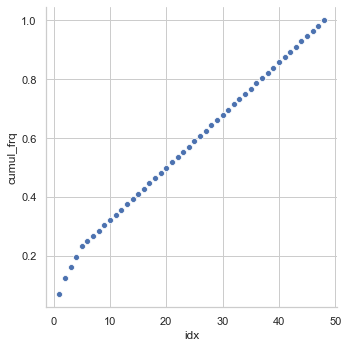

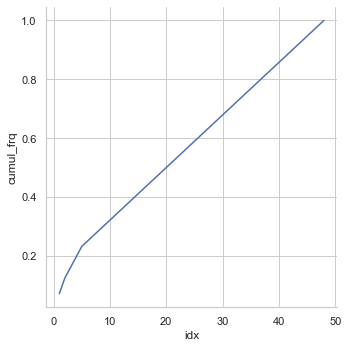

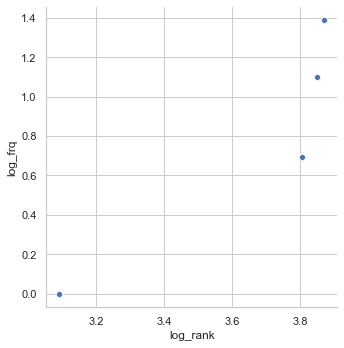

In [17]:
#From lecture (Christian)
import collections
import nltk.tokenize
import numpy
import pandas
import pickle
import seaborn
import matplotlib.pyplot as plt


# tok = nltk.tokenize.TreebankWordTokenizer()
#
# corpus = []
# with open('news-commentary-v16.en', 'r') as f:
#     for line in f:
#         corpus.extend(t for line in f for t in tok.tokenize(line))
#
with open('ncv16-list.pkl', 'wb') as f:
     pickle.dump(tokens, f)

#with open('ncv16-list.pkl', 'rb') as f:
#    corpus = pickle.load(f)

voc = collections.Counter(tokens)
frq = pandas.DataFrame(voc.most_common(), columns=['token', 'frequency'])

# Index in the sorted list
frq['idx'] = frq.index + 1

# Frequency normalised by corpus size
frq['norm_freq'] = frq.frequency / len(tokens)

# Cumulative normalised frequency
frq['cumul_frq'] = frq.norm_freq.cumsum()

seaborn.set(style='whitegrid')

# Plot: Cumulative frequency by index
seaborn.relplot(x='idx', y='cumul_frq', data=frq)
plt.show()

# Plot: Cumulative frequency by index, top 10000 tokens
seaborn.relplot(x='idx', y='cumul_frq', data=frq[:10000], kind='line')
plt.show()

# Plot: Log-log plot for Zipf's law
frq['log_frq'] = numpy.log(frq.frequency)
frq['log_rank'] = numpy.log(frq.frequency.rank(ascending=True))
seaborn.relplot(x='log_rank', y='log_frq', data=frq)
plt.show()

pass

# Manal Annotation and Inter-Annotator Agreement

# Tried to do a compare function, but got stuck but Jeppes works, so discard the following

In [18]:


random.seed(42) #Seeded for consistency
random_tweets = random.sample(list(enumerate(sentiment_raw)),100)
rtweet_index = [i[0] for i in random_tweets]


In [19]:
#Manuel annotation

jeppe = pd.read_csv('../data/interim/manual_annotation/Man_anno_Jeppe.txt',header=None)
gergo = pd.read_csv('../data/interim/manual_annotation/Gergo_man_sentiment.txt',header=None)
frederik = pd.read_csv('../data/interim/manual_annotation/anno_frederik.txt.rtf',header=None)
shakir = pd.read_csv('../data/interim/manual_annotation/Annotation.txt',header=None)

jeppe_labels = []
gergo_labels = []
frederik_labels = []
shakir_labels = []

for i in jeppe:
    if bool(i):
        jeppe_labels.append(i[-1])
for i in gergo:
    if bool(i):
        gergo_labels.append(i[-1])

for i in frederik:
    if bool(i):
        frederik_labels.append(i[-1])

for i in shakir:
    if bool(i):
        shakir_labels.append(i[-1])

In [20]:
#Correct labels for each row

sent_label = pd.read_csv('../data/raw/sentiment/train_labels.txt',header=None)
sent_raw = pd.read_csv("../data/raw/sentiment/train_text.txt",header=None, sep="\n",quoting=3)
off_label = pd.read_csv('../data/raw/offensive/train_labels.txt',header=None)
off_raw = pd.read_csv("../data/raw/offensive/train_text.txt",header=None, sep="\n",quoting=3)

#Creating two dataframes with tweets and labels
off_tweets = pd.DataFrame(off_train, columns = ["Tweets"])
sentiment_tweets = pd.DataFrame(sentiment_train, columns = ["Tweets"])

In [21]:
len(sent_raw)

45615

# Automatic Prediction

# Jeppe has done a better job with this

In [22]:

path_off_test = '../data/raw/offensive/test_text.txt'
path_off_training = '../data/raw/offensive/train_text.txt'
path_off_validation = '../datasets/offensive/val_text.txt'

path_off_test_labels = '../data/raw/offensive/test_labels.txt'
path_off_training_labels = '../data/raw/offensive/train_labels.txt'
path_off_validation_labels = '../data/raw/offensive/val_labels.txt'

In [23]:
#offensive
with open(path_off_test_labels,'r',encoding = 'utf-8') as h:
    offensive_labels = h.readlines()   
    
#test data
with open(path_off_test,'r',encoding = 'utf-8') as d:
    test_data2 = d.readlines()

with open(path_off_test_labels,'r',encoding = 'utf-8') as c:
    test_labels = c.readlines()

    
off_label = []
for i in offensive_labels:
    off_label.append(i.strip('\n'))

test_label = []
for i in test_labels:
    test_label.append(i.strip('\n'))
    
test_data= []
for i in test_data2:
    test_data.append(i.strip('\n'))


In [24]:
count_vect = CountVectorizer()

In [25]:
T = count_vect.fit_transform(test_data)
X = count_vect.fit_transform(test_data)
X_train_counts = count_vect.fit_transform(test_data)
X_train_counts.shape


(860, 5155)

In [26]:
x_array = np.array(X.toarray()) 
test_data_array = np.array(T.toarray())

In [27]:
print(x_array.shape,test_data_array.shape) #checking if they have the same dimensions

(860, 5155) (860, 5155)


In [28]:
# The index value of a word in the vocabulary is linked to its frequency in the whole training corpus.
count_vect.vocabulary_.get("good")

2039

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape


(860, 5155)

In [30]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(860, 5155)

In [31]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, test_data)


In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(),SGDClassifier())
clf.fit(x_array, off_label)
Pipeline([('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [33]:
scores = clf.score(x_array, off_label)
cm = confusion_matrix(test_label, clf.predict(test_data_array))
cr = classification_report(test_label, clf.predict(test_data_array), target_names= ["Offensive", "Not Offensive"])
print(cr)

               precision    recall  f1-score   support

    Offensive       0.97      1.00      0.98       620
Not Offensive       1.00      0.91      0.95       240

     accuracy                           0.97       860
    macro avg       0.98      0.96      0.97       860
 weighted avg       0.98      0.97      0.97       860



In [34]:
tfidf_vectorizer = TfidfVectorizer()

In [35]:
Y = tfidf_vectorizer.fit_transform(test_data)
T1 = tfidf_vectorizer.fit_transform(test_data)

In [36]:
y_array = np.array(Y.toarray())
test_data_array1 = np.array(T1.toarray())

print(y_array.shape,test_data_array1.shape)


(860, 5155) (860, 5155)


In [37]:
clf = make_pipeline(StandardScaler(),SGDClassifier())
clf.fit(x_array, off_label)
Pipeline([('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [38]:
with open("../data/raw/sentiment/train_text.txt", "r",  encoding = "utf-8",) as f:
    sentiment_train = [line for line in f]

with open("../data/raw/sentiment/test_text.txt", "r",  encoding = "utf-8",) as f:
    sentiment_test = [line for line in f]

with open("../data/raw/sentiment/val_text.txt", "r",  encoding = "utf-8",) as f:
    sentiment_val = [line for line in f]
    
    
train_corpus = tokenizer(sentiment_train)
test_corpus= tokenizer(sentiment_test)
validation_corpus = tokenizer(sentiment_val)


#Loading train labels

In [39]:
len(train_corpus)

45615

In [40]:
def sent_data(location):
    sent_list = []
    for line in open(location):
        sent_list.append(line.replace("\n",""))
    
    return sent_list

y_train = sent_data("../data/raw/sentiment/train_text.txt")
y_test = sent_data("../data/raw/sentiment/test_labels.txt")
y_val = sent_data("../data/raw/sentiment/val_labels.txt")

In [41]:
count_vec = CountVectorizer(tokenizer = lambda x: x, lowercase = False)

In [42]:
X = count_vec.fit_transform(train_corpus)
Y = count_vec.fit_transform(test_corpus)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(tokenizer = lambda x: x, lowercase = False)
X_train_counts = count_vect.fit_transform(train_corpus)
X_train_counts.shape

(45615, 58109)

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape


(45615, 58109)

In [45]:
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(45615, 58109)

In [46]:
from sklearn.preprocessing import MultiLabelBinarizer
MultiLabelBinarizer().fit_transform(train_corpus)

train_data_array =  np.array()
test_data_array = np.array(X_train_tfidf.toarray())

TypeError: array() missing required argument 'object' (pos 1)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, train_corpus)

In [47]:
train_data_array =  np.array(test_corpus.toarray())

AttributeError: 'list' object has no attribute 'toarray'